# House Prices Full explained- [A Kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) 

This famous Kaggle competition provides us *The Ames House dataset*, compiled by Dean De Cock, with 79 explanatory variables. We are challenged to predict the house prices of the given test dataset by training a regression model.

## Our goal and steps

This notebook intends to deploy the whole process from understanding data until prediction. That is why we will show all the analytics, although sometimes we won't find anything interesting (but you couldn't guess until done!).

We divide the process into different steps:


[Step 1 - Import, configuration and loading data](#step-1-import-configuration-and-loading-data)

[Step 2 - Data Understanding](#step-2-data-understanding)

[Step 3 - Missing Values](#step-3-missing-values)

[Step 4 - Feature understanding](#step-4-feature-understanding)

[Step 5 - Feature engineering](#step-5-feature-engineering)

[Step 6 - Outliers](#step-6-outliers)

[Step 7 - Skewness](#step-7-skewness)

[Step 8 - Feature relationships](#step-8-feature-relationships)

[Step 9 - Dummies](#step-9-dummies)

[Step 10 - Regularized Linear Regression Model](#step-10-regularized-linear-regression-model)

[Step 11 - Predictions and submission](#step-11-predictions-and-submission)

We found some interesting approaches at:
- [Comprehensive data exploration with Python by Pedro Marcelino](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)
- [Regularized Linear Models by Alexander Papiu](https://www.kaggle.com/code/apapiu/regularized-linear-models/notebook)
- [A study on Regression applied to the Ames dataset by Juliencs](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook)
- [A Detailed Regression Guide with House-pricing](https://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing#Fitting-model(simple-approach)

## Step 1 - Import, configuration and loading data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p   
from scipy.special import inv_boxcox1p
from scipy.stats import boxcox_normmax
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 90)
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv', delimiter=',')
test = pd.read_csv('test.csv', delimiter=',')

## Step 2 - Data Understanding

In [47]:
train.shape

(1460, 81)

In [48]:
test.shape

(1459, 80)

Our train dataset has 1460 rows and 81 columns, while our test dataset has one less column: *SalePrice*, which is our target. Let's have a look to the train dataset:

In [49]:
train.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

We observe there are some missing values which should be processed.

These are our variables and their type:

In [50]:
train.dtypes.sort_values()

Id                 int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
BsmtFinSF2         int64
BsmtFinSF1         int64
SalePrice          int64
MSSubClass         int64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
GarageYrBlt      float64
LotFrontage      float64
MasVnrArea       float64
Foundation        object
GarageFinish      object


At first sight, we can say that our dataset has variables referring to different segments: location, areas/surface, quality, age, accessories or sale and variables that also describe specifically some parts of the house: kitchen, garage, bedrooms, baths, porches... 

We have multiple types of explanatory variables: numeric and object. Maybe we should to convert some variables types, but not before solving the missing values issue.

Let's have a glance at our data statistics, just for numerical variables now:

In [51]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

## Step 3 - Missing Values

At the statistics shown before, we could notice some missing values in our dataset. Maybe there is no need to fill in the missing values, as some variables won't be part of prediction model. However, we will complete all our variables.

We are going to dismiss those variables whose NaNs numbers are high enough and also those rows with more than 80% of the columns filled with NaN. Then, we will go on with imputations. 

### Rows with too many NaN

In [52]:
NAperRow = train.isnull().mean(axis=1)  # mean of NaN per row
threshold = 0.8
train_clean = train[NAperRow <= threshold].copy()

In [53]:
train_clean.shape

(1460, 81)

No rows have been deleted.

### Columns with too many NaN

Imputation process must be applied to both the train and test datasets. We are going to manage them all together:

In [54]:
train_test = pd.concat((train_clean.loc[:, 'MSSubClass':'SaleCondition'], 
                       test.loc[:, 'MSSubClass':'SaleCondition'])).reset_index(drop=True) #stacking both datasets

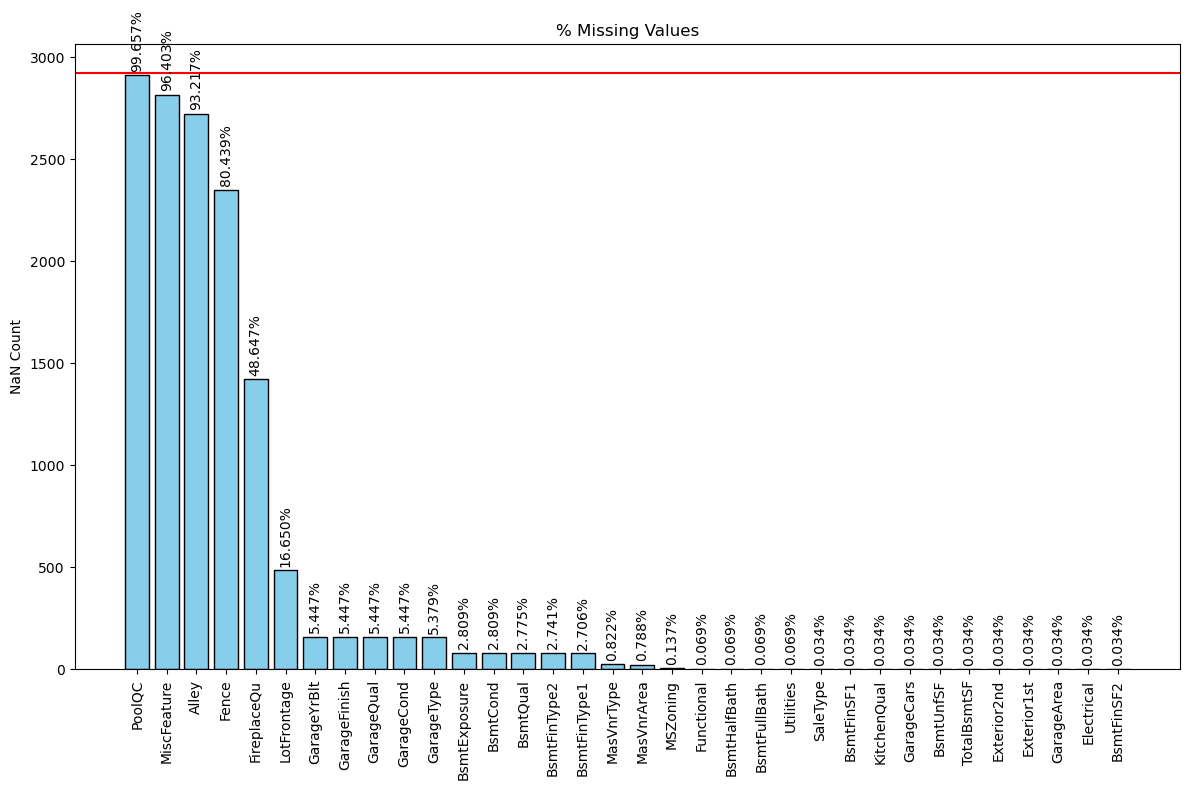

In [55]:
howManyNaN = train_test.isna().sum().sort_values(ascending=False)  # sum of NaN per column
howManyNaN = howManyNaN[howManyNaN > 0]  # only columns with NaN values

howManyNaN_percent = (howManyNaN/train_test.shape[0]).sort_values(ascending=False)
missing_values = pd.concat([howManyNaN, howManyNaN_percent], axis=1, keys=['NaN Count', '%NaN'])

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.axhline(y=train_test.shape[0], color='r', linestyle='-', label='Total rows') # number of rows
bars = ax1.bar(missing_values.index, 
               missing_values['NaN Count'], 
               color='skyblue', 
               edgecolor='black',
               label='NaN Count')

for bar, val in zip(bars, missing_values['%NaN']):  # percentages
    ax1.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height()+20, f'{val:.3%}', 
             ha='center', 
             va='bottom', 
             rotation='vertical')

ax1.set_ylabel('NaN Count')
ax1.set_title('% Missing Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# in case you want to show a table with numbers:
#missing_values[missing_values['NA Count'] != 0]

We find so many missing values in variables *Alley* and *Fence* that we can discard them as they wouldn't provide important information to our prediction model. We will try to fill in *PoolQC* and *MiscFeature* with the information given by their complementary variables: *PoolArea* and *MiscVal*.

*Id* and *SalePrice* variables won't be handled in the missing-values process.

In [56]:
train_test = train_test[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'
       #'Fence','Alley', 
                          ]]

### Missing values imputation

#### MSZoning

In [57]:
train_test.loc[train_test['MSZoning'].isna()]

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
1915          30      NaN        109.0    21780   Grvl      Reg         Lvl   
2216          20      NaN         80.0    14584   Pave      Reg         Low   
2250          70      NaN          NaN    56600   Pave      IR1         Low   
2904          20      NaN        125.0    31250   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope Neighborhood Condition1 Condition2  \
1915       NaN    Inside       Gtl       IDOTRR       Norm       Norm   
2216    AllPub    Inside       Mod       IDOTRR       Norm       Norm   
2250    AllPub    Inside       Gtl       IDOTRR       Norm       Norm   
2904    AllPub    Inside       Gtl      Mitchel     Artery       Norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
1915     1Fam     1Story            2            4       1910          1950   
2216     1Fam     1Story            1            5       1952          1952   
2250     1Fam     2.5Unf            5            1       1900          1950   
2904     1Fam     1Story            1            3       1951          1951   

     RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea  \
1915     Gable  CompShg     Wd Sdng     Wd Sdng       None         0.0   
2216     Gable  CompShg     AsbShng     VinylSd       None         0.0   
2250       Hip  CompShg     Wd Sdng     Wd Sdng       None         0.0   
2904     Gable  CompShg      CBlock     VinylSd       None         0.0   

     ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
1915        Fa        Fa     CBlock      NaN      NaN          NaN   
2216        Fa        Po       Slab      NaN      NaN          NaN   
2250        TA        TA     BrkTil       TA       TA           No   
2904        TA        Fa     CBlock      NaN      NaN          NaN   

     BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
1915          NaN         0.0          NaN         0.0        0.0   
2216          NaN         0.0          NaN         0.0        0.0   
2250          Unf         0.0          Unf         0.0      686.0   
2904          NaN         0.0          NaN         0.0        0.0   

      TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
1915          0.0    GasA        TA          N      FuseA       810         0   
2216          0.0    Wall        Po          N      FuseA       733         0   
2250        686.0    GasA        Ex          Y      SBrkr      1150       686   
2904          0.0    GasA        TA          Y      FuseA      1600         0   

      LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
1915             0        810           0.0           0.0         1         0   
2216             0        733           0.0           0.0         1         0   
2250             0       1836           0.0           0.0         2         0   
2904             0       1600           0.0           0.0         1         1   

      BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  \
1915             1             1          TA             4       Min1   
2216             2             1          Fa             4        NaN   
2250             4             1          TA             7       Maj1   
2904             3             1          TA             6        Mod   

      Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  \
1915           0         NaN     Detchd       1975.0          Unf         1.0   
2216           0         NaN     Attchd       1952.0          Unf         2.0   
2250           0         NaN     Detchd       1900.0          Unf         1.0   
2904           0         NaN     Attchd       1951.0          Unf         1.0   

      GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  \
1915       280.0         TA         TA          N         119           24   
2216       487.0         Fa         Po  

If we group our houses by *Neighborhood*, these are *MSZoning* values for each neighborhood. As *MSZoning* depends on *Neigborhood*, we will impute the most frequent value for its neighborhood:

<Figure size 800x500 with 0 Axes>

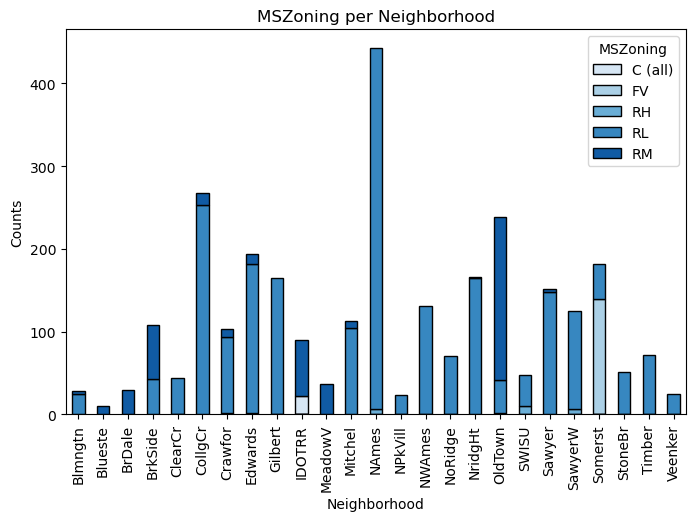

In [58]:
data = train_test.groupby(['Neighborhood', 'MSZoning']).size().unstack()
n_colors = len(data.columns) 
colors = sns.color_palette('Blues', n_colors)
plt.figure(figsize=(8, 5))
data.plot(kind='bar', stacked=True, figsize=(8, 5), color=colors, edgecolor='black')
plt.title('MSZoning per Neighborhood', fontsize = 12)
plt.xlabel('Neighborhood', fontsize = 10)
plt.ylabel('Counts', fontsize = 10)
plt.xticks(rotation=90)  
plt.show()

In [59]:
train_test['MSZoning'] = train_test.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#### MiscFeature

*MiscVal* is the value in dollars of *MiscFeature*. If *MiscVal* = 0, we can impute *MiscFeature*= 'NA'(= None)

In [60]:
train_test.loc[train_test['MiscVal'] == 0, 'MiscFeature'] = 'NA'
train_test['MiscFeature'] = train_test['MiscFeature'].fillna('Othr')

#### LotFrontage 

We assume that *LotFrontage* mean values depend on neighborhood. Let's see:

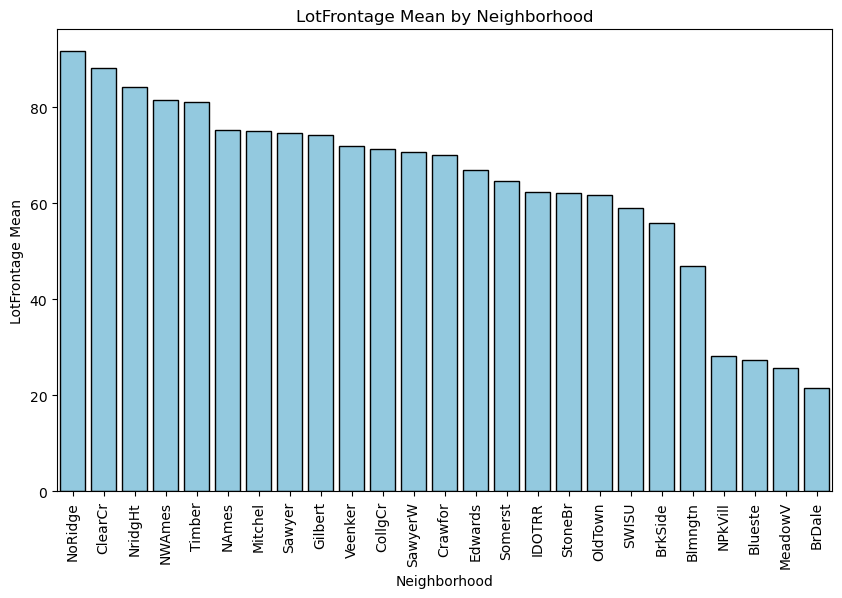

In [61]:
meanLotFrontage = train_test.groupby('Neighborhood')['LotFrontage'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=meanLotFrontage.index, 
            y=meanLotFrontage.values,
            color='skyblue', 
            edgecolor='black')
plt.title('LotFrontage Mean by Neighborhood', fontsize=12)
plt.xlabel('Neighborhood', fontsize=10)
plt.ylabel('LotFrontage Mean', fontsize=10)
plt.xticks(rotation=90)
plt.show()

We are going to impute to *LotFrontage* the mean value for the neighborhood's house:

In [62]:
train_test['LotFrontage'] = train_test.groupby('Neighborhood')['LotFrontage'] \
                                      .transform(lambda x: x.fillna(x.mean()))

#### MasVnrType and MasVnrArea

Do NaN values at variables *MasVnrType* and *MasVnrArea* refer to the same houses? 

In [63]:
#train_test[train_test['MasVnrType'].isna()][['MasVnrType', 'MasVnrArea']]
print('Rows with MasVnrType=NaN: ', train_test['MasVnrType'].isna().sum())
print('Rows with MasVnrArea=NaN: ', train_test['MasVnrArea'].isna().sum())
print('Rows with both NaN: ', len(train_test[train_test[['MasVnrType', 'MasVnrArea']].isna().all(axis=1)]))

Rows with MasVnrType=NaN:  24
Rows with MasVnrArea=NaN:  23
Rows with both NaN:  23


When NaN values refer to the same houses (23 rows), we can conclude that there is no *MasVnr*. We can impute 0 to *MasVnrArea* and 'None' to MasVnrtype:

In [64]:
train_test.loc[train_test['MasVnrArea'].isna(),['MasVnrType', 'MasVnrArea']] = ['None', 0]

Otherwise (1 row), we impute the most frequent value except 'None', because there is a value for Area!

In [65]:
train_test['MasVnrType'].value_counts()

None       1765
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

In [66]:
train_test.loc[train_test['MasVnrType'].isna(),'MasVnrType'] = 'BrkFace'

#### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

Let's check out if there is any relationship between NaN values in variables *BsmtQual*, *BsmtCond*, *BsmtExposure*, *BsmtFinType1*, *BsmtFinType2*

In [67]:
train_test[train_test['BsmtExposure'].isna()][['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
17        NaN      NaN          NaN          NaN          NaN
39        NaN      NaN          NaN          NaN          NaN
90        NaN      NaN          NaN          NaN          NaN
102       NaN      NaN          NaN          NaN          NaN
156       NaN      NaN          NaN          NaN          NaN
182       NaN      NaN          NaN          NaN          NaN
259       NaN      NaN          NaN          NaN          NaN
342       NaN      NaN          NaN          NaN          NaN
362       NaN      NaN          NaN          NaN          NaN
371       NaN      NaN          NaN          NaN          NaN
392       NaN      NaN          NaN          NaN          NaN
520       NaN      NaN          NaN          NaN          NaN
532       NaN      NaN          NaN          NaN          NaN
533       NaN      NaN          NaN          NaN          NaN
553       NaN      NaN          NaN          NaN          NaN
646       NaN      NaN          NaN          NaN          NaN
705       NaN      NaN          NaN          NaN          NaN
736       NaN      NaN          NaN          NaN          NaN
749       NaN      NaN          NaN          NaN          NaN
778       NaN      NaN          NaN          NaN          NaN
868       NaN      NaN          NaN          NaN          NaN
894       NaN      NaN          NaN          NaN          NaN
897       NaN      NaN          NaN          NaN          NaN
948        Gd       TA          NaN          Unf          Unf
984       NaN      NaN          NaN          NaN          NaN
1000      NaN      NaN          NaN          NaN          NaN
1011      NaN      NaN          NaN          NaN          NaN
1035      NaN      NaN          NaN          NaN          NaN
1045      NaN      NaN          NaN          NaN          NaN
1048      NaN      NaN          NaN          NaN          NaN
1049      NaN      NaN          NaN          NaN          NaN
1090      NaN      NaN          NaN          NaN          NaN
1179      NaN      NaN          NaN          NaN          NaN
1216      NaN      NaN          NaN          NaN          NaN
1218      NaN      NaN          NaN          NaN          NaN
1232      NaN      NaN          NaN          NaN          NaN
1321      NaN      NaN          NaN          NaN          NaN
1412      NaN      NaN          NaN          NaN          NaN
1487       Gd       TA          NaN          Unf          Unf
1585      NaN      NaN          NaN          NaN          NaN
1593      NaN      NaN          NaN          NaN          NaN
1729      NaN      NaN          NaN          NaN          NaN
1778      NaN      NaN          NaN          NaN          NaN
1814      NaN      NaN          NaN          NaN          NaN
1847      NaN      NaN          NaN          NaN          NaN
1848      NaN      NaN          NaN          NaN          NaN
1856      NaN      NaN          NaN          NaN          NaN
1857      NaN      NaN          NaN          NaN          NaN
1858      NaN      NaN          NaN          NaN          NaN
1860      NaN      NaN          NaN          NaN          NaN
1915      NaN      NaN          NaN          NaN          NaN
2050      NaN      NaN          NaN          NaN          NaN
2066      NaN      NaN          NaN          NaN          NaN
2068      NaN      NaN          NaN          NaN          NaN
2120      NaN      NaN          NaN          NaN          NaN
2122      NaN      NaN          NaN          NaN          NaN
2188      NaN      NaN          NaN          NaN          NaN
2189      NaN      NaN          NaN          NaN          NaN
2190      NaN      NaN          NaN          NaN          NaN
2193      NaN      NaN          NaN          NaN          NaN
2216      NaN      NaN          NaN          NaN          NaN
2224      NaN      NaN          NaN          NaN          NaN
2348       Gd       TA          NaN          Unf          Unf
2387      NaN      NaN          NaN  

It seems that there is no basement in these houses. So the proper value for these variables is 'NA' (=No basement), except for Id=948, 1487, 2348, whose *BsmtExposure* should be 'No' (=No exposure).

In [68]:
train_test.loc[train_test['BsmtCond'].isna(), 
               ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = 'NA'
train_test.loc[train_test['BsmtCond'] == 'NA', 
                 ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = 0

train_test.loc[train_test['BsmtExposure'].isna(),'BsmtExposure'] = 'No' # Id=948,1487,2348

train_test.loc[train_test['TotalBsmtSF'].isna(), 
                 ['TotalBsmtSF','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath']] = 0

#### Electrical, Utilities, Functional, KitchenQual, SaleType

We will impute the most frequent value for these variables:

In [69]:
for x in ('Electrical', 'Utilities', 'Functional', 'KitchenQual', 'SaleType'):
    train_test[x] = train_test[x].fillna(train_test[x].mode()[0])


#### Exterior1st, Exterior2nd

In [70]:
train_test.loc[train_test['Exterior1st'].isna(), ['Exterior1st', 'Exterior2nd']]

Exterior1st Exterior2nd
2151         NaN         NaN

NaN values refer to the same house. We will impute the first and second most frequent values: VinylSd and MetalSd

In [71]:
Ext1_counts = train_test['Exterior1st'].value_counts().sort_values(ascending=False)
print(Ext1_counts)

train_test.loc[train_test['Exterior1st'].isna(), ['Exterior1st', 'Exterior2nd']] \
         = [Ext1_counts.index[0], Ext1_counts.index[1]]              

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64


#### FireplaceQu

We guess that there are no fireplaces where *FireplaceQu*=NaN, so we will impute 'NA' (=No fireplaces) when *Fireplaces*=0

In [72]:
train_test.loc[train_test['Fireplaces'] == 0, 'FireplaceQu'] = 'NA'

#### GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

NaN values for Garage variables make us think that there isn't garage...

In [73]:
train_test.loc[train_test['GarageCars'] == 0, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = 'NA'

train_test['GarageYrBlt'].fillna(train_test['YearBuilt'], inplace=True)

Let's check out for more NaN...

In [74]:
train_test.loc[train_test['GarageQual'].isna(),[c for c in train_test.columns if 'Garage' in c]]

GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
2126     Detchd       1910.0          NaN         1.0       360.0        NaN   
2576     Detchd       1923.0          NaN         NaN         NaN        NaN   

     GarageCond  
2126        NaN  
2576        NaN

We can impute the most frequent value for these variables:

In [75]:
for x in ('GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'):
    train_test[x] = train_test[x].fillna(train_test[x].mode()[0])

#### PoolQC

When PoolArea= 0, PoolQC should be 'NA' (=No pool)

In [76]:
train_test.loc[train_test['PoolArea'] == 0, 'PoolQC'] = 'NA'
train_test['PoolQC'] = train_test['PoolQC'].fillna('TA')

Checking out if there is still any missing value...

In [77]:
howManyNA = train_test.isna().sum()
howManyNA[howManyNA > 0]

BsmtQual        2
BsmtFinType2    1
dtype: int64

We will inspect Bsmt variables:

In [78]:
train_test.loc[train_test['BsmtQual'].isna(),[c for c in train_test.columns if 'Bsmt' in c]]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
2217      NaN       Fa           No          Unf         0.0          Unf   
2218      NaN       TA           No          Unf         0.0          Unf   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
2217         0.0      173.0        173.0           0.0           0.0  
2218         0.0      356.0        356.0           0.0           0.0

It makes sense to impute with the same quality values as *BsmtCond*:

In [79]:
train_test['BsmtQual'] = train_test['BsmtQual'].fillna(train_test['BsmtCond'])

Let's take a look to this row...

In [80]:
train_test.loc[train_test['BsmtFinType2'].isna()][[c for c in train_test.columns if 'Bsmt' in c]]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
332       Gd       TA           No          GLQ      1124.0          NaN   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
332       479.0     1603.0       3206.0           1.0           0.0

We need to know which is the most frequent value to *BsmtFinType2* when *BsmtFinType1*='GLQ'. We will create a subset for this condition and see the statistics:

In [81]:
moda = train_test.loc[train_test['BsmtFinType1'] == 'GLQ']['BsmtFinType2'].mode()[0]
train_test['BsmtFinType2'] = train_test['BsmtFinType2'].fillna(moda)

In [82]:
train_test.isna().sum().max()

0

Our dataset has now no missing values.

## Step 4 - Feature understanding

We are going to undertake an univariate analysis on training dataset. For this purpose, we need to split train and test datasets and add *SalePrice* column again.

But first we are going to verify some checks on the variables related to years:
- YearBuilt < YearRemodAdd
- YearBuilt <= YrSold
- YearRemodAdd <= YrSold

In [83]:
(train_test['YearBuilt'] > train_test['YearRemodAdd']).sum()

1

*YearRemodAdd* is changed to *YearBuilt* when *YearBuilt*>*YearRemodAdd*

In [84]:
train_test.loc[train_test['YearBuilt'] > train_test['YearRemodAdd'], 'YearRemodAdd'] = train_test['YearBuilt']

In [85]:
(train_test['YearBuilt'] > train_test['YrSold']).sum()

1

*YrSold* is changed to *YearRemodAdd* when *YearBuilt*>*YrSold*

In [86]:
train_test.loc[train_test['YearBuilt'] > train_test['YrSold'], 'YrSold'] = train_test['YearRemodAdd']

In [87]:
(train_test['YearRemodAdd'] > train_test['YrSold']).sum()

2

In [88]:
train_test.loc[train_test['YearRemodAdd'] > train_test['YrSold'], 'YrSold'] = train_test['YearRemodAdd']

*YrSold* is changed to *YearRemodAdd* when *YearRemodADD*>*YrSold*

Now, we can split datasets:

In [89]:
train_sel = train_test.head(len(train_clean)).copy() # splitting datasets
test_sel = train_test.tail(len(test)).copy()
test_sel.reset_index(drop=True, inplace=True)

train_sel['SalePrice'] = train_clean['SalePrice']

We would appreciate some more information about:
- [description](./data_description.txt)
- statistics 
- categories 
- frequency 
- relationship with *SalePrice* 

This knowledge will help us to estimate the importance of each variable and make an appropiate selection of them for our prediction model.

Our dataset has four types of variables:
- Categorical
    - Nominal
    - Ordinal
- Numerical
    - Discrete
    - Continuous


We need to define some procedures for our graphical analysis that we are going to execute many times in our analysis:

In [91]:
def plotCategorical(df, var1, var2):  # Categorical/Discrete variables - frequency bars & boxplot(vs. SalePrice)
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    df[var1].value_counts().plot(kind='bar',
                                 color='skyblue', 
                                 edgecolor='black')
    plt.title(var1+' Counts', fontsize=12)
    plt.xlabel(var1, fontsize=10)
    plt.ylabel('Counts', fontsize=10)

    plt.subplot(1, 2, 2)
    medians = df.groupby(var1)[var2].median().sort_values()
    order = medians.index.tolist()
    sns.boxplot(x=var1, y=var2, data=df, order=order)
    plt.title(var2+' vs '+var1, fontsize=12)
    plt.xlabel(var1, labelpad=15)
    plt.tick_params(axis='x', labelrotation=90)

    plt.tight_layout() 
    plt.show()
    
    
def plotContinuous(df, var1, var2):   # Continuous variables - histogram & scatter with regression (vs. SalePrice)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

    sns.histplot(df[var1], 
                 bins=int(np.sqrt(df.shape[0])), 
                 kde=False, 
                 color='skyblue', 
                 edgecolor='black',
                 ax=axes[0])  # Histograma con densidad
    axes[0].set_title('Histogram '+var1, fontsize=12)
    axes[0].set_xlabel(var1, fontsize=10, labelpad=15)
    axes[0].set_ylabel('Frequency', fontsize=10)

    sns.regplot(x=var1, 
                y=var2, 
                data=df, 
                scatter=True, 
                line_kws={'color': 'red'}, 
                scatter_kws={'color': 'skyblue'},
                ax=axes[1])
    axes[1].set_title(var1+' vs '+var2, fontsize=12)
    axes[1].set_xlabel(var1, fontsize=10)
    axes[1].set_ylabel(var2, fontsize=10)

    plt.tight_layout()
    plt.show()

### Our target variable: SalePrice

Here we have some information about our goal variable:

In [92]:
train_sel['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Let's draw a histogram and a qqplot to know more about its shape:

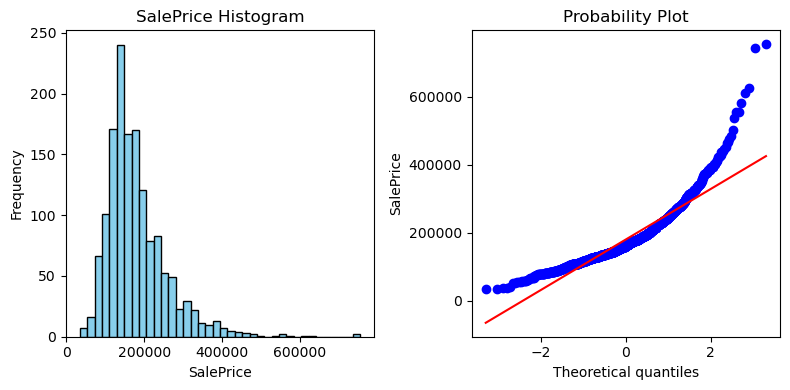

In [96]:
var = 'SalePrice'
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
probplot =train_sel[var].plot(kind='hist',
                    bins=int(np.sqrt(train_sel.shape[0])),
                    color='skyblue', 
                    edgecolor='black')
plt.title(var+' Histogram', fontsize=12)
plt.xlabel(var, fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(1, 2, 2)
stats.probplot(train_sel[var], 
               plot=plt)    
plt.ylabel(var, fontsize=10)
plt.ylabel(var, fontsize=10)
plt.tight_layout()
plt.show()

These are the numbers for skewness and Kurtosis:

In [97]:
print("Skewness: %f" % train_sel['SalePrice'].skew())
print("Kurtosis: %f" % train_sel['SalePrice'].kurt()) 

Skewness: 1.882876
Kurtosis: 6.536282


In [98]:
lambda_value = boxcox_normmax(train_sel['SalePrice'] + 1)
train_sel['SalePrice'] = boxcox1p(train_sel['SalePrice'], lambda_value)

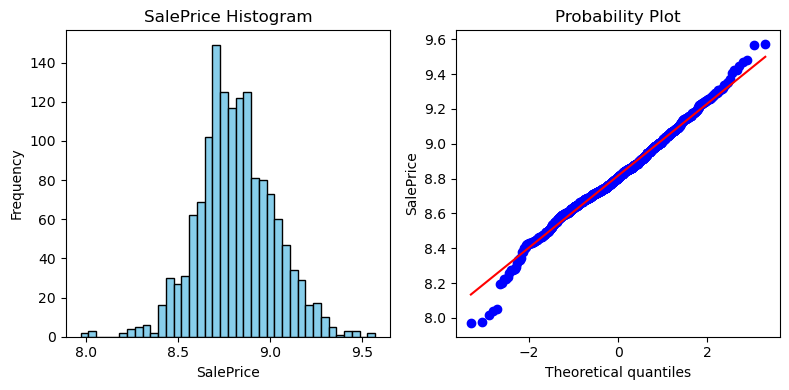

In [99]:
var = 'SalePrice'
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
train_sel[var].plot(kind='hist',
                    bins=int(np.sqrt(train_sel.shape[0])),
                    color='skyblue', 
                    edgecolor='black')
plt.title(var+' Histogram', fontsize=12)
plt.xlabel(var, fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(1, 2, 2)
stats.probplot(train_sel[var], 
               plot=plt)
plt.ylabel(var, fontsize=10)

plt.tight_layout()
plt.show()

It looks much better now! We will apply this process later for other variables.

### Categorical, nominal explanatory variables

Here we have some information or each categorical, nominal variable. Depending of frequency and relationship with *SalePrice*, we will reduce and map categories into new ones. Later on, we will address the factoring of this type of variables creating dummies.

#### MSSubClass

Identifies the type of dwelling involved in the sale. (Categorical, nominal)
    
|Category|Description|
|:-------:|:--------|
|20|1-STORY 1946 & NEWER ALL STYLES|
|30|1-STORY 1945 & OLDER|
|40|1-STORY W/FINISHED ATTIC ALL AGES|
|45|1-1/2 STORY - UNFINISHED ALL AGES|
|50|1-1/2 STORY FINISHED ALL AGES|
|60|2-STORY 1946 & NEWER|
|70|2-STORY 1945 & OLDER|
|75|2-1/2 STORY ALL AGES|
|80|SPLIT OR MULTI-LEVEL|
|85|SPLIT FOYER|
|90|DUPLEX - ALL STYLES AND AGES|
|120|1-STORY PUD (Planned Unit Development) - 1946 & NEWER|
|150|1-1/2 STORY PUD - ALL AGES|
|160|2-STORY PUD - 1946 & NEWER|
|180|PUD - MULTILEVEL - INCL SPLIT LEV/FOYER|
|190|2 FAMILY CONVERSION - ALL STYLES AND AGES|

In [100]:
train_sel['MSSubClass'].dtypes

dtype('int64')

We realized that *MSSubClass* isn't a numerical variable, so let's change its type in both datasets:

In [101]:
var = 'MSSubClass'
train_sel[var] = train_sel[var].astype(str)
test_sel[var] = test_sel[var].astype(str)

In [102]:
train_sel[var].describe()

count     1460
unique      15
top         20
freq       536
Name: MSSubClass, dtype: object

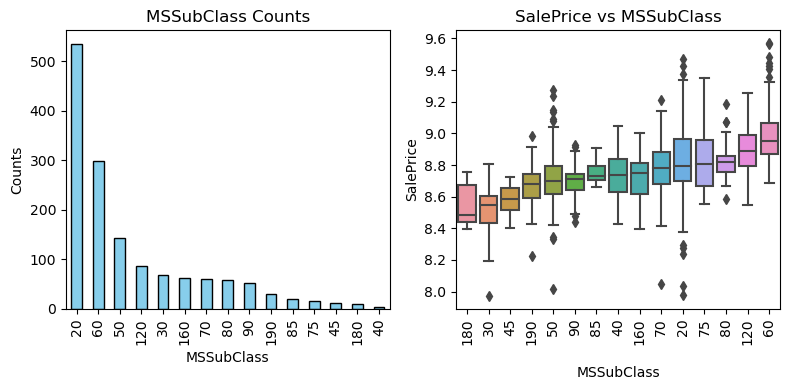

In [103]:
plotCategorical(train_sel, var, 'SalePrice')

The most remarkable of *MSSubClass* is that more than half of the houses are classified into two categories (20, 60).

We can map categories corresponding to their relationship with *SalePrice*:
|New category|Old categories|
|:----------:|:-------------|
|A|180, 30, 45|
|B|190, 50, 90, 85|
|D|40, 160, 70|
|E|20, 75, 80|
|F|120, 60|

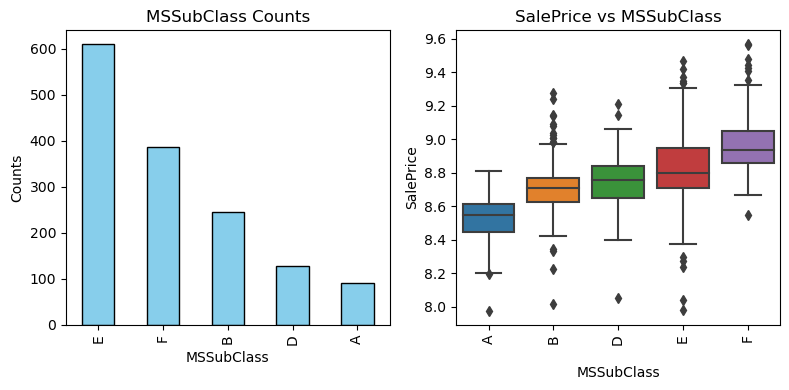

In [104]:
mapping = {'180': 'A', '30': 'A', '45': 'A', 
           '190': 'B', '50': 'B', '90': 'B', '85': 'B', 
           '40': 'D', '160':'D', '70':'D', 
           '20': 'E', '75':'E', '80':'E',
           '120': 'F', '60': 'F'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)
plotCategorical(train_sel, var, 'SalePrice')

#### MSZoning

Identifies the general zoning classification of the sale. (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|A|Agriculture|
|C|Commercial|
|FV|Floating Village Residential|
|I|Industrial|
|RH|Residential High Density|
|RL|Residential Low Density|
|RP|Residential Low Density Park|
|RM|Residential Medium Density|

In [105]:
var = 'MSZoning'
train_sel[var].describe()

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

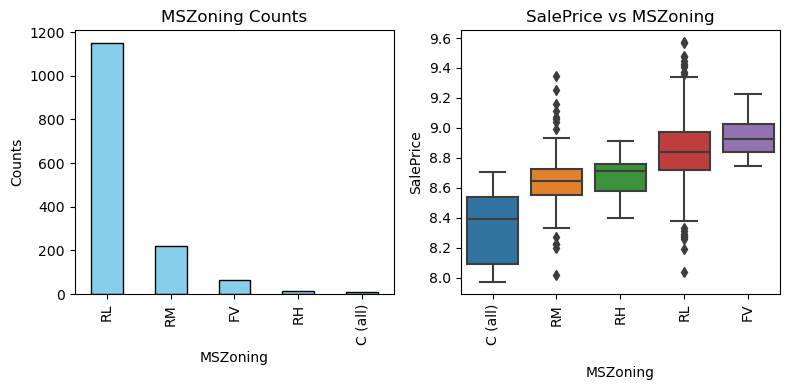

In [106]:
plotCategorical(train_sel, var, 'SalePrice')

Most of the houses are classified as 'RL'. We are going to map:
|New Category|Old Category|
|:-----------|:-----------|
|C|C(all)|
|RMH|RM, RH|
|RL|RL|
|FV|FV|

In [107]:
mapping = {'C(all)': 'C', 
           'RM': 'RMH', 'RH': 'RMH'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

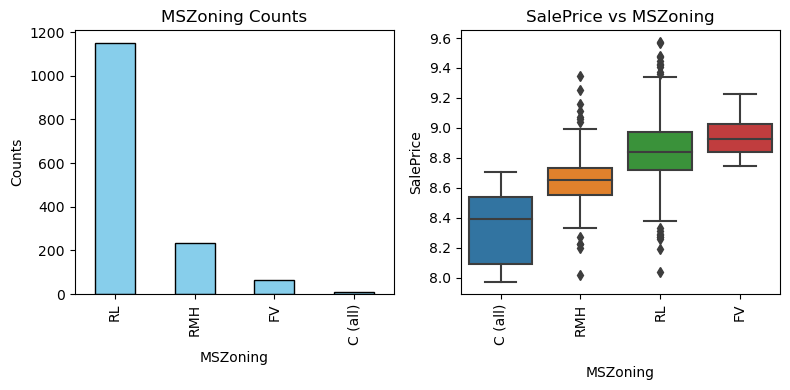

In [108]:
plotCategorical(train_sel, var, 'SalePrice')

#### MiscFeature

Miscellaneous feature not covered in other categories
|Category|Description|
|:----------:|:-------------|
|Elev|Elevator|
|Gar2|2nd Garage (if not described in garage section)|
|Othr|Other|
|Shed|Shed (over 100 SF)|
|TenC|Tennis Court|
|NA|None|

In [109]:
var = 'MiscFeature'
train_sel[var].describe()

count     1460
unique       5
top         NA
freq      1408
Name: MiscFeature, dtype: object

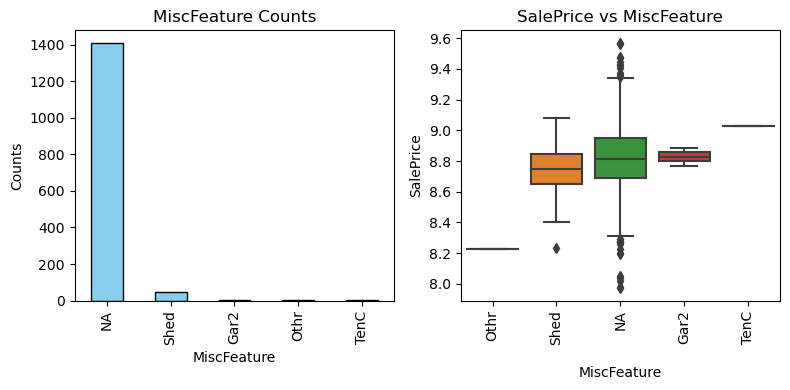

In [110]:
plotCategorical(train_sel, var, 'SalePrice')

Judging by the boxplot data, the only interesting feature is Shed. *MiscFeature* and *MiscVal* don't significantly influence *SalePrice*. We will create a new variable *hasShed*

#### LotConfig

Lot configuration
|Category|Description|
|:----------:|:-------------|
|Inside|Inside lot|
|Corner|Corner lot|
|CulDSac|Cul-de-sac|
|FR2|Frontage on 2 sides of property|
|FR3|Frontage on 3 sides of property|

In [111]:
var = 'LotConfig'
train_clean[var].describe()

count       1460
unique         5
top       Inside
freq        1052
Name: LotConfig, dtype: object

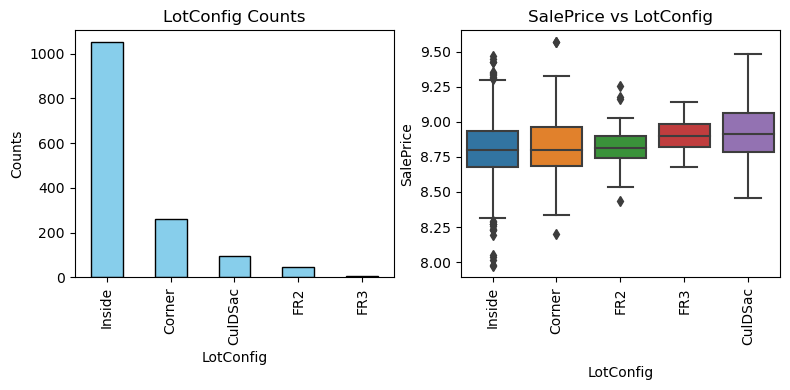

In [112]:
plotCategorical(train_sel, var, 'SalePrice')

Most of the houses are classified as 'Inside'.
We are going to map:
|New Category|Old Category|
|:-----------|:-----------|
|FR3|FR3,CulDSac|
|FR2|FR2, Corner|
|Inside|Inside|

In [113]:
mapping = {'CulDSac': 'FR3', 
           'Corner': 'FR2'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

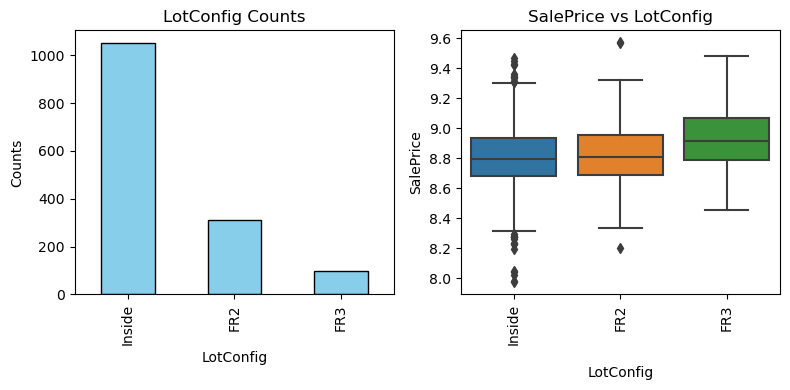

In [114]:
plotCategorical(train_sel, var, 'SalePrice')

#### Neighborhood

Physical locations within Ames city limits (Categorical, nominal)
|Category|Description|
|:-----------|:-------------|
|Blmngtn|Bloomington Heights|
|Blueste|Bluestem|
|BrDale|Briardale|
|BrkSide|Brookside|
|ClearCr|Clear Creek|
|CollgCr|College Creek|
|Crawfor|Crawford|
|Edwards|Edwards|
|Gilbert|Gilbert|
|IDOTRR|Iowa DOT and Rail Road|
|MeadowV|Meadow Village|
|Mitchel|Mitchell|
|Names|North Ames|
|NoRidge|Northridge|
|NPkVill|Northpark Villa|
|NridgHt|Northridge Heights|
|NWAmes|Northwest Ames|
|OldTown|Old Town|
|SWISU|South & West of Iowa State University|
|Sawyer|Sawyer|
|SawyerW|Sawyer West|
|Somerst|Somerset|
|StoneBr|Stone Brook|
|Timber|Timberland|
|Veenker|Veenker|

In [115]:
var = 'Neighborhood'
train_clean[var].describe()

count      1460
unique       25
top       NAmes
freq        225
Name: Neighborhood, dtype: object

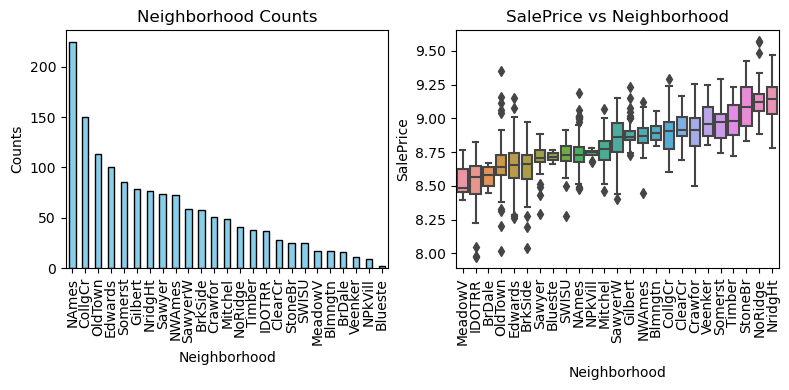

In [116]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:

|New Category|Old Category|
|:-----------:|:-----------|
|E|NridgHt,NoRidge,StoneBr|
|D|Timber,Somerst,Veenker,Crawfor,ClearCr,CollgCr,Blmngtn,Gilbert,NWAmes,SawyerW|
|C|Sawyer,Blueste,SWISU,Names,NPkVill,Mitchel|
|B|OldTown,Edwards,BrkSide|
|A|MeadowV,IDOTRR,BrDale|

In [117]:
mapping = {'NridgHt': 'E', 'NoRidge': 'E', 'StoneBr': 'E', 
           'Timber': 'D','Somerst': 'D','Veenker': 'D','Crawfor': 'D','ClearCr': 'D',
           'Gilbert': 'D','NWAmes': 'D','SawyerW': 'D', 'CollgCr': 'D','Blmngtn': 'D',
           'Sawyer':'C','Blueste':'C','SWISU':'C','NAmes':'C','NPkVill':'C','Mitchel':'C',
           'OldTown':'B','Edwards':'B','BrkSide':'B',
           'MeadowV':'A','IDOTRR':'A','BrDale':'A'
          }
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

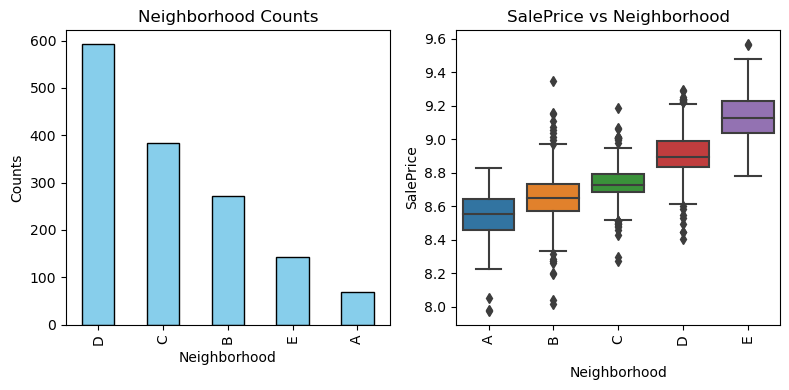

In [118]:
plotCategorical(train_sel, var, 'SalePrice')

#### Condition1

Proximity to various conditions (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|Artery|Adjacent to arterial street|
|Feedr|Adjacent to feeder street|
|Norm|Normal|	
|RRNn|Within 200' of North-South Railroad|
|RRAn|Adjacent to North-South Railroad|
|PosN|Near positive off-site feature--park, greenbelt, etc.|
|PosA|Adjacent to postive off-site feature|
|RRNe|Within 200' of East-West Railroad|
|RRAe|Adjacent to East-West Railroad|

In [119]:
var = 'Condition1'
train_sel[var].describe()

count     1460
unique       9
top       Norm
freq      1260
Name: Condition1, dtype: object

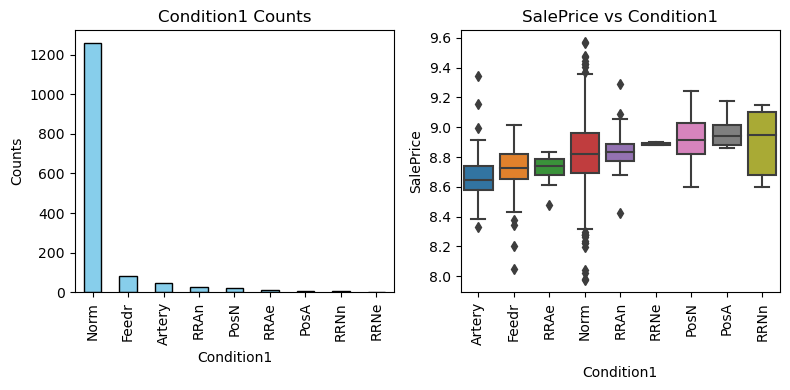

In [120]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:

|New Category|Old Category|
|:-----------:|:-----------|
|B|RRAn, RRNe, PosN, PosA,RRNn|
|Norm|Norm|
|A|Artery, Feedr, RRAe|


In [121]:
mapping = {'RRAn':'B', 'RRNe':'B', 'PosN':'B','PosA':'B','RRNn': 'B', 
           'Artery':'A', 'Feedr':'A', 'RRAe':'A'
          }
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

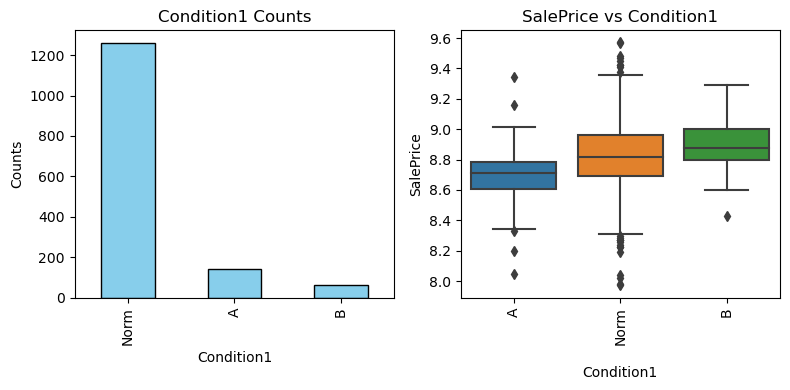

In [122]:
plotCategorical(train_sel, var, 'SalePrice')

#### Condition2

Proximity to various conditions (if more than one is present) (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|Artery|Adjacent to arterial street|
|Feedr|Adjacent to feeder street|
|Norm|Normal|	
|RRNn|Within 200' of North-South Railroad|
|RRAn|Adjacent to North-South Railroad|
|PosN|Near positive off-site feature--park, greenbelt, etc.|
|PosA|Adjacent to postive off-site feature|
|RRNe|Within 200' of East-West Railroad|
|RRAe|Adjacent to East-West Railroad|

In [123]:
var = 'Condition2'
train_sel[var].describe()

count     1460
unique       8
top       Norm
freq      1445
Name: Condition2, dtype: object

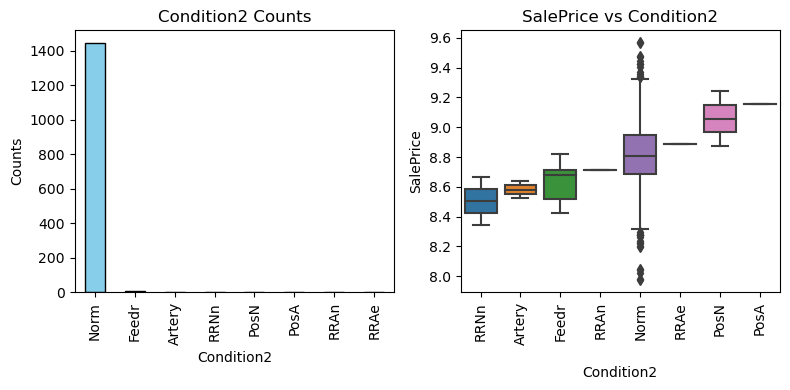

In [124]:
plotCategorical(train_sel, var, 'SalePrice')

*Condition2* doesn't contribute substantial information. 

#### BldgType

Type of dwelling (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|1Fam|Single-family Detached|Category|Description|
|2FmCon|Two-family Conversion; originally built as one-family dwelling|
|Duplx|Duplex|
|TwnhsE|Townhouse End Unit|
|TwnhsI| Inside Unit|

In [125]:
var = 'BldgType'
train_clean[var].describe()

count     1460
unique       5
top       1Fam
freq      1220
Name: BldgType, dtype: object

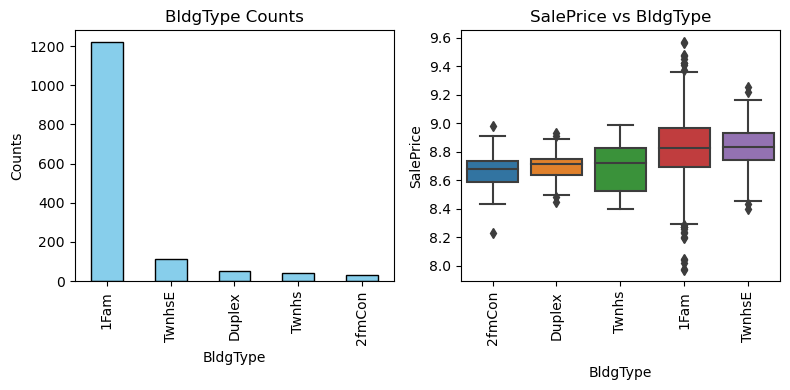

In [126]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:

|New Category|Old Category|
|:-----------:|:-----------|
|TwnhsE|TwnhsE|
|1Fam|1Fam|
|Othr|2fmCon, Duplex, Twnhs|

In [127]:
mapping = {'2fmCon':'Othr', 'Duplex':'Othr', 'Twnhs':'Othr'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

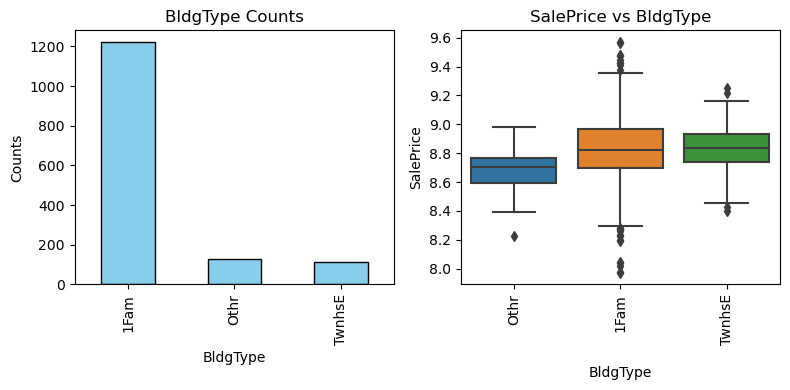

In [128]:
plotCategorical(train_sel, var, 'SalePrice')

#### RoofStyle

Type of Roof (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|Flat|Flat|
|Gable|Gable|
|Gambrel|Gabrel (Barn)|
|Hip|Hip|
|Mansard|Mansard|
|Shed|Shed|

In [129]:
var = 'RoofStyle'
train_sel[var].describe()

count      1460
unique        6
top       Gable
freq       1141
Name: RoofStyle, dtype: object

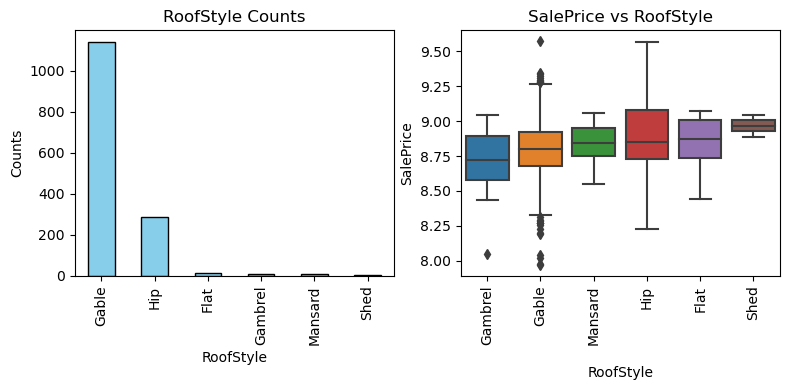

In [130]:
plotCategorical(train_sel, var, 'SalePrice')

Considering most of the houses are classified as 'Gable' we can map to new categories: 
|New Category|Old Category|
|:-----------:|:-----------|
|Hip|Hip|
|Gable|Gable|
|Othr|Gambrel, Mansard, Flat, Shed|

In [131]:
mapping = {'Gambrel':'Othr', 'Mansard':'Othr', 'Flat':'Othr', 'Shed':'Othr'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

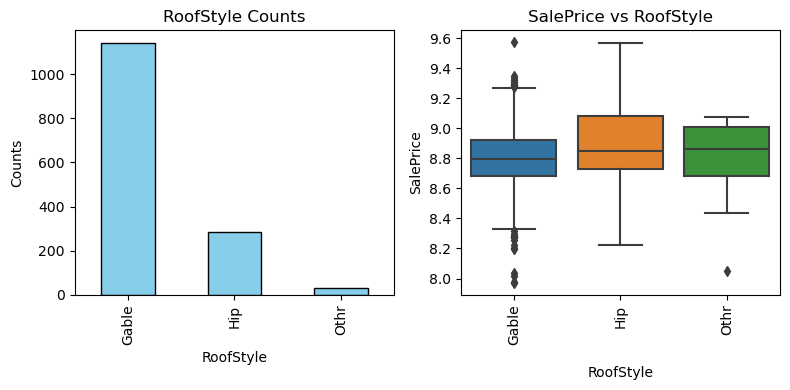

In [132]:
plotCategorical(train_sel, var, 'SalePrice')

#### RoofMatl

Roof material (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|ClyTile|Clay or Tile|
|CompShg|Standard (Composite) Shingle|
|Membran|Membrane|
|Metal|Metal|
|Roll|Roll|
|Tar&Grv|Gravel & Tar|
|WdShake|Wood Shakes|
|WdShngl|Wood Shingles|

In [133]:
var = 'RoofMatl'
train_sel[var].describe()

count        1460
unique          8
top       CompShg
freq         1434
Name: RoofMatl, dtype: object

*RoofMatl* doesn't provide important information as 1434/1460 houses are classified as 'CompShg'.

#### Exterior1st

Exterior covering on house (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|AsbShng|Asbestos Shingles|
|AsphShn|Asphalt Shingles|
|BrkComm|Brick Common|
|BrkFace|Brick Face|
|CBlock|Cinder Block|
|CemntBd|Cement Board|
|HdBoard|Hard Board|
|ImStucc|Imitation Stucco|
|MetalSd|Metal Siding|
|Other|Other|
|Plywood|Plywood|
|PreCast|PreCast|
|Stone|Stone|
|Stucco|Stucco|
|VinylSd|Vinyl Siding|
|Wd Sdng|Wood Siding|
|WdShing|Wood Shingles|

In [134]:
var = 'Exterior1st'
train_sel[var].describe()

count        1460
unique         15
top       VinylSd
freq          515
Name: Exterior1st, dtype: object

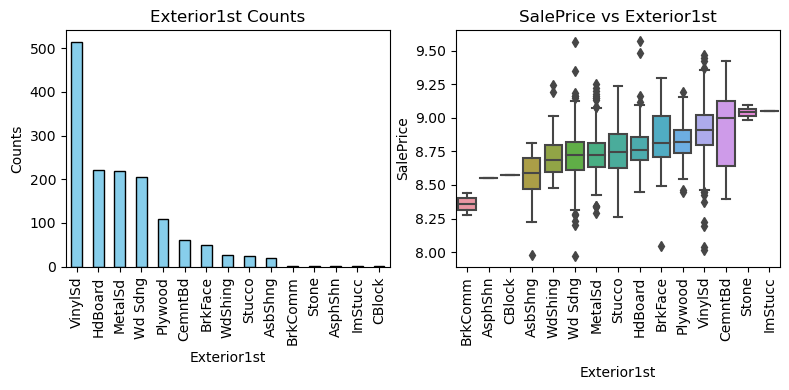

In [135]:
plotCategorical(train_sel, var, 'SalePrice')

We can map to new categories: 
|New Category|Old Category|
|:-----------:|:-----------|
|VinylSd|VinylSd|
|HdBoard|HdBoard|
|MetalSd|MetalSd|
|Wd Sdng|Wd Sdng|
|Othr|Other, BrkComm, Stone, AsphShn, AsbShng, BrkFace, CBlock, CemntBd, ImStucc, Stucco, WdShing|

In [136]:
mapping = {'Other':'Othr', 'BrkComm':'Othr', 'Stone':'Othr', 'AsphShn':'Othr', 'AsbShng':'Othr', 'BrkFace':'Othr', 
           'CBlock':'Othr', 'CemntBd':'Othr', 'ImStucc':'Othr', 'Stucco':'Othr', 'WdShing':'Othr'
          }
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

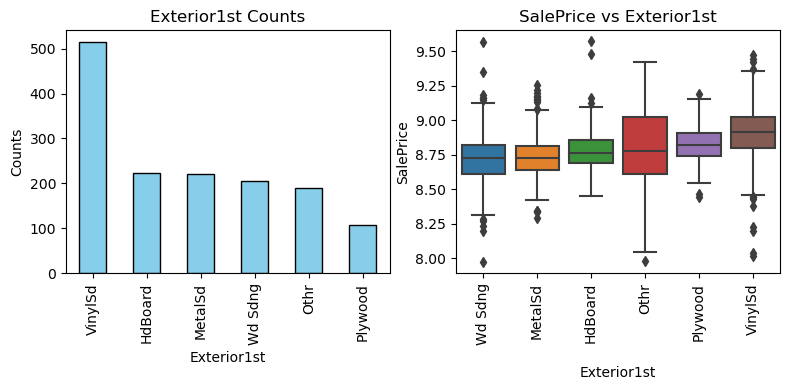

In [137]:
plotCategorical(train_sel, var, 'SalePrice')

#### Exterior2nd

Exterior covering on house (if more than one material) (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|AsbShng|Asbestos Shingles|
|AsphShn|Asphalt Shingles|
|BrkComm|Brick Common|
|BrkFace|Brick Face|
|CBlock|Cinder Block|
|CemntBd|Cement Board|
|HdBoard|Hard Board|
|ImStucc|Imitation Stucco|
|MetalSd|Metal Siding|
|Other|Other|
|Plywood|Plywood|
|PreCast|PreCast|
|Stone|Stone|
|Stucco|Stucco|
|VinylSd|Vinyl Siding|
|Wd Sdng|Wood Siding|
|WdShing|Wood Shingles|

In [138]:
var = 'Exterior2nd'
train_sel[var].describe()

count        1460
unique         16
top       VinylSd
freq          504
Name: Exterior2nd, dtype: object

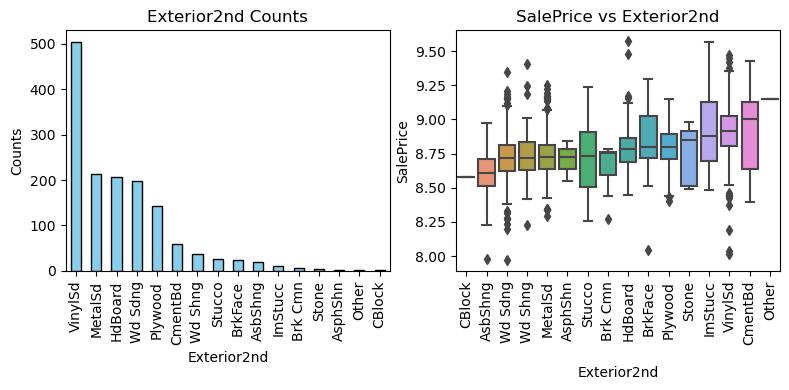

In [139]:
plotCategorical(train_sel, var, 'SalePrice')

We can map to new categories: 
|New Category|Old Category|
|:-----------:|:-----------|
|VinylSd|VinylSd|
|HdBoard|HdBoard|
|MetalSd|MetalSd|
|Wd Sdng|Wd Sdng|
|Othr|Other, BrkComm, Stone, AsphShn, AsbShng, BrkFace, CBlock, CemntBd, ImStucc, Stucco, WdShing|

In [140]:
mapping = {'Other':'Othr', 'Brk Cmn':'Othr', 'Stone':'Othr', 'AsphShn':'Othr', 'AsbShng':'Othr', 'BrkFace':'Othr', 
           'CBlock':'Othr', 'CmentBd':'Othr', 'ImStucc':'Othr', 'Stucco':'Othr', 'Wd Shng':'Othr'
          }
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

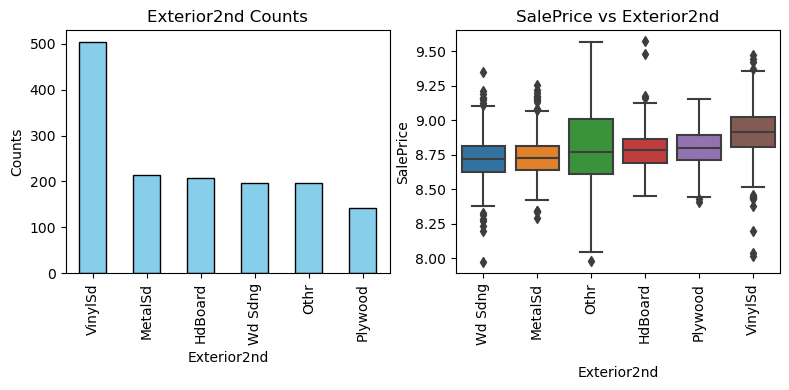

In [141]:
plotCategorical(train_sel, var, 'SalePrice')

#### MasVnrType

Masonry veneer type (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|BrkCmn|Brick Common|
|BrkFace|Brick Face|
|CBlock|Cinder Block|
|None|None|
|Stone|Stone|

In [142]:
var = 'MasVnrType'
train_sel[var].describe()

count     1460
unique       4
top       None
freq       872
Name: MasVnrType, dtype: object

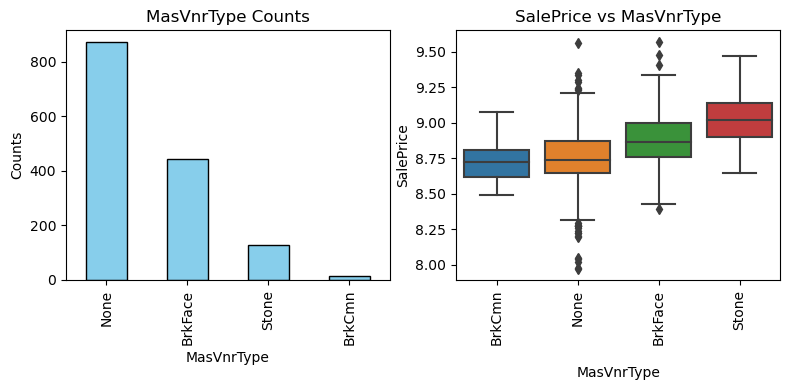

In [143]:
plotCategorical(train_sel, var, 'SalePrice')

#### Foundation

Type of foundation (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|BrkTil|Brick & Tile|
|CBlock|Cinder Block|
|PConc|Poured Contrete|
|Slab|Slab|
|Stone|Stone|
|Wood|Wood|

In [144]:
var = 'Foundation'
train_sel[var].describe()

count      1460
unique        6
top       PConc
freq        647
Name: Foundation, dtype: object

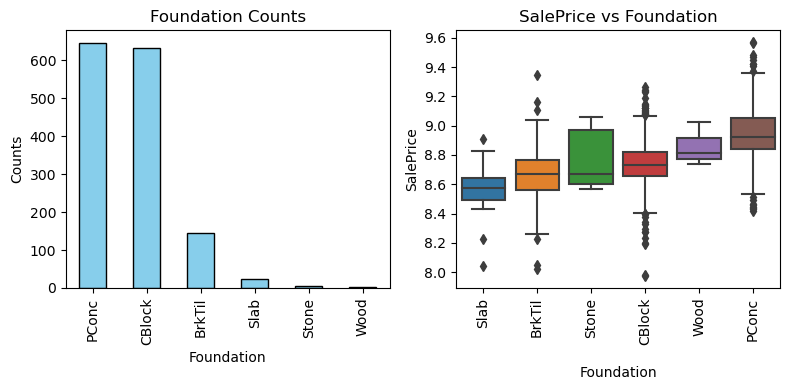

In [145]:
plotCategorical(train_sel, var, 'SalePrice')

#### Heating

Type of heating (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|Floor|Floor Furnace|
|GasA|Gas forced warm air furnace|
|GasW|Gas hot water or steam heat|
|Grav|Gravity furnace|
|OthW|Hot water or steam heat other than gas|
|Wall|Wall furnace|

In [146]:
var = 'Heating'
train_sel[var].describe()

count     1460
unique       6
top       GasA
freq      1428
Name: Heating, dtype: object

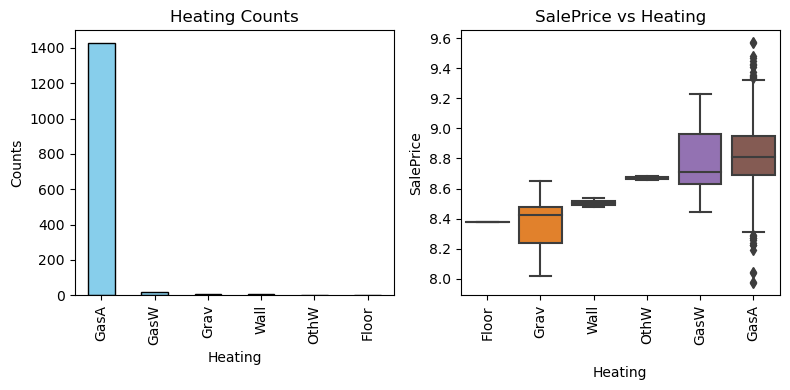

In [147]:
plotCategorical(train_sel, var, 'SalePrice')

*Heating* doesn't offer significant meaningful data.

#### GarageType

Garage location (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|2Types|More than one type of garage|
|Attchd|Attached to home|
|Basment|Basement Garage|
|BuiltIn|Built-In (Garage part of house - typically has room above garage)|
|CarPort|Car Port|
|Detchd|Detached from home|
|NA|No Garage|

In [148]:
var = 'GarageType'
train_sel[var].describe()

count       1460
unique         7
top       Attchd
freq         870
Name: GarageType, dtype: object

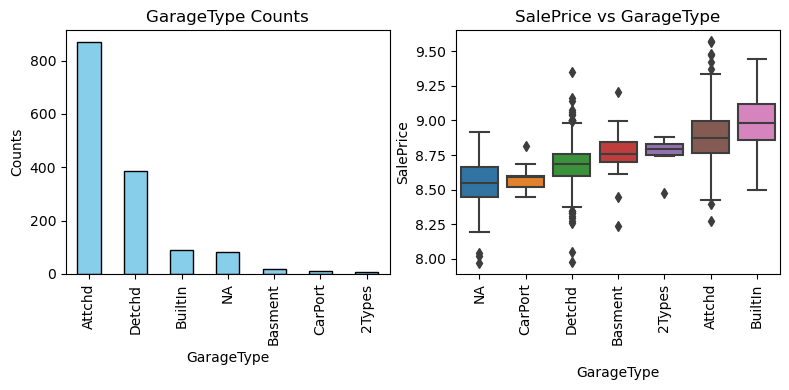

In [149]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|Attchd|Attchd|
|Detchd|Detchd|
|NA|NA, CarPort|
|BuiltIn|BuiltIn|
|Othr|Basment, 2Types|

In [150]:
mapping = {'CarPort':'NA', 
           'Basment':'Othr', '2Types':'Othr'
          }
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

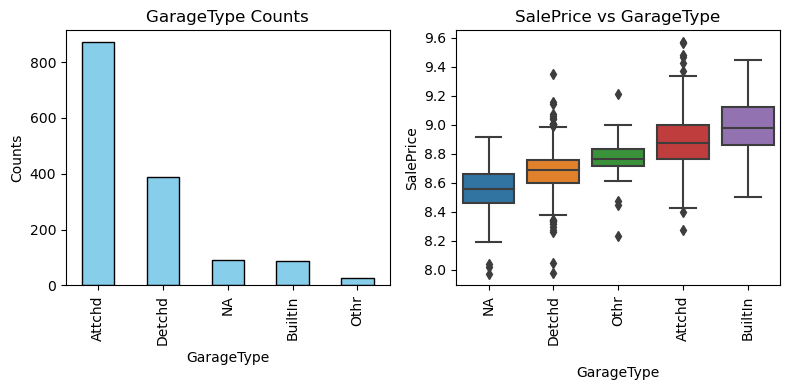

In [151]:
plotCategorical(train_sel, var, 'SalePrice')

#### SaleType

Type of sale (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|WD|Warranty Deed - Conventional|
|CWD|Warranty Deed - Cash|
|VWD|Warranty Deed - VA Loan|
|New|Home just constructed and sold|
|COD|Court Officer Deed/Estate|
|Con|Contract 15% Down payment regular terms|
|ConLw|Contract Low Down payment and low interest|
|ConLI|Contract Low Interest|
|ConLD|Contract Low Down|
|Oth|Other|

In [152]:
var = 'SaleType'
train_sel[var].describe()

count     1460
unique       9
top         WD
freq      1267
Name: SaleType, dtype: object

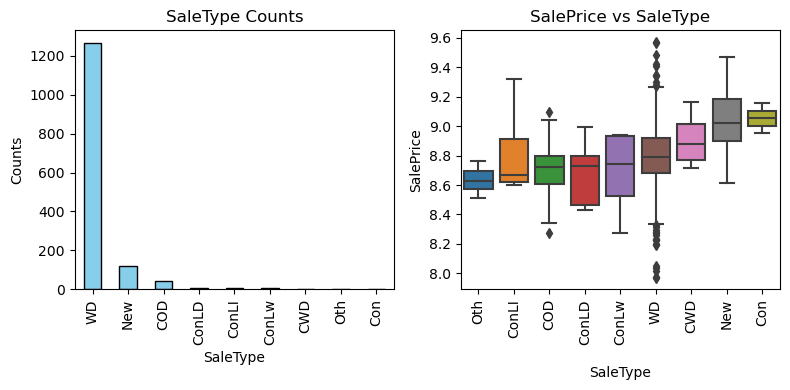

In [153]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|WD|WD|
|New|New|
|Oth|COD, ConLD, ConLI, ConLW, CWD, Oth, Con|

In [154]:
mapping = {'COD':'Othr', 'ConLD':'Othr', 'ConLI':'Othr', 
           'ConLW':'Othr', 'CWD':'Othr', 'Oth':'Othr', 'Con':'Othr'
          }
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

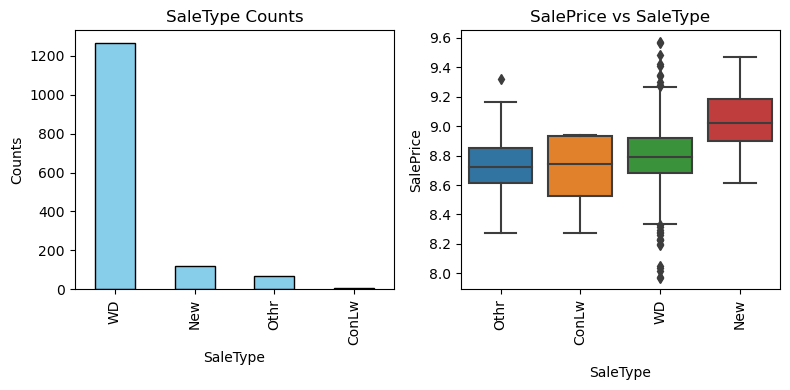

In [155]:
plotCategorical(train_sel, var, 'SalePrice')

#### SaleCondition

Condition of sale (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|Normal|Normal Sale|
|Abnorml|Abnormal Sale -  trade, foreclosure, short sale|
|AdjLand|Adjoining Land Purchase|
|Alloca|Allocation - 2 linked properties w/ separate deeds, typically condo with a garage unit|
|Family|Sale between family members|
|Partial|Home was not completed when last assessed (associated with New Homes)|

In [156]:
var = 'SaleCondition'
train_sel[var].describe()

count       1460
unique         6
top       Normal
freq        1198
Name: SaleCondition, dtype: object

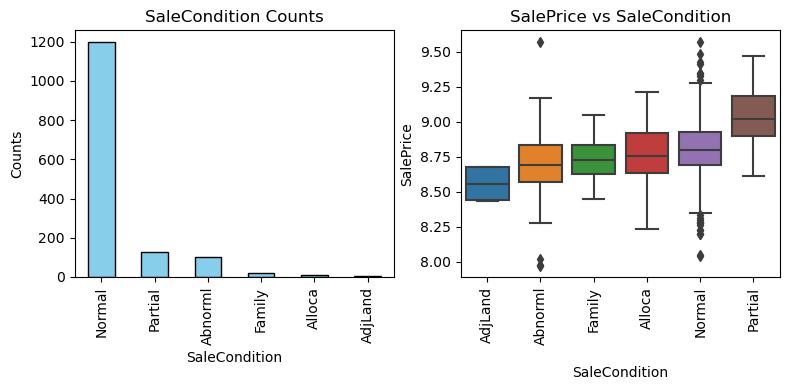

In [157]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|Normal|Normal|
|Partial|Partial|
|Oth|Abnorml, Family, Alloca, AdjLand|

In [158]:
mapping = {'Abnorml':'Othr', 'Family':'Othr', 'Alloca':'Othr', 'AdjLand':'Othr'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

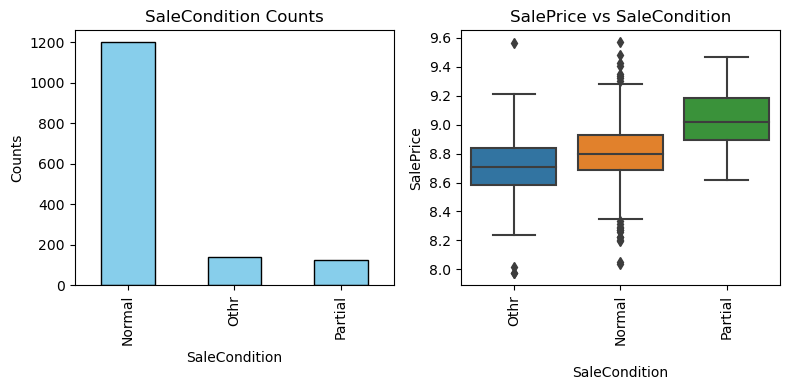

In [159]:
plotCategorical(train_sel, var, 'SalePrice')

#### LandSlope

Slope of property (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Gtl|Gentle slope|
|Mod|Moderate Slope|
|Sev|Severe Slope|

In [160]:
var = 'LandSlope'
train_sel[var].describe()

count     1460
unique       3
top        Gtl
freq      1382
Name: LandSlope, dtype: object

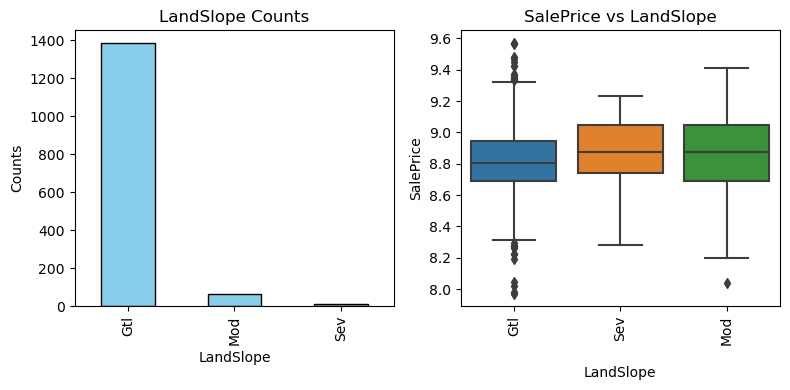

In [161]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|Gtl|Gtl|
|NGtl|Mod,Sev|

In [162]:
mapping = {'Mod':'NGtl', 'Sev':'NGtl'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

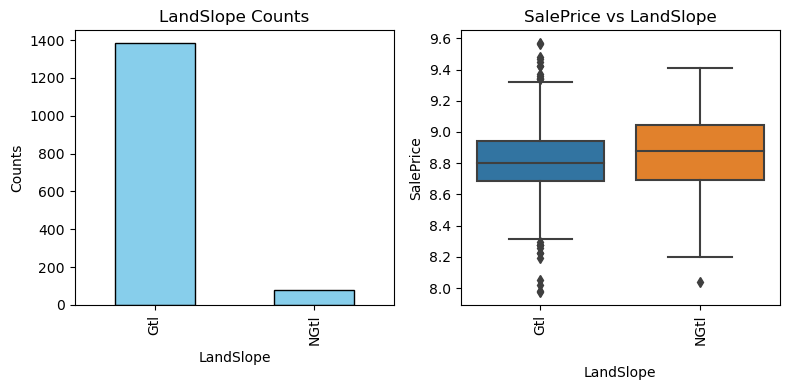

In [163]:
plotCategorical(train_sel, var, 'SalePrice')

#### MoSold

Month Sold (MM) (Categorical, nominal)

In [164]:
var = 'MoSold'
train_sel[var].describe()

count    1460.000000
mean        6.321918
std         2.703626
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|Jan|1|
|Feb|2|
|Mar|3|
|Apr|4|
|May|5|
|Jun|6|
|Jul|7|
|Ago|8|
|Sep|9|
|Oct|10|
|Nov|11|
|Dec|12|

In [165]:
mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
          8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

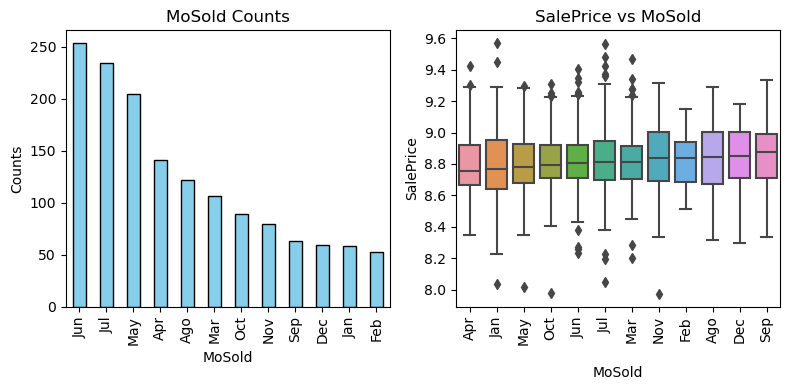

In [166]:
plotCategorical(train_sel, var, 'SalePrice')

Hot weather is good for sales! But it doesn't seem that there is a correlation between *MoSold* and the price.

#### LotShape

General shape of property (Categorical, nominal)
|Category|Description|
|:----------:|:-------------|
|Reg|Regular|
|IR1|Slightly irregular|
|IR2|Moderately Irregular|
|IR3|Irregular|

In [167]:
var = 'LotShape'
train_sel[var].describe()

count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

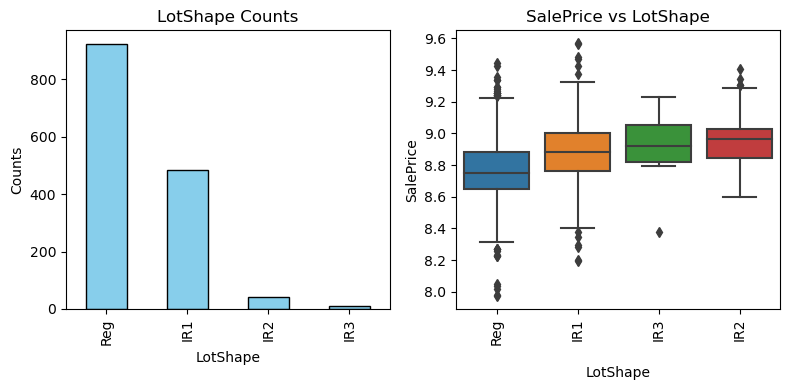

In [168]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|Reg|Reg|
|Irreg|IR1,IR2,IR3|

In [169]:
mapping = {'IR1':'Irreg', 'IR2':'Irreg', 'IR3':'Irreg'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

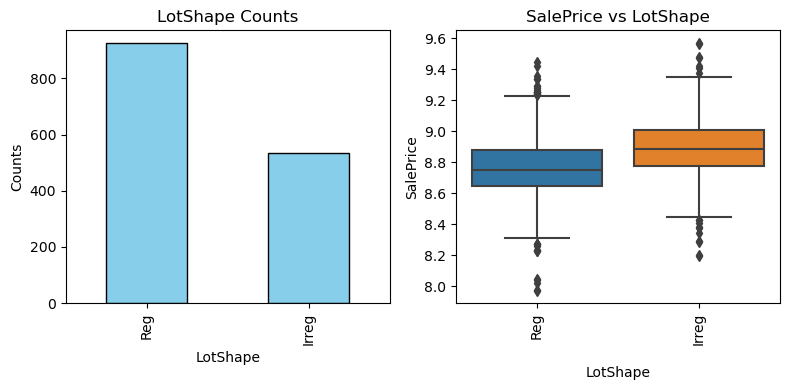

In [170]:
plotCategorical(train_sel, var, 'SalePrice')

#### LandContour

Flatness of the property (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Lvl|Near Flat/Level|
|Bnk|Banked - Quick and significant rise from street grade to building|
|HLS|Hillside - Significant slope from side to side|
|Low|Depression|

In [171]:
var = 'LandContour'
train_sel[var].describe()

count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

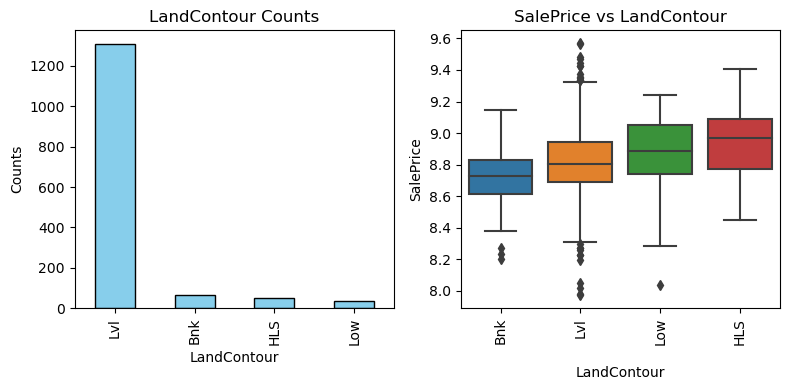

In [172]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|Lvl|Lvl|
|Irreg|Bnk,HLS,Low|

In [173]:
mapping = {'Bnk':'Irreg','HLS':'Irreg','Low':'Irreg'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

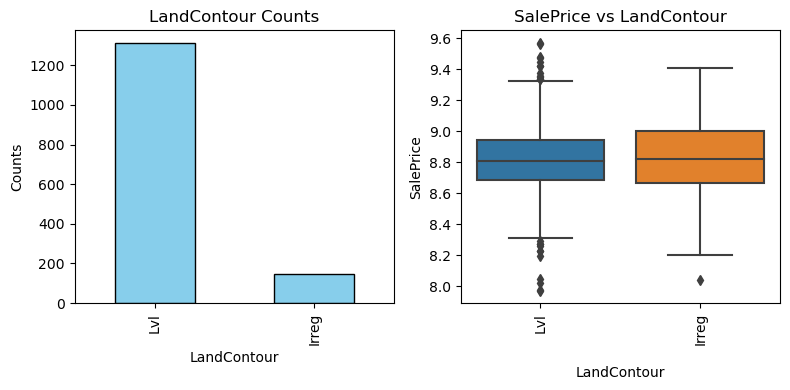

In [174]:
plotCategorical(train_sel, var, 'SalePrice')

### Categorical, ordinal explanatory variables

As we did before, some ordinal variables will need mapping their categories into new ones. Then, label encoding will be required.

#### Street

Type of road access to property (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Grvl|Gravel|
|Pave|Paved|

In [175]:
var = 'Street'
train_sel[var].describe()

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

*Street* doesn't provide important information as 1454/1460 houses are classified as 'Pave'.

#### PavedDrive

Paved driveway (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Y|Paved|
|P|Partial Pavement|
|N|Dirt/Gravel|

In [176]:
var = 'PavedDrive'
train_sel[var].describe()

count     1460
unique       3
top          Y
freq      1340
Name: PavedDrive, dtype: object

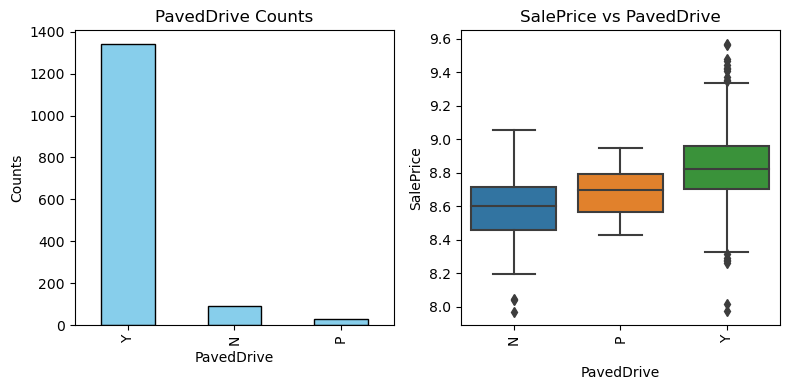

In [177]:
plotCategorical(train_sel, var, 'SalePrice')

We can map like this:

|New Category|Old Category|
|:-----------:|:-----------|
|N|P,N|
|Y|Y|

In [178]:
mapping = {'P':'N'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

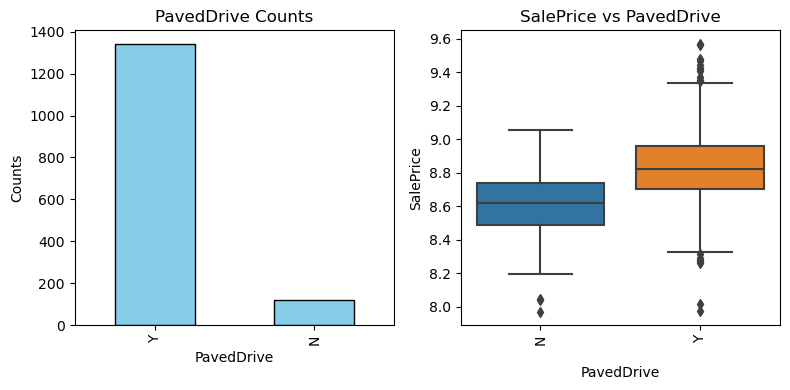

In [179]:
plotCategorical(train_sel, var, 'SalePrice')

In [180]:
encoder = OrdinalEncoder(categories=[["N", "Y"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### Utilities

Type of utilities available (Categorical, ordinal)
|Category|Description   |
|:---|:---|
|AllPub|All public Utilities (E,G,W,& S)|
|NoSewr|Electricity, Gas, and Water (Septic Tank)|
|NoSeWa|Electricity and Gas Only|
|ELO|Electricity only|

In [181]:
var = 'Utilities'
train_sel[var].describe()

count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

*Utilities* doesn't provide important information as 1459/1460 houses are classified as 'AllPub'.

#### Electrical

Electrical system (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|SBrkr|Standard Circuit Breakers & Romex|
|FuseA|Fuse Box over 60 AMP and all Romex wiring (Average)|
|FuseF|60 AMP Fuse Box and mostly Romex wiring (Fair)|
|FuseP|60 AMP Fuse Box and mostly knob & tube wiring (poor)|
|Mix|Mixed|

In [182]:
var = 'Electrical'
train_sel[var].describe()

count      1460
unique        5
top       SBrkr
freq       1335
Name: Electrical, dtype: object

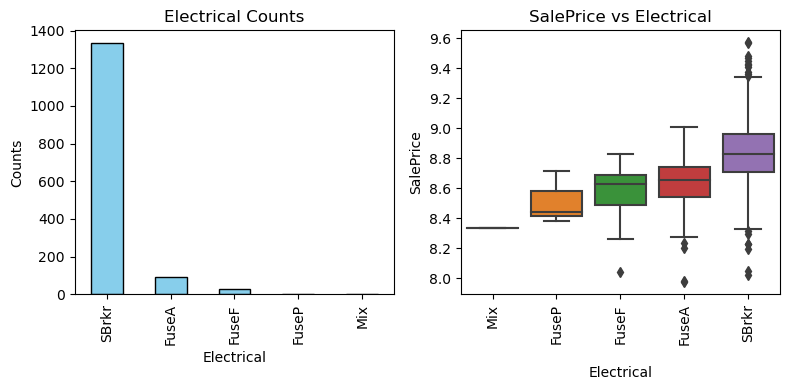

In [183]:
plotCategorical(train_sel, var, 'SalePrice')

We map:
We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|SBrkr|SBrkr|
|FuseA|FuseA|
|Oth|Mix, FuseP, FuseF|

In [184]:
mapping = {'Mix':'Othr', 'FuseP':'Othr', 'FuseF':'Othr'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

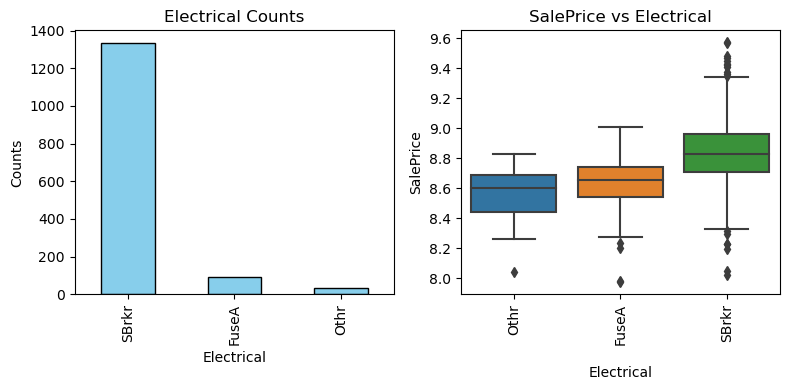

In [185]:
plotCategorical(train_sel, var, 'SalePrice')

In [186]:
encoder = OrdinalEncoder(categories=[["Othr","FuseA","SBrkr"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### Functional

Home functionality (Assume typical unless deductions are warranted) (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Typ|Typical Functionality|
|Min1|Minor Deductions 1|
|Min2|Minor Deductions 2|
|Mod|Moderate Deductions|
|Maj1|Major Deductions 1|
|Maj2|Major Deductions 2|
|Sev|Severely Damaged|
|Sal|Salvage only|

In [187]:
var = 'Functional'
train_sel[var].describe()

count     1460
unique       7
top        Typ
freq      1360
Name: Functional, dtype: object

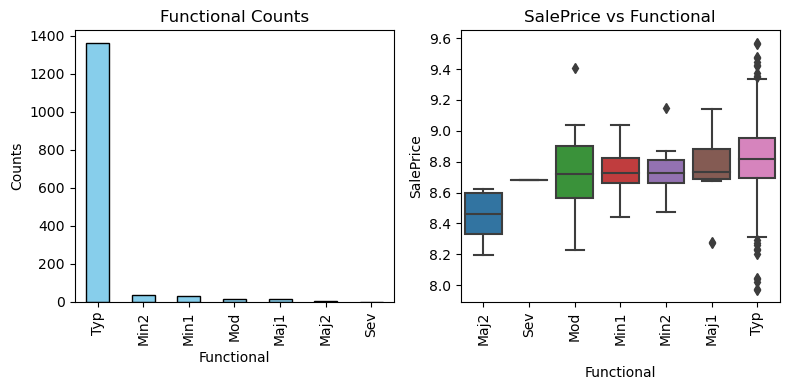

In [188]:
plotCategorical(train_sel, var, 'SalePrice')

*Functional* doesn't provide important information as 1360/1460 houses are classified as 'Typ' and other categories don't have a logical correlation with the price.

#### FireplaceQu

Fireplace quality (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent - Exceptional Masonry Fireplace|
|Gd|Good - Masonry Fireplace in main level|
|TA|Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement|
|Fa|Fair - Prefabricated Fireplace in basement|
|NA|No Fireplace|

In [189]:
var = 'FireplaceQu'
train_sel[var].describe()

count     1460
unique       6
top         NA
freq       690
Name: FireplaceQu, dtype: object

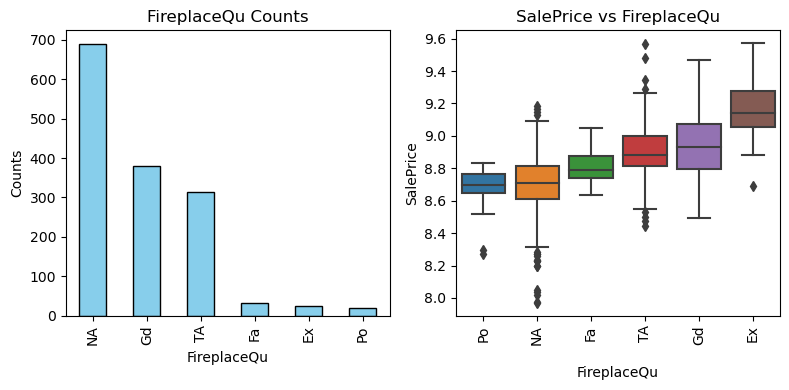

In [190]:
plotCategorical(train_sel, var, 'SalePrice')

In [191]:
encoder = OrdinalEncoder(categories=[["Po","NA", "Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### CentralAir

Central air conditioning (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------:|
|N|No|
|Y|Yes|

In [192]:
var = 'CentralAir'
train_sel[var].describe()

count     1460
unique       2
top          Y
freq      1365
Name: CentralAir, dtype: object

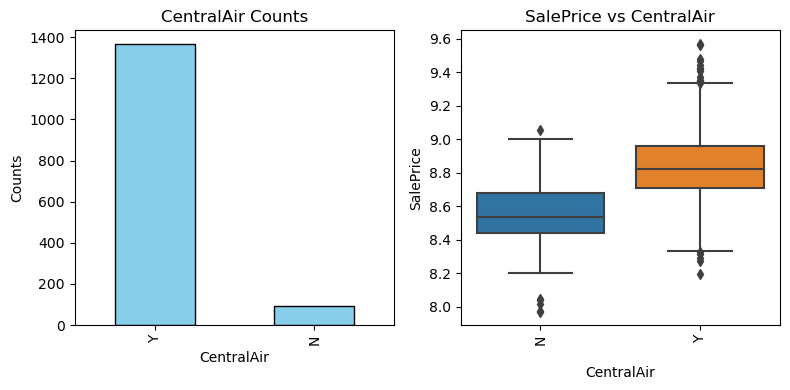

In [193]:
plotCategorical(train_sel, var, 'SalePrice')

In [194]:
encoder = OrdinalEncoder(categories=[["N", "Y"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### HeatingQC

Heating quality and condition (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|Po|Poor|

In [195]:
var = 'HeatingQC'
train_sel[var].describe()

count     1460
unique       5
top         Ex
freq       741
Name: HeatingQC, dtype: object

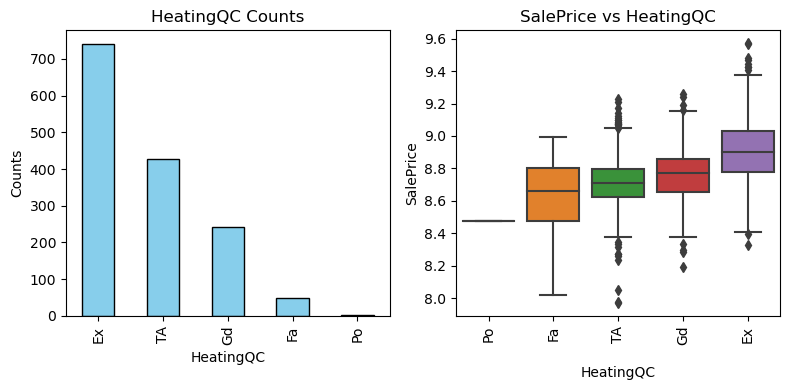

In [196]:
plotCategorical(train_sel, var, 'SalePrice')

In [197]:
encoder = OrdinalEncoder(categories=[["Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### KitchenQual

Kitchen quality (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|Po|Poor|

In [198]:
var = 'KitchenQual'
train_sel[var].describe()

count     1460
unique       4
top         TA
freq       735
Name: KitchenQual, dtype: object

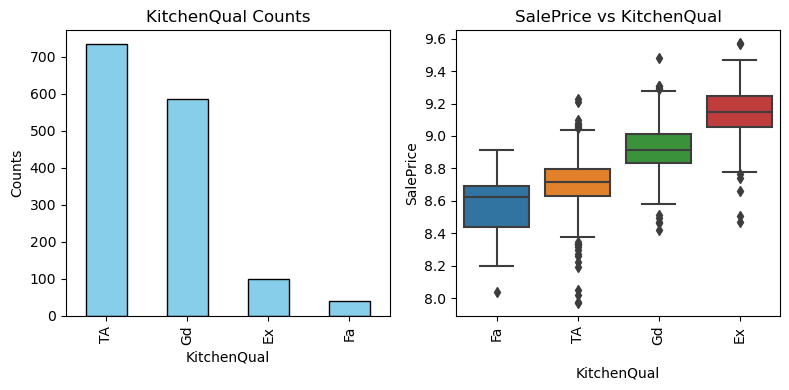

In [199]:
plotCategorical(train_sel, var, 'SalePrice')

In [200]:
encoder = OrdinalEncoder(categories=[["Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### ExterQual

Evaluates the quality of the material on the exterior (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|Po|Poor|

In [201]:
var = 'ExterQual'
train_sel[var].describe()

count     1460
unique       4
top         TA
freq       906
Name: ExterQual, dtype: object

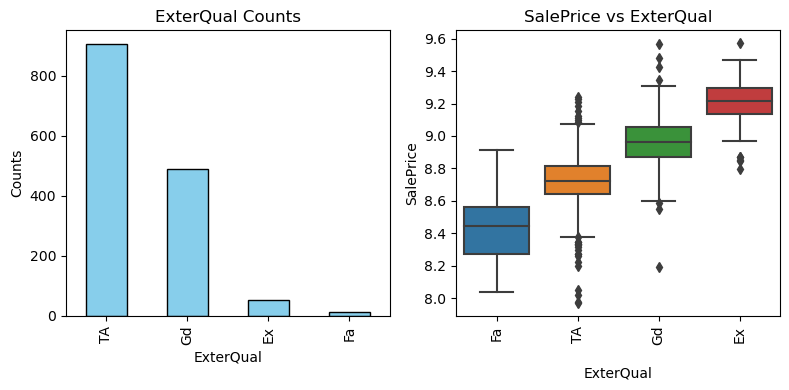

In [202]:
plotCategorical(train_sel, var, 'SalePrice')

In [203]:
encoder = OrdinalEncoder(categories=[["Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### ExterCond

Evaluates the present condition of the material on the exterior (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|Po|Poor|

In [204]:
var = 'ExterCond'
train_sel[var].describe()

count     1460
unique       5
top         TA
freq      1282
Name: ExterCond, dtype: object

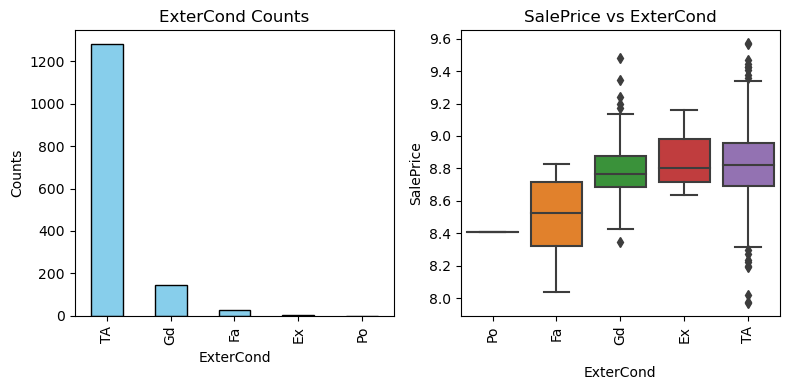

In [205]:
plotCategorical(train_sel, var, 'SalePrice')

In [206]:
encoder = OrdinalEncoder(categories=[["Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### GarageFinish

Interior finish of the garage (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Fin|Finished|
|RFn|Rough Finished|
|Unf|Unfinished|
|NA|No Garage|

In [207]:
var = 'GarageFinish'
train_sel[var].describe()

count     1460
unique       4
top        Unf
freq       605
Name: GarageFinish, dtype: object

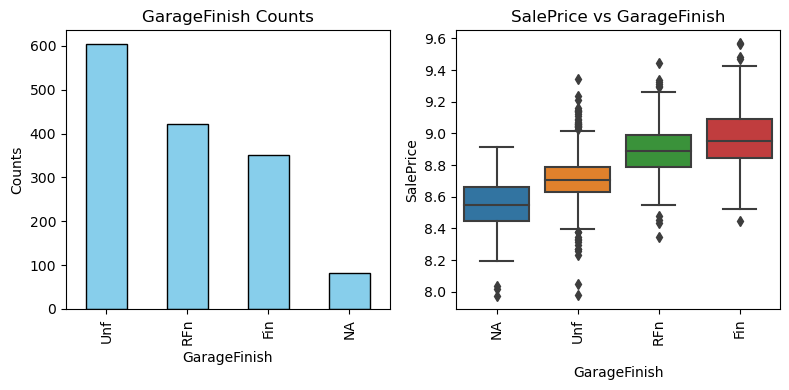

In [208]:
plotCategorical(train_sel, var, 'SalePrice')

In [209]:
encoder = OrdinalEncoder(categories=[["NA","Unf","RFn","Fin"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### GarageQual

Garage quality (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|Po|Poor|
|NA|No Garage|

In [210]:
var = 'GarageQual'
train_sel[var].describe()

count     1460
unique       6
top         TA
freq      1311
Name: GarageQual, dtype: object

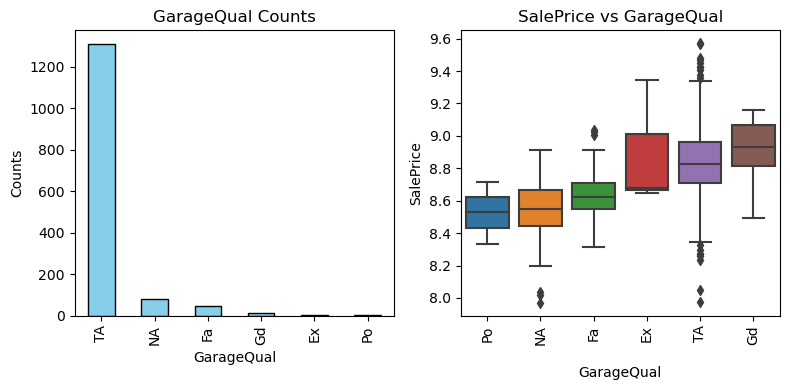

In [211]:
plotCategorical(train_sel, var, 'SalePrice')

In [212]:
encoder = OrdinalEncoder(categories=[["NA","Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### GarageCond

Garage condition (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|Po|Poor|
|NA|No Garage|

In [213]:
var = 'GarageCond'
train_sel[var].describe()

count     1460
unique       6
top         TA
freq      1326
Name: GarageCond, dtype: object

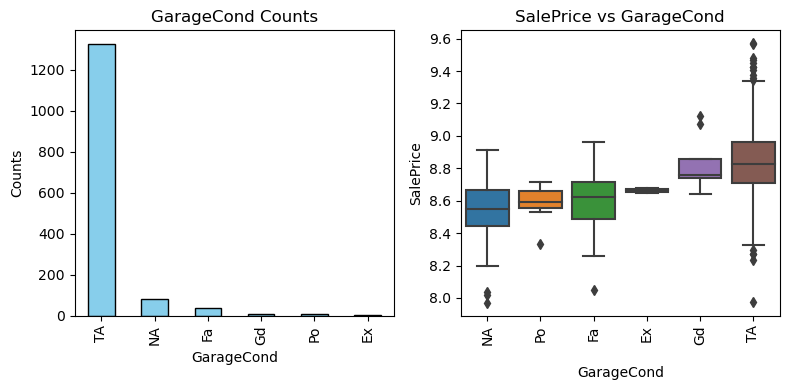

In [214]:
plotCategorical(train_sel, var, 'SalePrice')

In [215]:
encoder = OrdinalEncoder(categories=[["NA","Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### BsmtQual

Evaluates the height of the basement (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent (100+ inches)|
|Gd|Good (90-99 inches)|
|TA|Typical (80-89 inches)|
|Fa|Fair (70-79 inches)|
|Po|Poor (<70 inches)|
|NA|No Basement|

In [216]:
var = 'BsmtQual'
train_sel[var].describe()

count     1460
unique       5
top         TA
freq       649
Name: BsmtQual, dtype: object

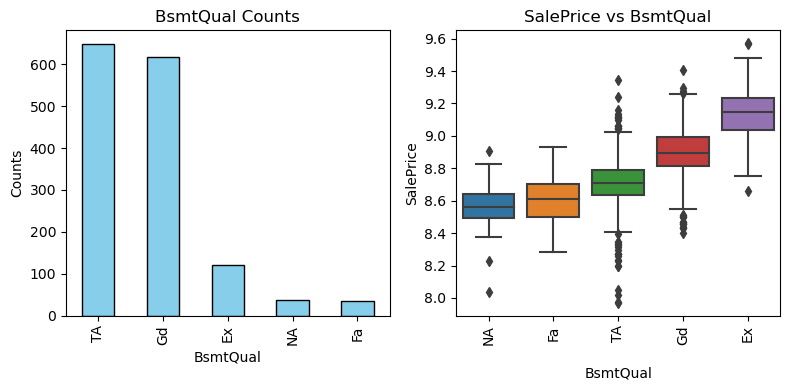

In [217]:
plotCategorical(train_sel, var, 'SalePrice')

In [218]:
encoder = OrdinalEncoder(categories=[["NA","Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### BsmtCond

Evaluates the general condition of the basement (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Typical - slight dampness allowed|
|Fa|Fair - dampness or some cracking or settling|
|Po|Poor - Severe cracking, settling, or wetness|
|NA|No Basement|

In [219]:
var = 'BsmtCond'
train_sel[var].describe()

count     1460
unique       5
top         TA
freq      1311
Name: BsmtCond, dtype: object

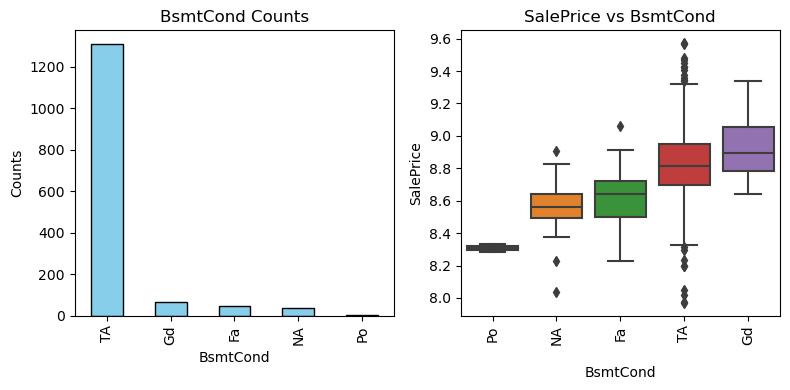

In [220]:
plotCategorical(train_sel, var, 'SalePrice')

In [221]:
encoder = OrdinalEncoder(categories=[["NA","Po","Fa","TA","Gd","Ex"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### BsmtExposure

Refers to walkout or garden level walls (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Gd|Good Exposure|
|Av|Average Exposure (split levels or foyers typically score average or above)|
|Mn|Mimimum Exposure|
|No|No Exposure|
|NA|No Basement|

In [222]:
var = 'BsmtExposure'
train_sel[var].describe()

count     1460
unique       5
top         No
freq       954
Name: BsmtExposure, dtype: object

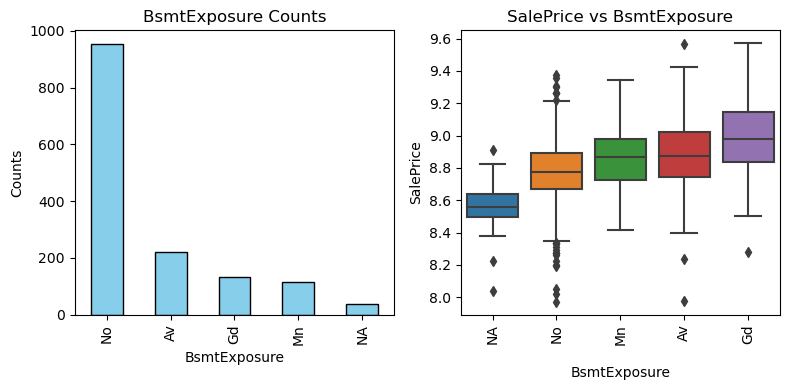

In [223]:
plotCategorical(train_sel, var, 'SalePrice')

In [224]:
encoder = OrdinalEncoder(categories=[["NA","No", "Mn","Av","Gd"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### BsmtFinType1

Rating of basement finished area (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|GLQ|Good Living Quarters|
|ALQ|Average Living Quarters|
|BLQ|Below Average Living Quarters|	
|Rec|Average Rec Room|
|LwQ|Low Quality|
|Unf|Unfinshed|
|NA|No Basement|

In [225]:
var = 'BsmtFinType1'
train_sel[var].describe()

count     1460
unique       7
top        Unf
freq       430
Name: BsmtFinType1, dtype: object

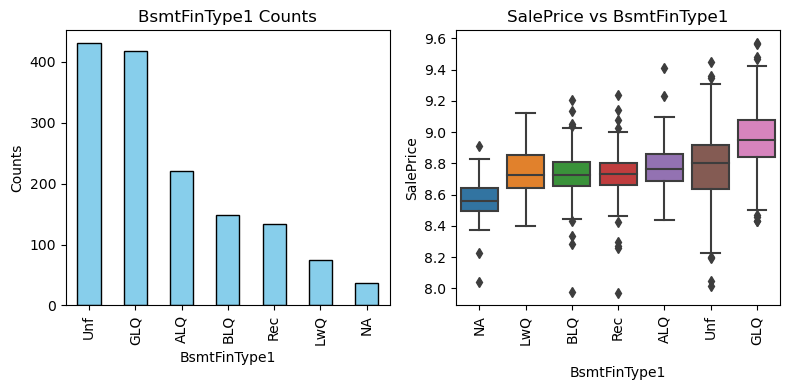

In [226]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|GLQ|GLQ|
|Unf|Unf|
|ALQ|ALQ|
|Othr|LwQ, BLQ, Rec|
|NA|NA|

In [227]:
mapping = {'LwQ': 'Othr', 'BLQ': 'Othr', 'Rec': 'Othr'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

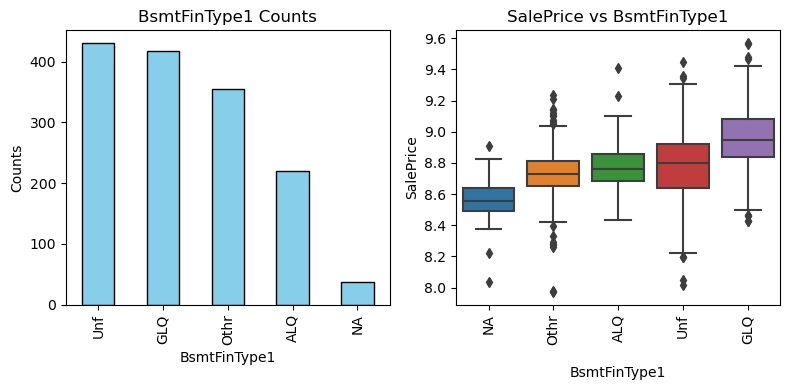

In [228]:
plotCategorical(train_sel, var, 'SalePrice')

In [229]:
encoder = OrdinalEncoder(categories=[["NA","Othr","ALQ","Unf","GLQ"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### BsmtFinType2

Rating of basement finished area (if multiple types) (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|GLQ|Good Living Quarters|
|ALQ|Average Living Quarters|
|BLQ|Below Average Living Quarters|	
|Rec|Average Rec Room|
|LwQ|Low Quality|
|Unf|Unfinished|
|NA|No Basement|

In [230]:
var = 'BsmtFinType2'
train_sel[var].describe()

count     1460
unique       7
top        Unf
freq      1257
Name: BsmtFinType2, dtype: object

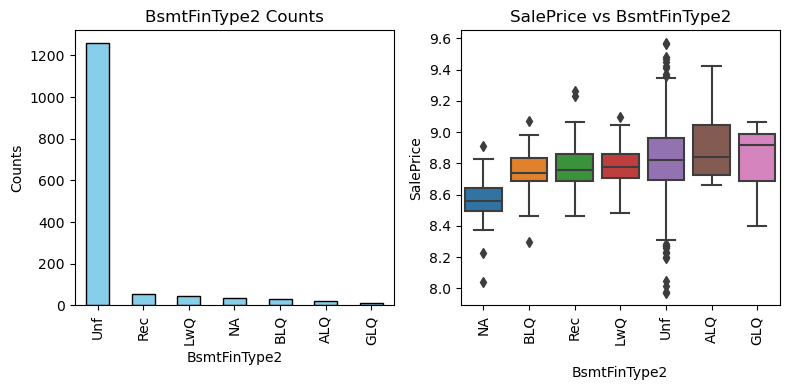

In [231]:
plotCategorical(train_sel, var, 'SalePrice')

We are going to map:
|New Category|Old Category|
|:-----------:|:-----------|
|GLQ|GLQ|
|Unf|Unf|
|ALQ|ALQ|
|Othr|LwQ, BLQ, Rec|
|NA|NA|

In [232]:
mapping = {'LwQ': 'Othr', 'BLQ': 'Othr', 'Rec': 'Othr'}
train_sel[var] = train_sel[var].replace(mapping)
test_sel[var] = test_sel[var].replace(mapping)

In [233]:
encoder = OrdinalEncoder(categories=[["NA","Othr","ALQ","Unf","GLQ"]]) # categories in order from worse to best
encoder.fit(train_sel[[var]])
train_sel[var+'-encoded'] = encoder.transform(train_sel[[var]])
encoder.fit(test_sel[[var]])
test_sel[var+'-encoded'] = encoder.transform(test_sel[[var]])

#### PoolQC

Pool quality (Categorical, ordinal)
|Category|Description|
|:----------:|:-------------|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|NA|No Pool|

In [234]:
var = 'PoolQC'
train_sel[var].describe()

count     1460
unique       4
top         NA
freq      1453
Name: PoolQC, dtype: object

This variable doesn't provide us with significant information.

### Numerical, discrete explanatory variables

#### YearBuilt

Original construction date (Numerical, discrete)

In [235]:
var = 'YearBuilt'
train_sel[var].describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

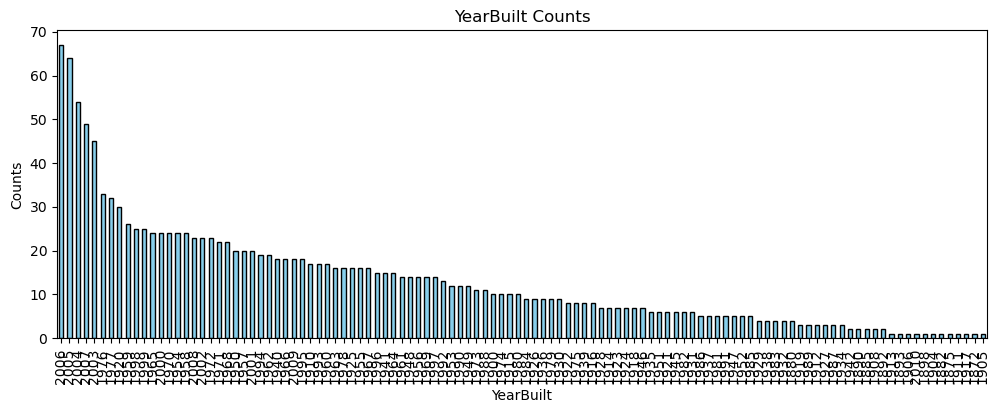

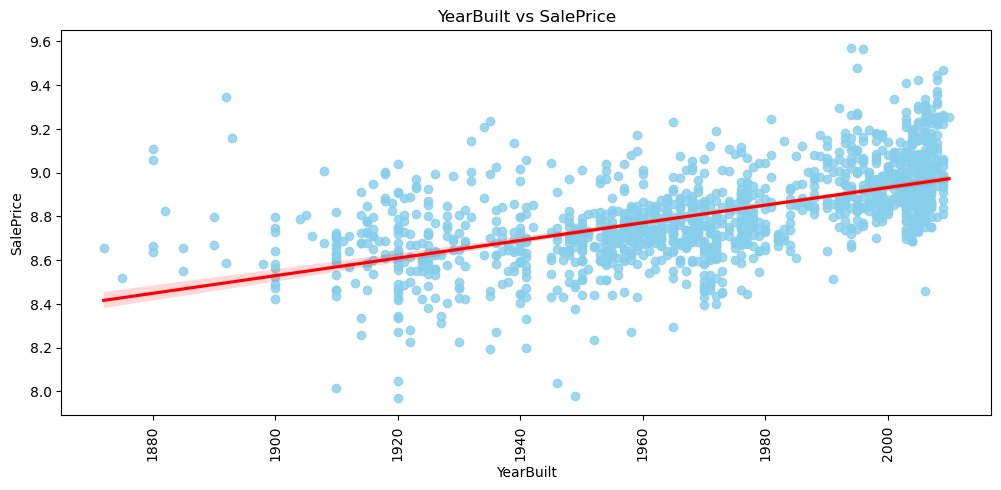

In [236]:
plt.figure(figsize=(12, 4))


train_sel[var].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(var+' Counts', fontsize=12)
plt.xlabel(var, fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.show()

plt.figure(figsize=(12, 5))

sns.regplot(x=var, 
            y='SalePrice', 
            data=train_sel, 
            scatter=True, 
            line_kws={'color': 'red'},
            scatter_kws={'color': 'skyblue'})
plt.title(var+' vs SalePrice', fontsize=12)
plt.xlabel(var, fontsize=10)
plt.ylabel('SalePrice', fontsize=10)
plt.tick_params(axis='x', labelrotation=90)

plt.show()

Newer houses tend to be more expensive. We should study a new variable that combined *YearBuilt* and *YearRemodAdd*. If age is important, *YrSold* should be considered. 

#### YearRemodAdd

Remodel date (same as construction date if no remodeling or additions) (Numerical, discrete)

In [237]:
var = 'YearRemodAdd'
train_sel[var].describe()

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

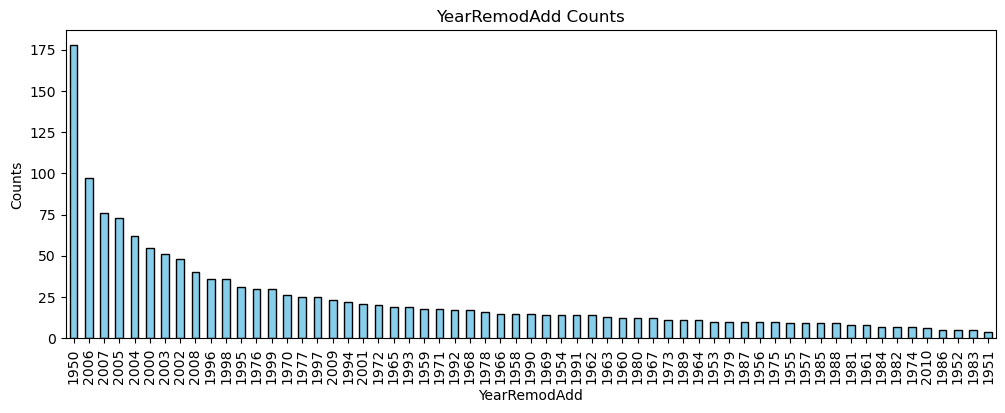

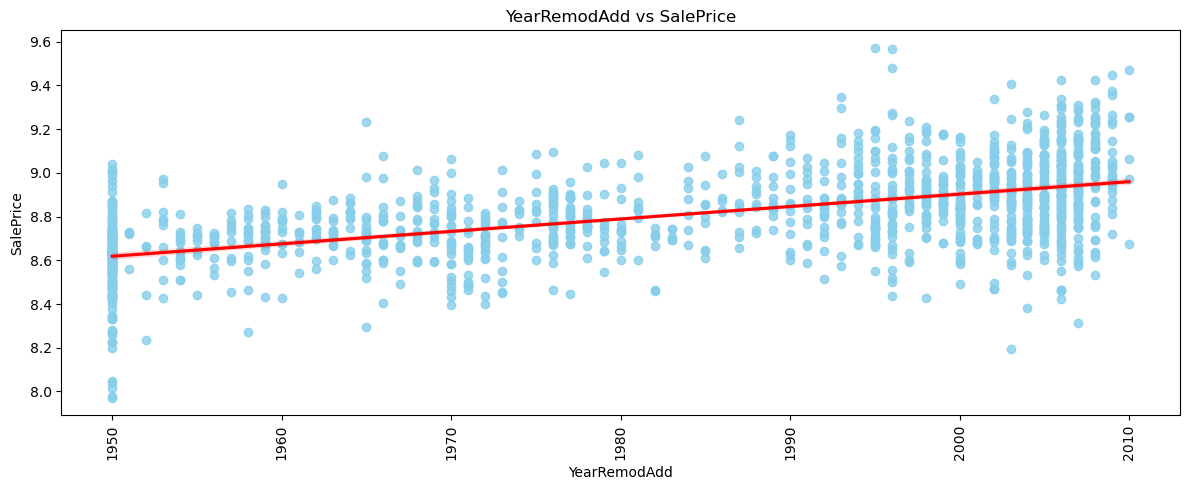

In [239]:
plt.figure(figsize=(12, 4))

train_sel[var].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(var+' Counts')
plt.xlabel(var)
plt.ylabel('Counts')
plt.show()

plt.figure(figsize=(12, 5))
sns.regplot(x=var, y='SalePrice', data=train_sel, scatter=True, line_kws={'color': 'red'}, scatter_kws={'color': 'skyblue'})
plt.title(var+' vs SalePrice', fontsize=12)
plt.xlabel(var, fontsize=10)
plt.ylabel('SalePrice', fontsize=10)
plt.tick_params(axis='x', labelrotation=90)

plt.tight_layout() 
plt.show()

#### GarageYrBlt

Year garage was built (Numerical, discrete)

In [240]:
var = 'GarageYrBlt'
train_sel[var].describe()

count    1460.000000
mean     1976.507534
std        26.306739
min      1872.000000
25%      1959.000000
50%      1978.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

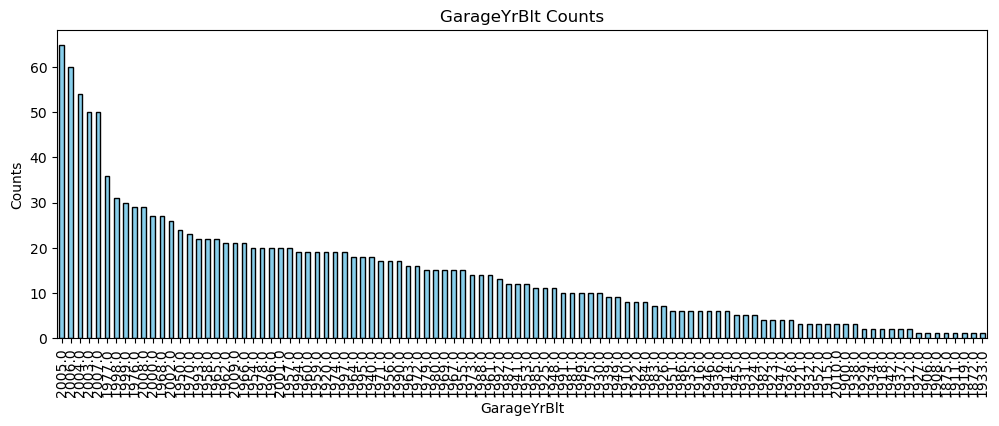

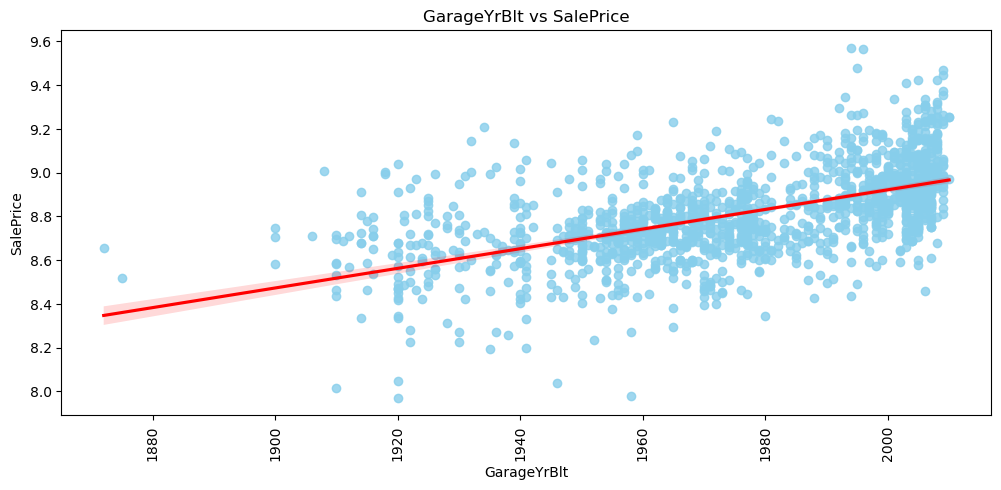

In [241]:
plt.figure(figsize=(12, 4))

train_sel[var].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(var+' Counts')
plt.xlabel(var)
plt.ylabel('Counts')
plt.show()

plt.figure(figsize=(12, 5))
sns.regplot(x=var, y='SalePrice', data=train_sel, scatter=True, line_kws={'color': 'red'}, scatter_kws={'color': 'skyblue'})
plt.title(var+' vs SalePrice', fontsize=12)
plt.xlabel(var, fontsize=10)
plt.ylabel('SalePrice', fontsize=10)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

We guess *GarageYrBlt* won't provide much more information than *YearBuilt*. We will see it later

#### YrSold

Year Sold (YYYY) (Numerical, discrete)

In [242]:
var = 'YrSold'
train_sel[var].describe()

count    1460.000000
mean     2007.816438
std         1.327932
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

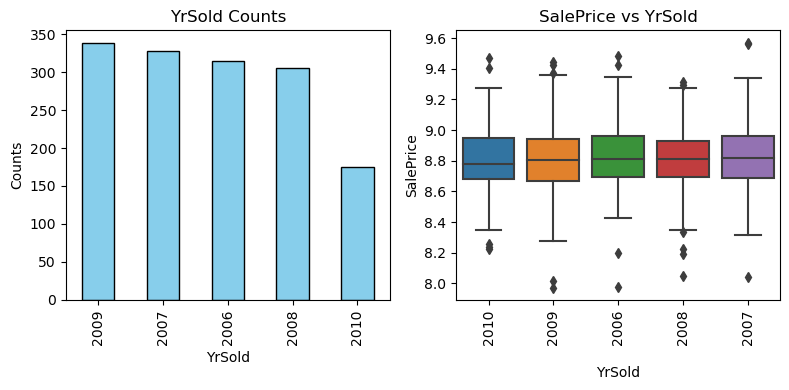

In [243]:
plotCategorical(train_sel, var, 'SalePrice')

We don't observe significant differences in *SalePrice* across the different years.

#### OverallQual

Rates the overall material and finish of the house (Numerical, Discrete)
|Category|Description|
|:----------:|:-------------|
|10|Very Excellent|
|9|Excellent|
|8|Very Good|
|7|Good|
|6|Above Average|
|5|Average|
|4|Below Average|
|3|Fair|
|2|Poor|
|1|Very Poor|

In [244]:
var = 'OverallQual'
train_sel[var].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

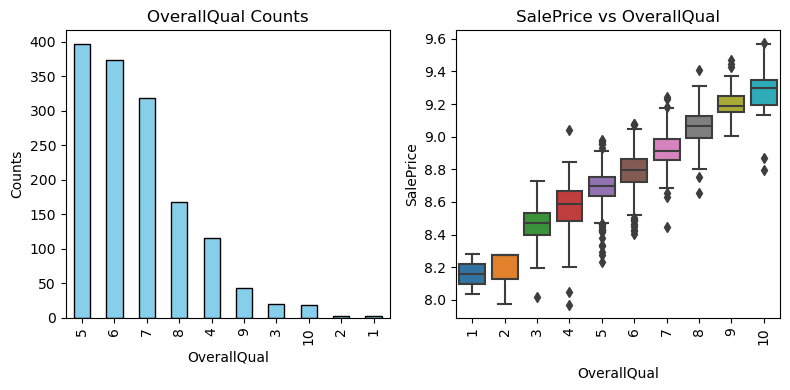

In [245]:
plotCategorical(train_sel, var, 'SalePrice')

#### OverallCond

Rates the overall condition of the house (Numerical, Discrete)
|Category|Description|
|:----------:|:-------------|
|10|Very Excellent|
|9|Excellent|
|8|Very Good|
|7|Good|
|6|Above Average|
|5|Average|
|4|Below Average|
|3|Fair|
|2|Poor|
|1|Very Poor|

In [246]:
var = 'OverallCond'
train_sel[var].describe()

count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64

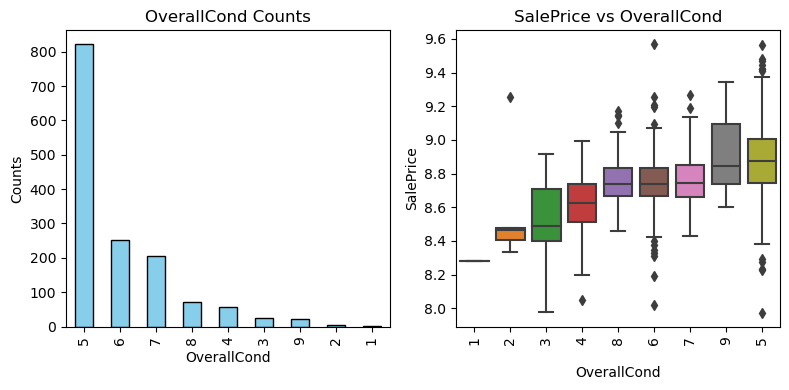

In [247]:
plotCategorical(train_sel, var, 'SalePrice')

#### BsmtFullBath

Basement full bathrooms (Numerical, Discrete)

In [248]:
var = 'BsmtFullBath'
train_sel[var].describe()

count    1460.000000
mean        0.425342
std         0.518911
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

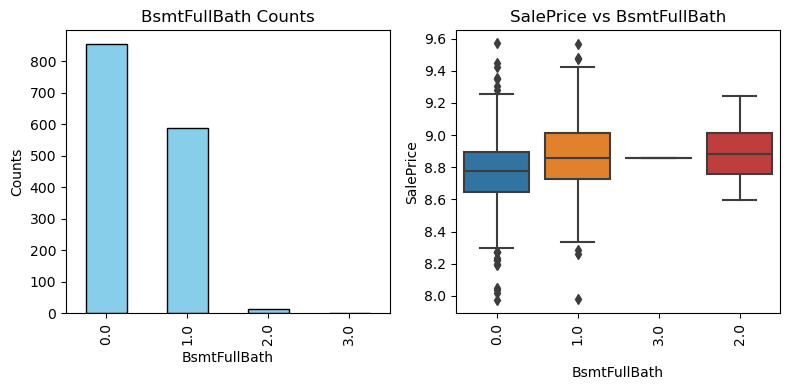

In [249]:
plotCategorical(train_sel, var, 'SalePrice')

#### BsmtHalfBath

Basement half bathrooms (Numerical, Discrete)

In [250]:
var = 'BsmtHalfBath'
train_sel[var].describe()

count    1460.000000
mean        0.057534
std         0.238753
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

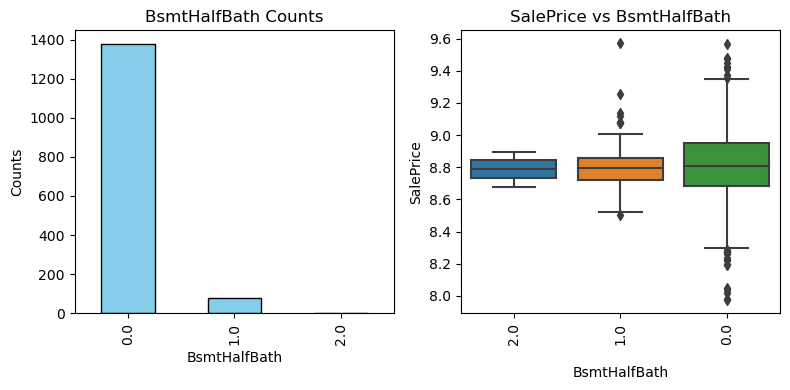

In [251]:
plotCategorical(train_sel, var, 'SalePrice')

#### FullBath

Full bathrooms above grade (Numerical, Discrete)

In [252]:
var = 'FullBath'
train_sel[var].describe()

count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

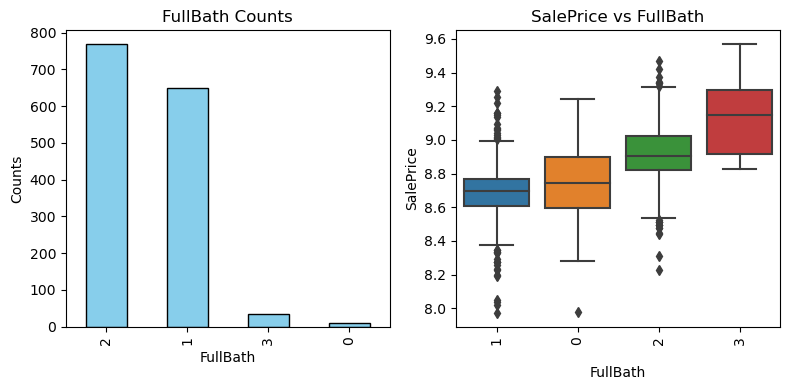

In [253]:
plotCategorical(train_sel, var, 'SalePrice')

#### HalfBath

Half baths above grade (Numerical, Discrete)

In [254]:
var = 'HalfBath'
train_sel[var].describe()

count    1460.000000
mean        0.382877
std         0.502885
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64

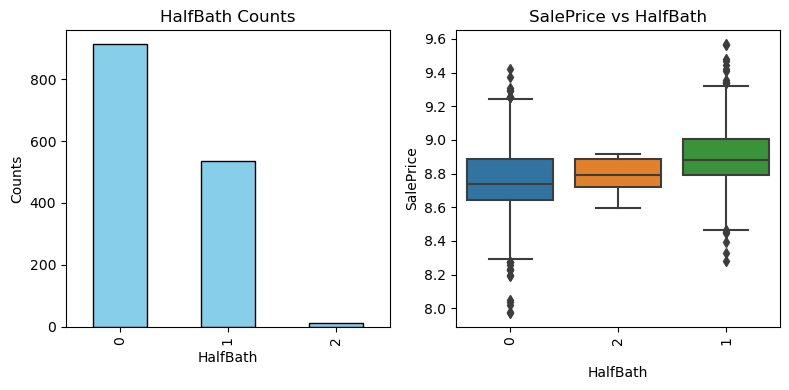

In [255]:
plotCategorical(train_sel, var, 'SalePrice')

If number of bathrooms impact on *SalePrice*, why don't we sum them all in a unique variable? 

#### BedroomAbvGr

Bedrooms above grade (does NOT include basement bedrooms) (Numerical, Discrete)

In [256]:
var = 'BedroomAbvGr'
train_sel[var].describe()

count    1460.000000
mean        2.866438
std         0.815778
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

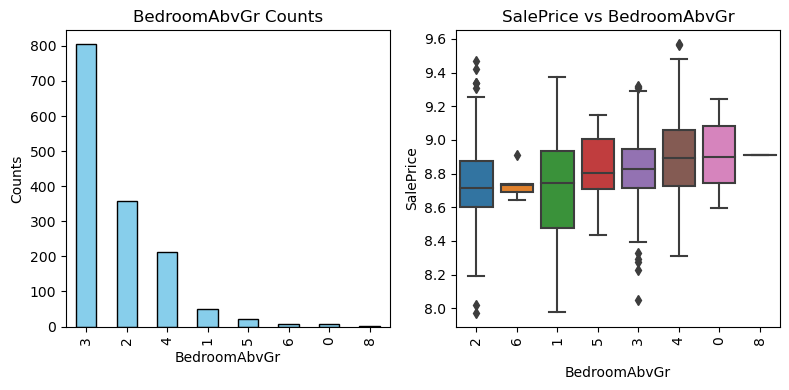

In [257]:
plotCategorical(train_sel, var, 'SalePrice')

This variable doesn't have a logical correlation with price.

#### KitchenAbvGr

Kitchens above grade (Numerical, Discrete)

In [258]:
var = 'KitchenAbvGr'
train_sel[var].describe()

count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

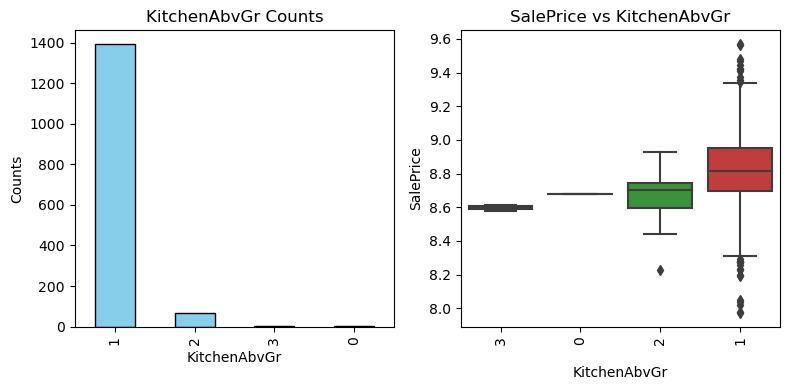

In [259]:
plotCategorical(train_sel, var, 'SalePrice')

This variable behaves contrary to what would be expected and its contribution isn't significative enough.

#### Fireplaces

Number of fireplaces (Numerical, Discrete)

In [260]:
var = 'Fireplaces'
train_sel[var].describe()

count    1460.000000
mean        0.613014
std         0.644666
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64

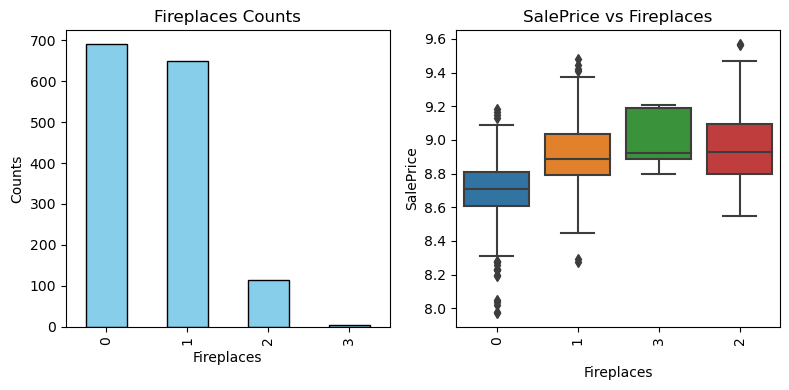

In [261]:
plotCategorical(train_sel, var, 'SalePrice')

Attending to the boxplot, the real difference in *SalePrice* occurs if the house has fireplace or not.


#### TotRmsAbvGrd

Total rooms above grade (does not include bathrooms) (Numerical, Discrete)

In [262]:
var = 'TotRmsAbvGrd'
train_sel[var].describe()

count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

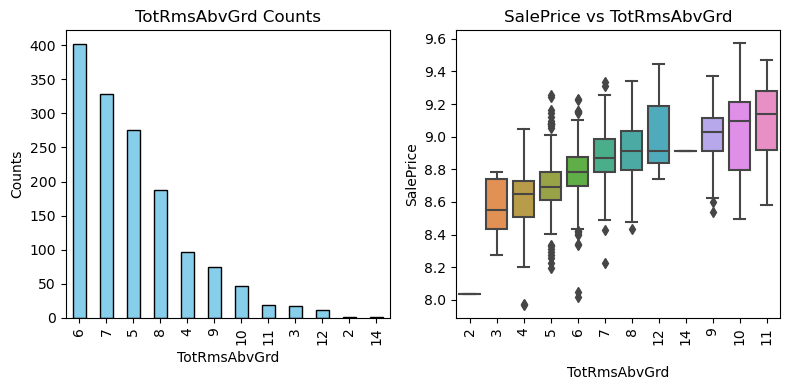

In [263]:
plotCategorical(train_sel, var, 'SalePrice')

#### GarageCars

Size of garage in car capacity (Numerical, Discrete)

In [264]:
var = 'GarageCars'
train_sel[var].describe()

count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

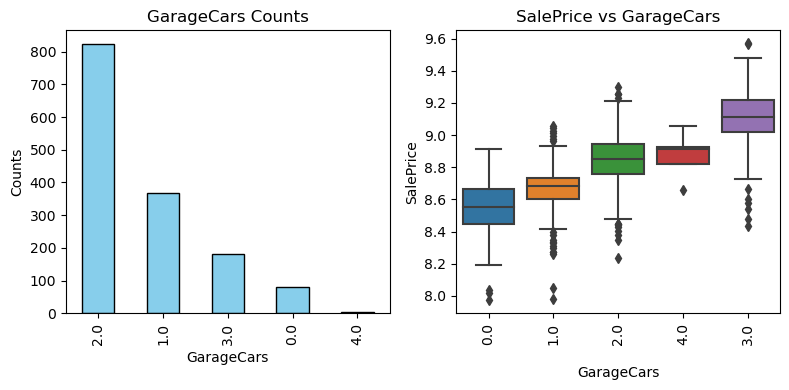

In [265]:
plotCategorical(train_sel, var, 'SalePrice')

### Numerical, continuous explanatory variables

#### GrLivArea

Above grade (ground) living area square feet (Numerical, continuous)

In [266]:
var = 'GrLivArea'
train_sel[var].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

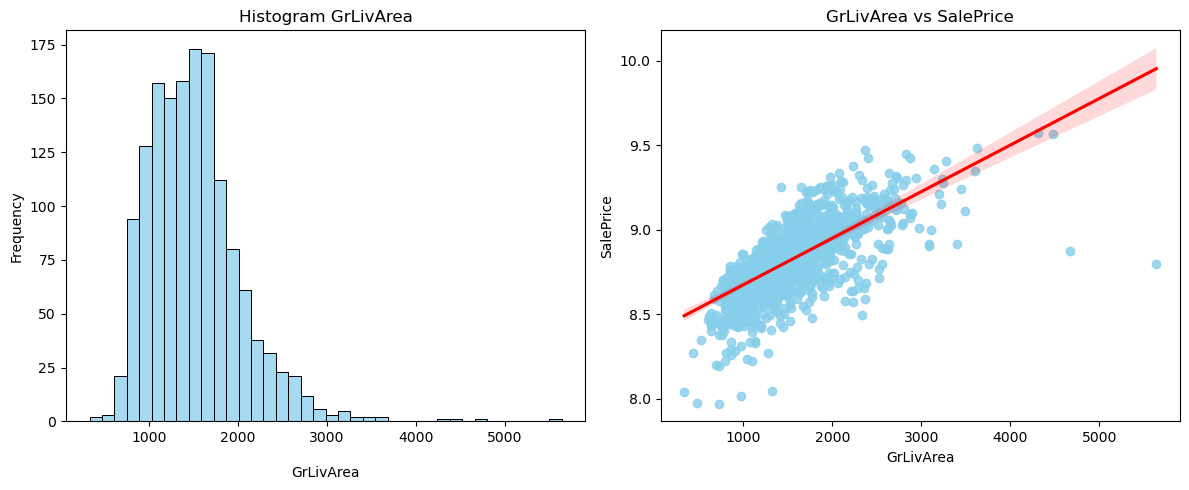

In [267]:
plotContinuous(train_sel, var, 'SalePrice')

*GrLivArea* is a great variable!

We can see two potential outliers when *GrLivArea* > 4500

#### LotFrontage

Linear feet of street connected to property (Numerical, continuous)

In [268]:
var = 'LotFrontage'
train_sel[var].describe()

count    1460.000000
mean       70.660769
std        22.444295
min        21.000000
25%        60.000000
50%        70.669811
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

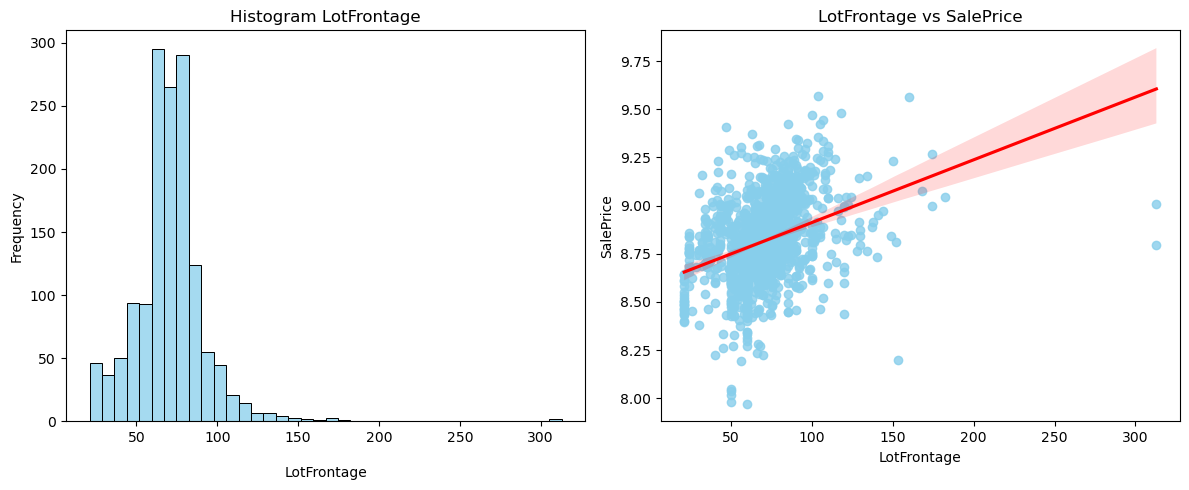

In [269]:
plotContinuous(train_sel, var, 'SalePrice')

We detect two possible outliers when *LotFrontage* > 300

#### LotArea

Lot size in square feet (Numerical, continuous)

In [270]:
var = 'LotArea'
train_sel[var].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

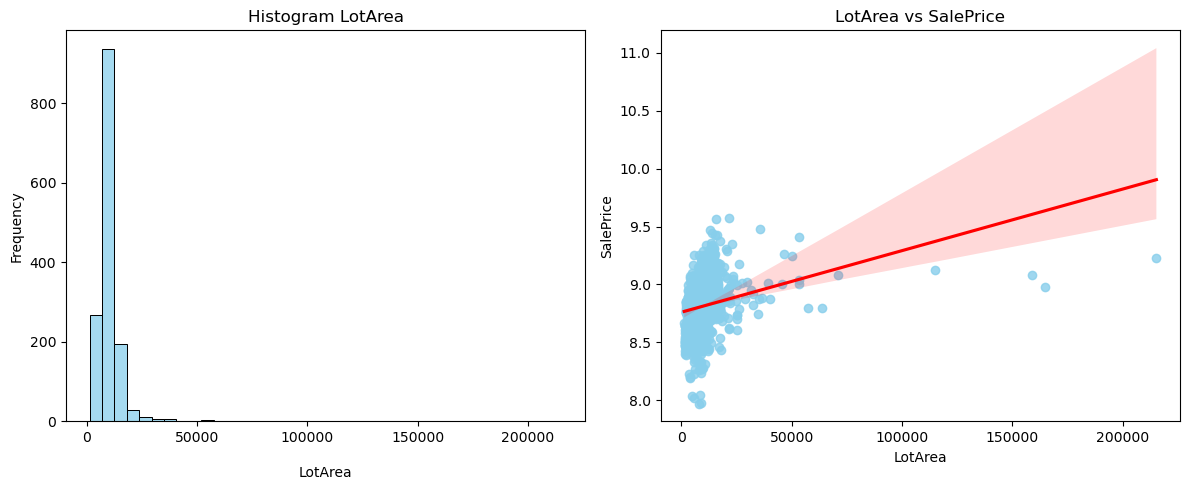

In [271]:
plotContinuous(train_sel, var, 'SalePrice')

There are some potential outliers when *LotArea* > 100000

#### MasVnrArea

Masonry veneer area in square feet (Numerical, continuous)

In [272]:
var = 'MasVnrArea'
train_sel[var].describe()

count    1460.000000
mean      103.117123
std       180.731373
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max      1600.000000
Name: MasVnrArea, dtype: float64

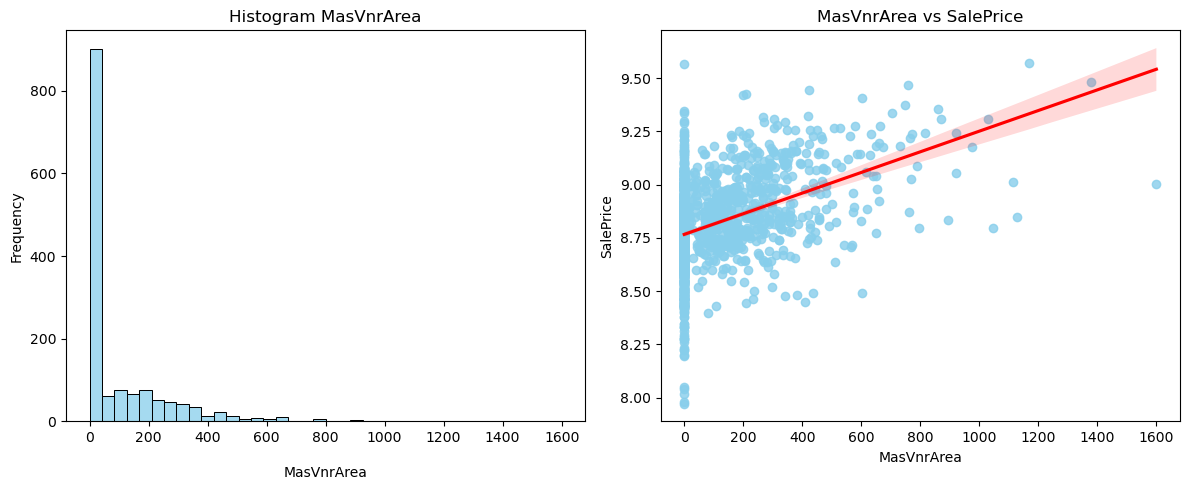

In [273]:
plotContinuous(train_sel, var, 'SalePrice')

#### BsmtFinSF1

Type 1 finished square feet (Numerical, continuous)

In [274]:
var = 'BsmtFinSF1'
train_sel[var].describe()

count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

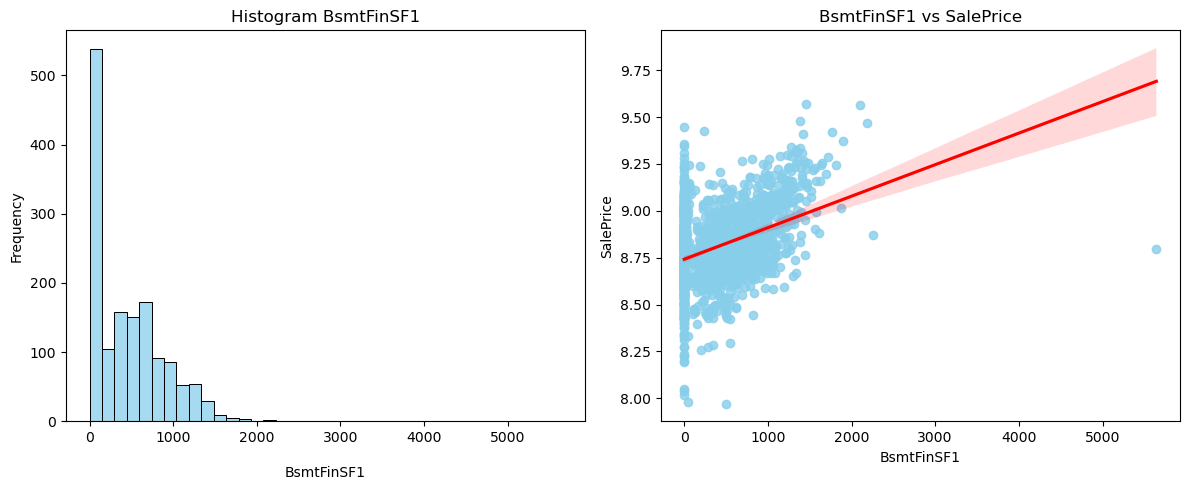

In [275]:
plotContinuous(train_sel, var, 'SalePrice')

A possible outlier can be identified when *BsmtFinSF1* > 5000

#### BsmtFinSF2

Type 2 finished square feet (Numerical, continuous)

In [276]:
var = 'BsmtFinSF2'
train_sel[var].describe()

count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

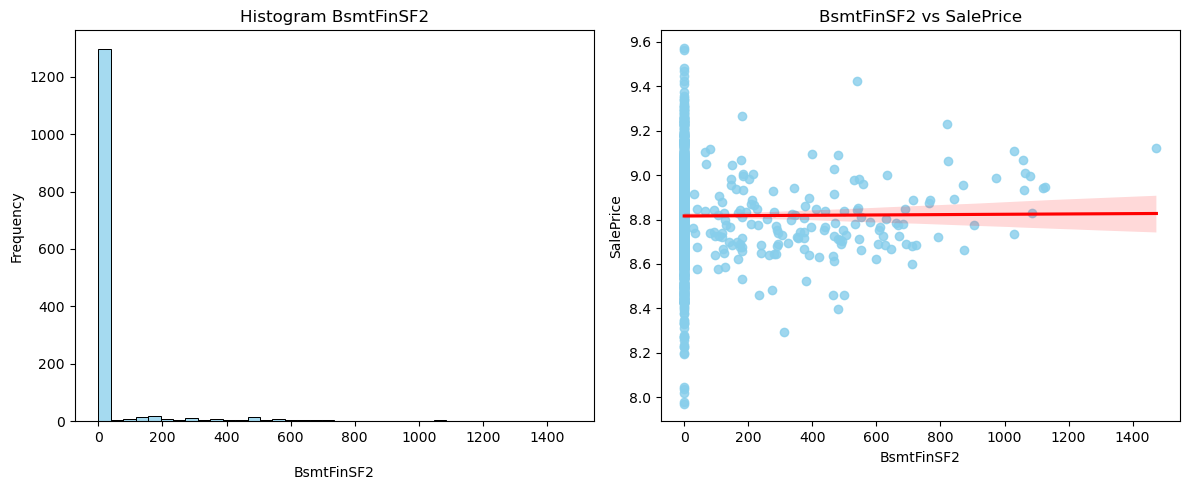

In [277]:
plotContinuous(train_sel, var, 'SalePrice')

#### BsmtUnfSF

Unfinished square feet of basement area (Numerical, continuous)

In [278]:
var = 'BsmtUnfSF'
train_sel[var].describe()

count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

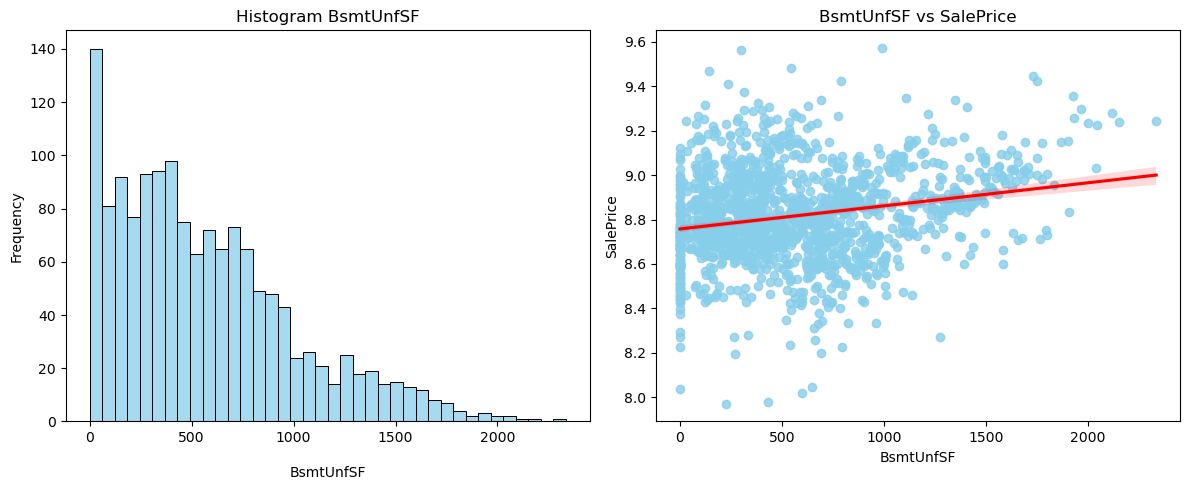

In [279]:
plotContinuous(train_sel, var, 'SalePrice')

#### TotalBsmtSF

Total square feet of basement area (Numerical, continuous)

In [280]:
var = 'TotalBsmtSF'
train_sel[var].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

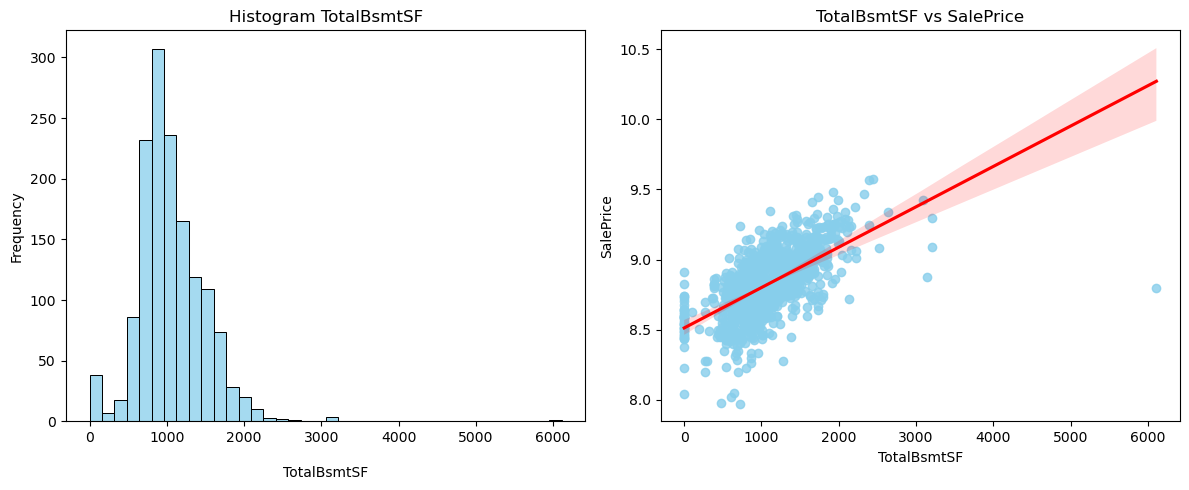

In [281]:
plotContinuous(train_sel, var, 'SalePrice')

*TotalBsmtSF* appears to have a strong correlation with *Saleprice*

#### 1stFlrSF

First Floor square feet (Numerical, continuous)

In [282]:
var = '1stFlrSF'
train_sel[var].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

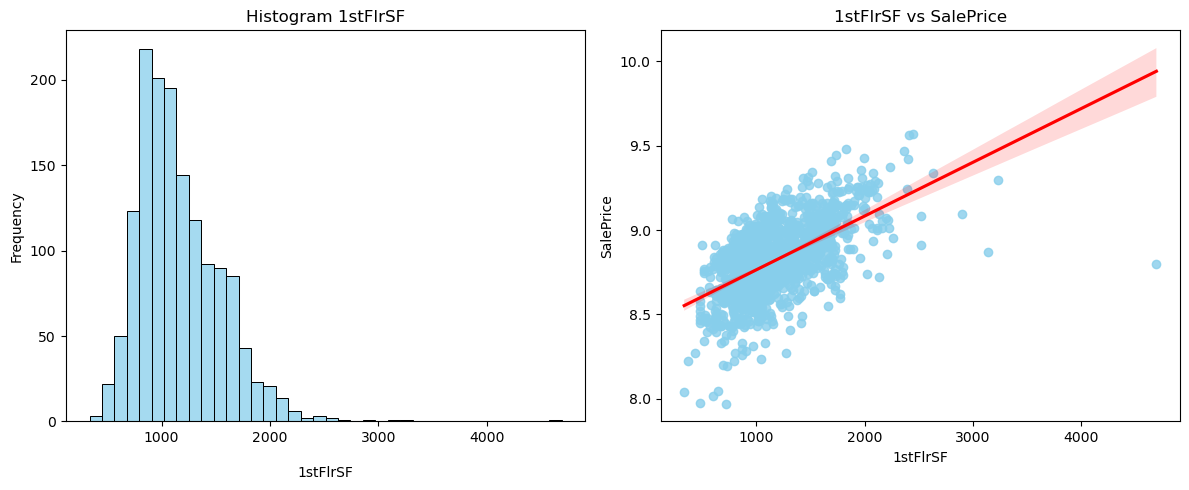

In [283]:
plotContinuous(train_sel, var, 'SalePrice')

This variable shows a notable correlation with *SalePrice*.

We observe a candidate for outlier when *1stFlrSF* > 4000

#### 2ndFlrSF

Second floor square feet (Numerical, continuous)

In [284]:
var = '2ndFlrSF'
train_sel[var].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

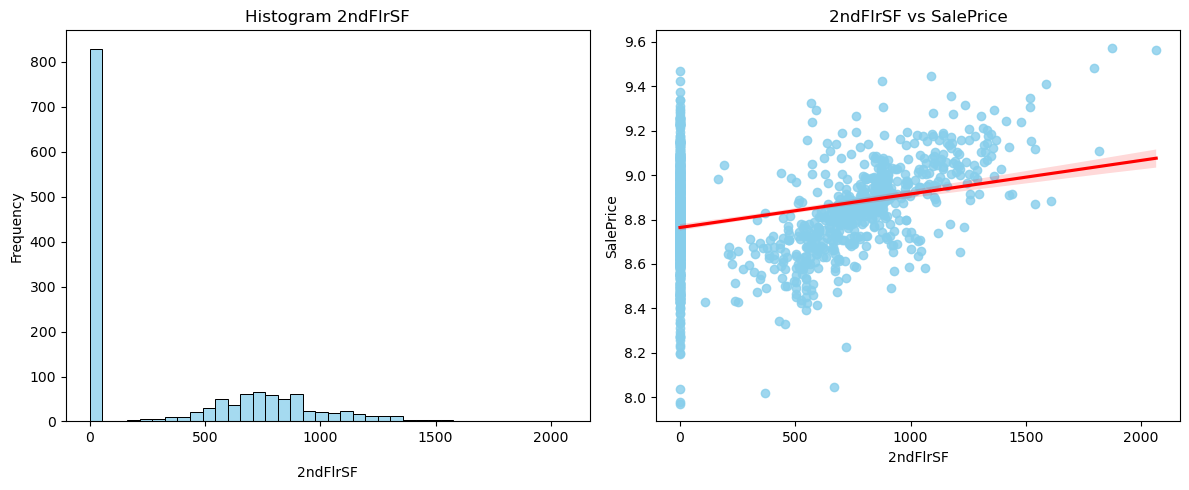

In [285]:
plotContinuous(train_sel, var, 'SalePrice')

#### LowQualFinSF

Low quality finished square feet (all floors) (Numerical, continuous)

In [286]:
var = 'LowQualFinSF'
train_sel[var].describe()

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

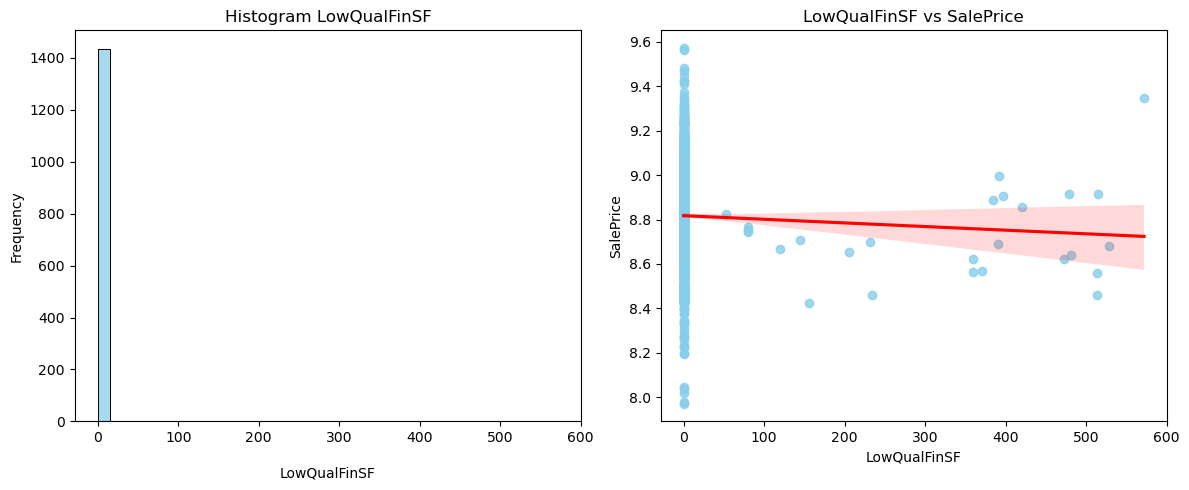

In [287]:
plotContinuous(train_sel, var, 'SalePrice')

*LowQualFinSF* doesn't provide significant information.

#### GarageArea

Size of garage in square feet (Numerical, continuous)

In [288]:
var = 'GarageArea'
train_sel[var].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

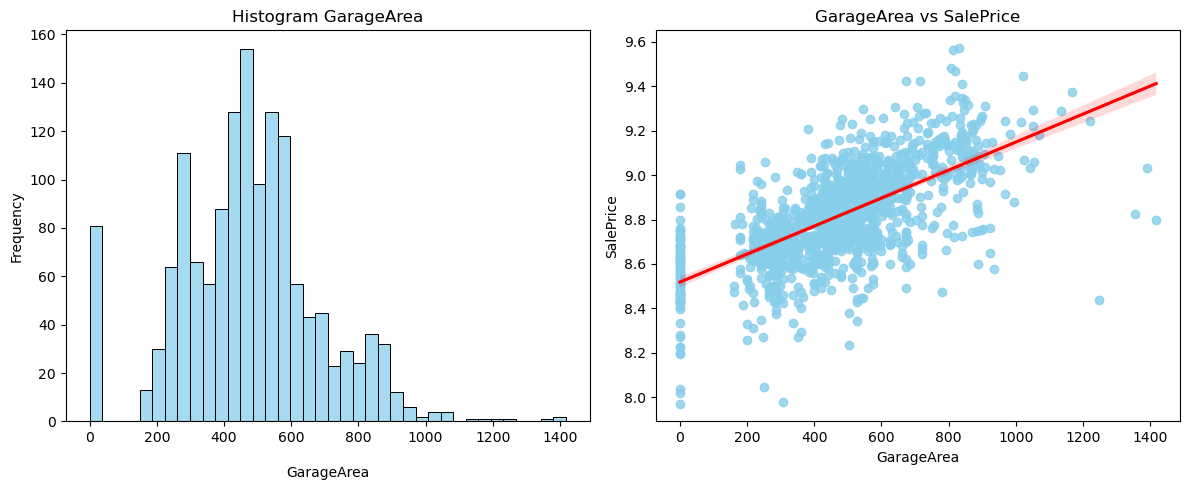

In [289]:
plotContinuous(train_sel, var, 'SalePrice')

#### WoodDeckSF

Wood deck area in square feet (Numerical, continuous)

In [290]:
var = 'WoodDeckSF'
train_sel[var].describe()

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

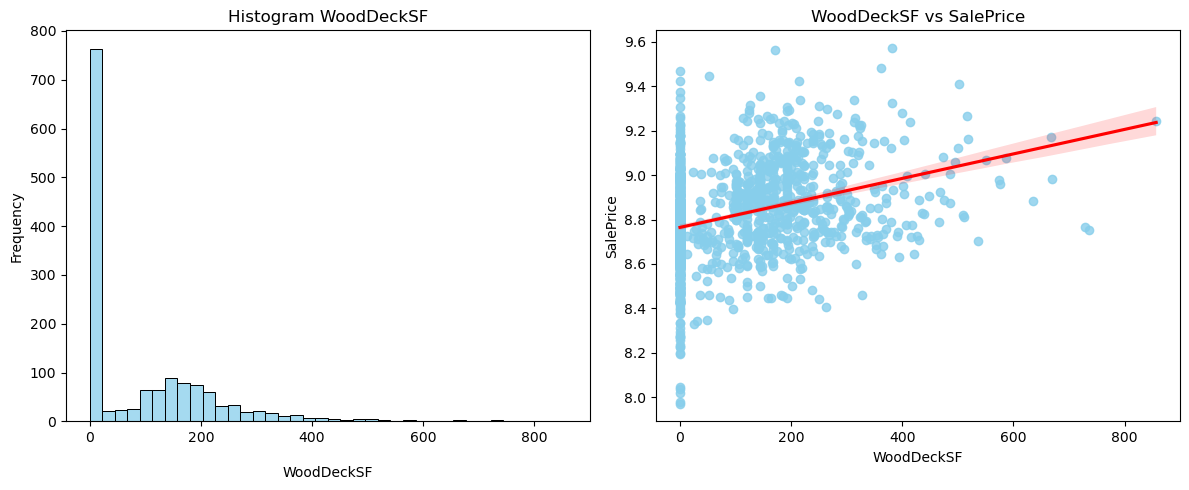

In [291]:
plotContinuous(train_sel, var, 'SalePrice')

#### OpenPorchSF

Open porch area in square feet (Numerical, continuous)

In [292]:
var = 'OpenPorchSF'
train_sel[var].describe()

count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

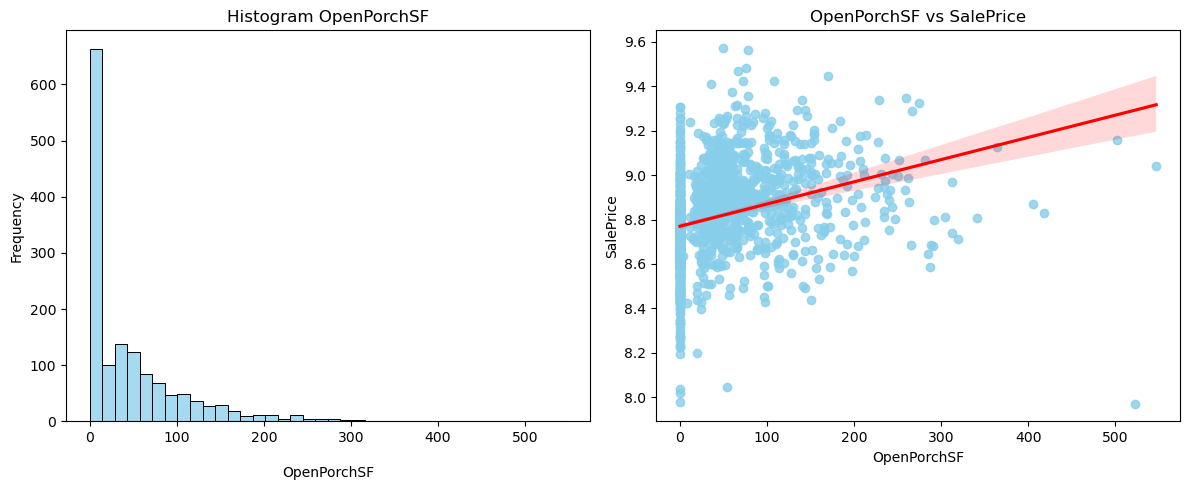

In [293]:
plotContinuous(train_sel, var, 'SalePrice')

#### EnclosedPorch

Enclosed porch area in square feet (Numerical, continuous)

In [294]:
var = 'EnclosedPorch'
train_sel[var].describe()

count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

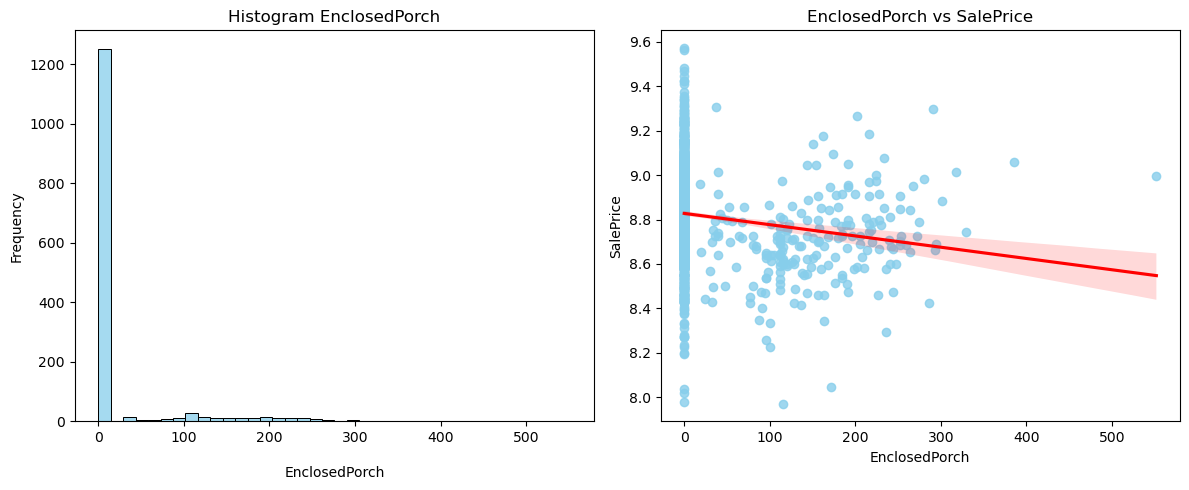

In [295]:
plotContinuous(train_sel, var, 'SalePrice')

#### 3SsnPorch

Three season porch area in square feet (Numerical, continuous)

In [296]:
var = '3SsnPorch'
train_sel[var].describe()

count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

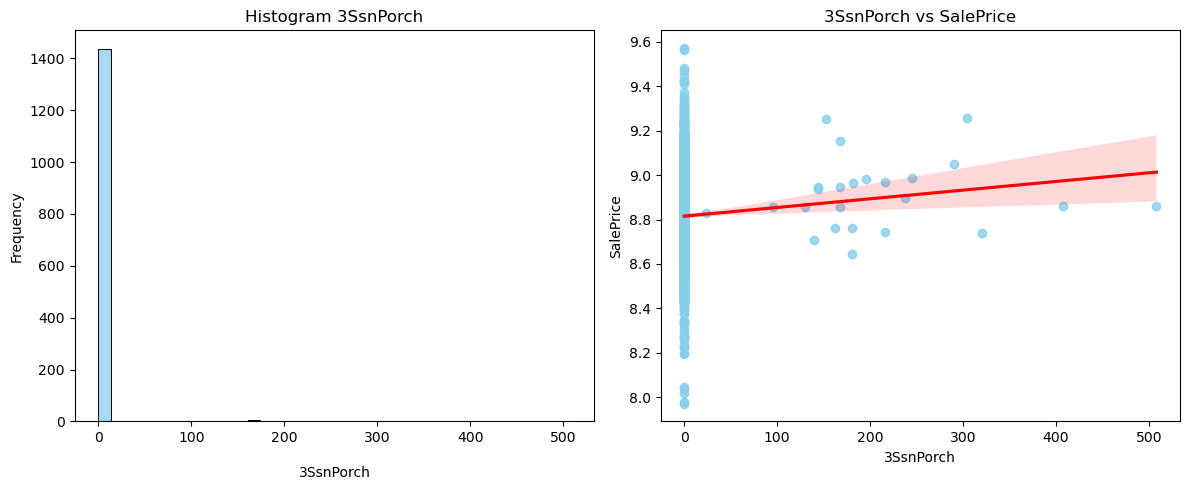

In [297]:
plotContinuous(train_sel, var, 'SalePrice')

#### ScreenPorch

Screen porch area in square feet (Numerical, continuous)

In [298]:
var = 'ScreenPorch'
train_sel[var].describe()

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

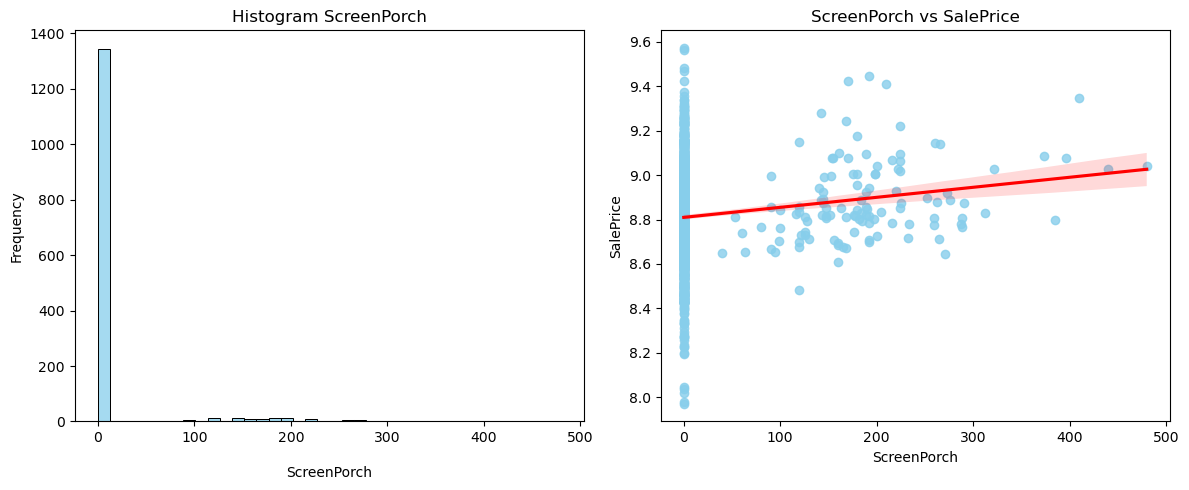

In [299]:
plotContinuous(train_sel, var, 'SalePrice')

There are several variables related to surface of different types of porches. Considering that just a few houses have porches, it would be interesting to sum all these surfaces in one variable to maybe increase the impact on *SalePrice*

#### PoolArea

Pool area in square feet (Numerical, continuous)

In [300]:
var = 'PoolArea'
train_sel[var].describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

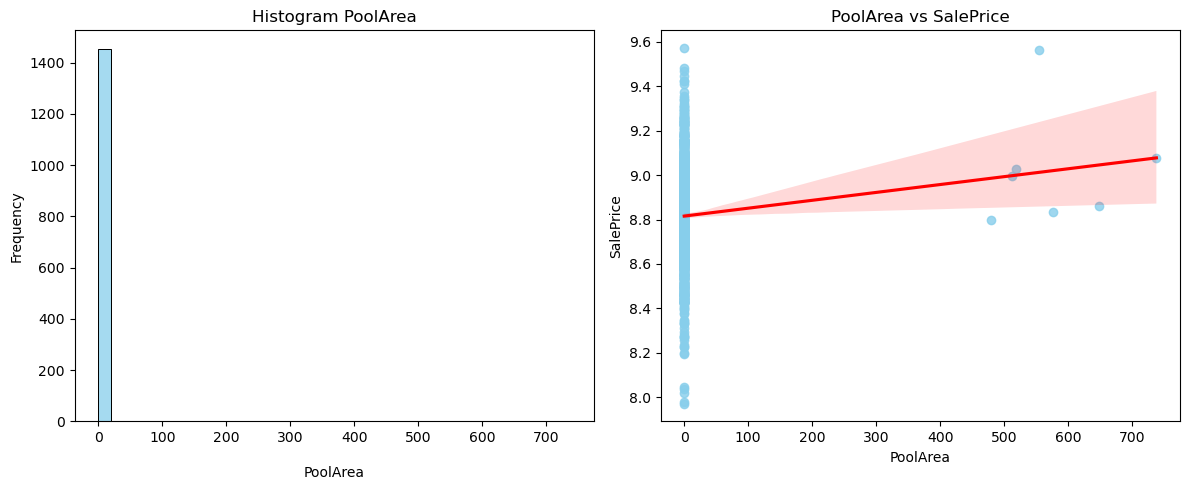

In [301]:
plotContinuous(train_sel, var, 'SalePrice')

We don't think that *PoolArea* neither *PoolQC* are good enough for our prediction model. We propose to create a new variables that informs if the house has a pool or not.

## Step 5 - Feature engineering

We add some new variables to our dataset 

#### TotalSF

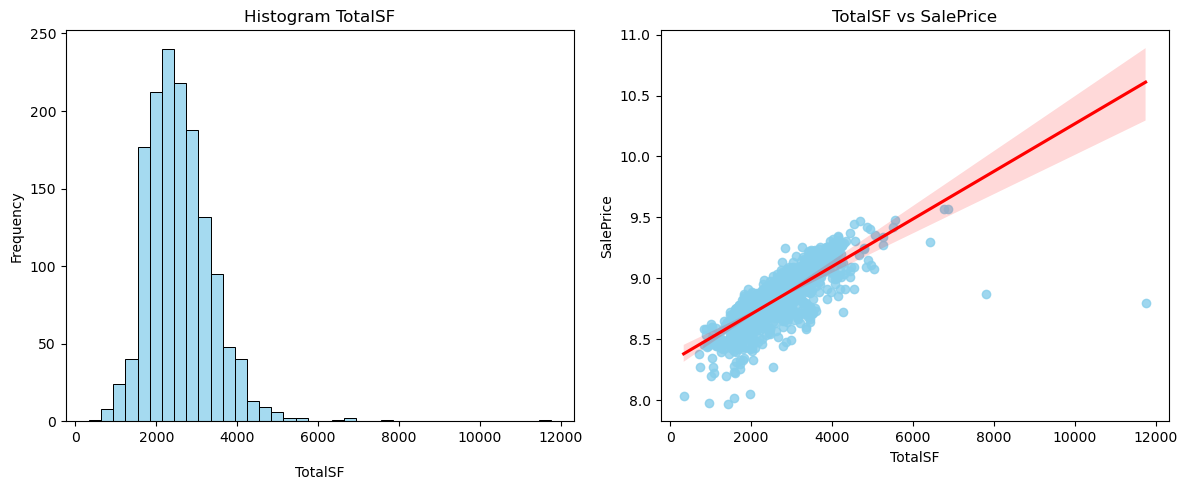

In [302]:
train_sel['TotalSF'] = (train_sel['TotalBsmtSF'] 
                       + train_sel['1stFlrSF'] 
                       + train_sel['2ndFlrSF'])
test_sel['TotalSF'] = (test_sel['TotalBsmtSF'] 
                       + test_sel['1stFlrSF'] 
                       + test_sel['2ndFlrSF'])
plotContinuous(train_sel, 'TotalSF', 'SalePrice')

#### TotalFinishSF

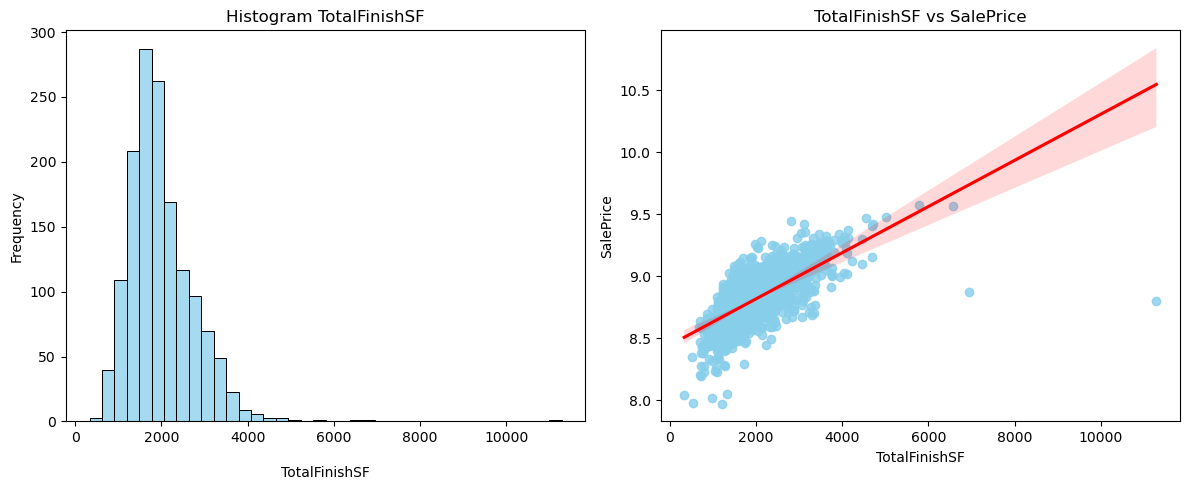

In [303]:
train_sel['TotalFinishSF'] = (train_sel['BsmtFinSF1'] 
                                 + train_sel['BsmtFinSF2'] 
                                 + train_sel['1stFlrSF'] 
                                 + train_sel['2ndFlrSF'])
test_sel['TotalFinishSF'] = (test_sel['BsmtFinSF1'] 
                                 + test_sel['BsmtFinSF2'] 
                                 + test_sel['1stFlrSF'] 
                                 + test_sel['2ndFlrSF'])
plotContinuous(train_sel, 'TotalFinishSF', 'SalePrice')

#### has2ndFloor

In [304]:
train_sel['has2ndFloor'] = 0
train_sel.loc[train_sel['2ndFlrSF'] != 0, 'has2ndFloor'] = 1
test_sel['has2ndFloor'] = 0
test_sel.loc[test_sel['2ndFlrSF'] != 0, 'has2ndFloor'] = 1

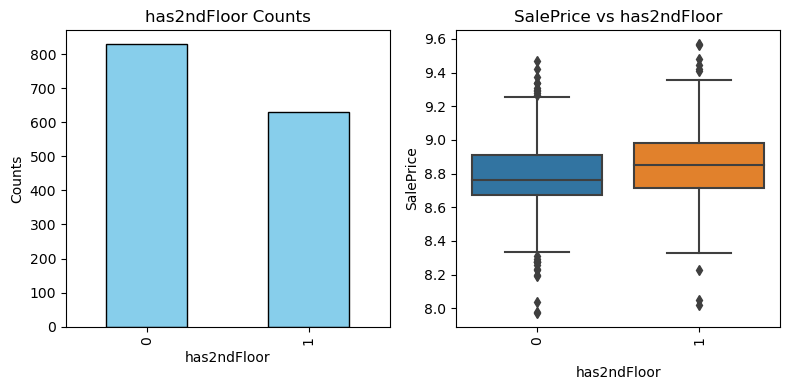

In [305]:
var = 'has2ndFloor'
plotCategorical(train_sel, var, 'SalePrice')

#### hasBsmt

In [306]:
train_sel['hasBsmt'] = 0
train_sel.loc[train_sel['TotalBsmtSF'] != 0, 'hasBsmt'] = 1
test_sel['hasBsmt'] = 0
test_sel.loc[test_sel['TotalBsmtSF'] != 0, 'hasBsmt'] = 1

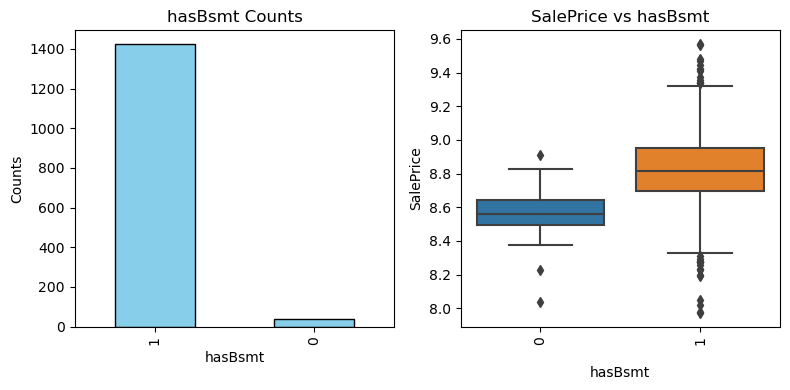

In [307]:
var = 'hasBsmt'
plotCategorical(train_sel, var, 'SalePrice')

#### hasShed

In [308]:
train_sel['hasShed'] = 0
train_sel.loc[train_sel['MiscFeature'] == 'Shed', 'hasShed'] = 1
test_sel['hasShed'] = 0
test_sel.loc[test_sel['MiscFeature'] == 'Shed', 'hasShed'] = 1

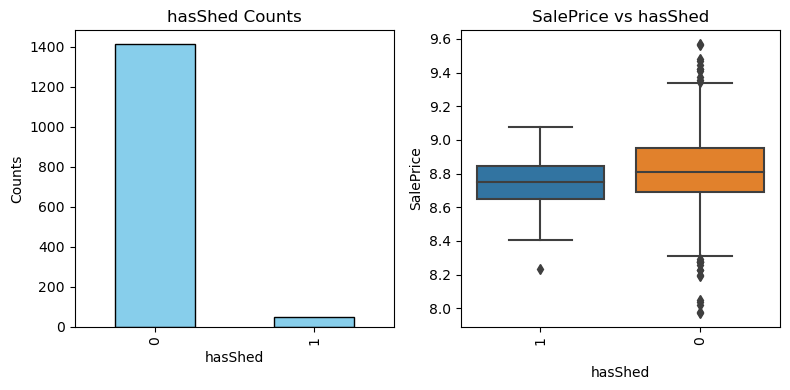

In [309]:
var = 'hasShed'
plotCategorical(train_sel, var, 'SalePrice')

#### hasGarage

In [310]:
train_sel['hasGarage'] = train_sel['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test_sel['hasGarage'] = test_sel['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

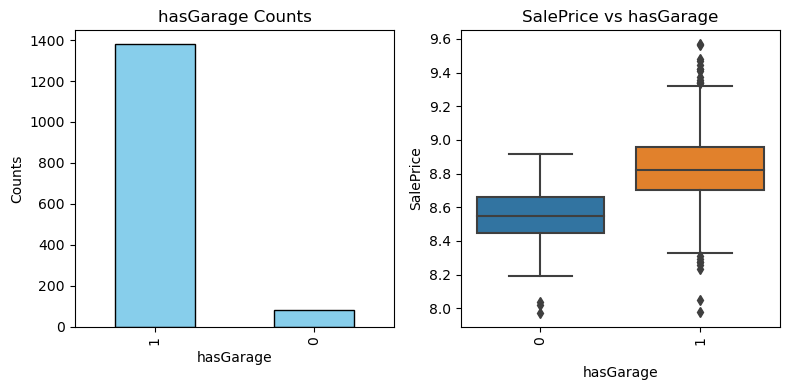

In [311]:
var = 'hasGarage'
plotCategorical(train_sel, var, 'SalePrice')

#### hasFireplace

In [312]:
train_sel['hasFireplace'] = train_sel['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test_sel['hasFireplace'] = test_sel['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

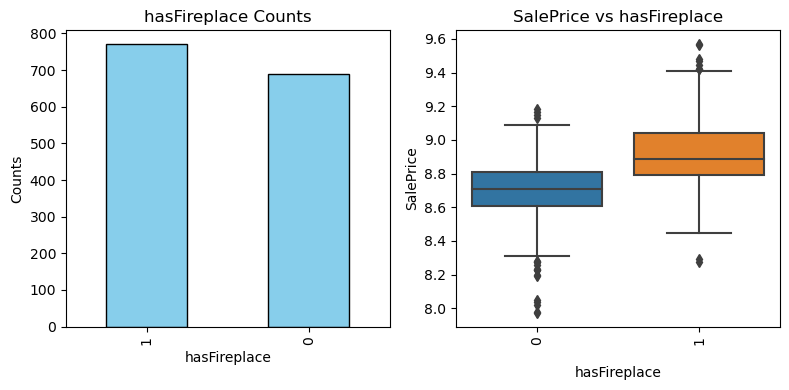

In [313]:
var = 'hasFireplace'
plotCategorical(train_sel, var, 'SalePrice')

#### hasPool

In [314]:
train_sel['hasPool'] = train_sel['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_sel['hasPool'] = test_sel['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

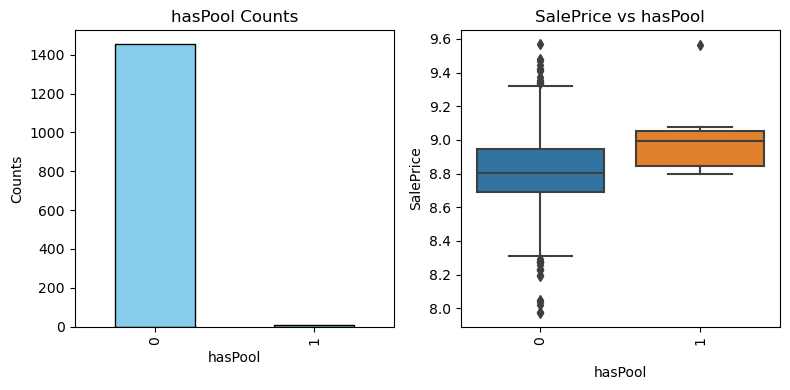

In [315]:
var = 'hasPool'
plotCategorical(train_sel, var, 'SalePrice')

#### TotalBaths

In [316]:
train_sel[[c for c in train_sel.columns if 'Bath' in c]].head(5)

BsmtFullBath  BsmtHalfBath  FullBath  HalfBath
0           1.0           0.0         2         1
1           0.0           1.0         2         0
2           1.0           0.0         2         1
3           1.0           0.0         1         0
4           1.0           0.0         2         1

In [317]:
train_sel['TotalBaths'] = train_sel['FullBath'] \
                        + 0.5 * train_sel['HalfBath'] \
                        + train_sel['BsmtFullBath'] \
                        + 0.5 * train_sel['BsmtHalfBath']
test_sel['TotalBaths'] = test_sel['FullBath'] \
                        + 0.5 * test_sel['HalfBath'] \
                        + test_sel['BsmtFullBath'] \
                        + 0.5 * test_sel['BsmtHalfBath']

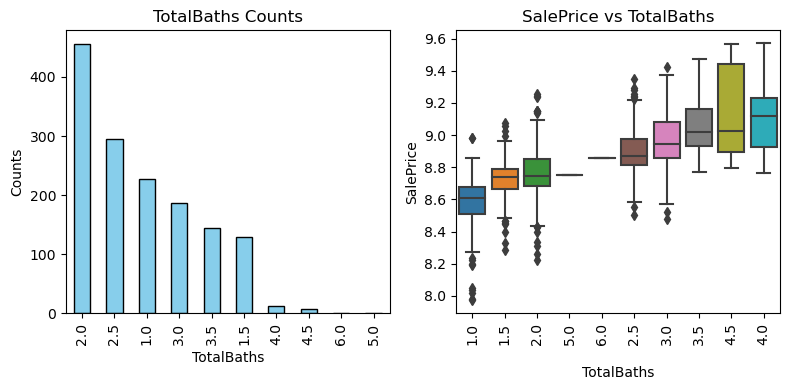

In [318]:
var = 'TotalBaths'
plotCategorical(train_sel, var, 'SalePrice')

As shown in the scattered plots, *TotalBaths* encapsulates all information regarding the bathrooms, and its impact on *SalePrice* appears to be more significant.

#### TotalPorchSF

In [319]:
train_sel['TotalPorchSF'] = train_sel['ScreenPorch'] \
                            + train_sel['3SsnPorch'] \
                            + train_sel['EnclosedPorch'] \
                            + train_sel['OpenPorchSF'] \
                            + train_sel['WoodDeckSF']
test_sel['TotalPorchSF'] = test_sel['ScreenPorch'] \
                            + test_sel['3SsnPorch'] \
                            + test_sel['EnclosedPorch'] \
                            + test_sel['OpenPorchSF'] \
                            + test_sel['WoodDeckSF']

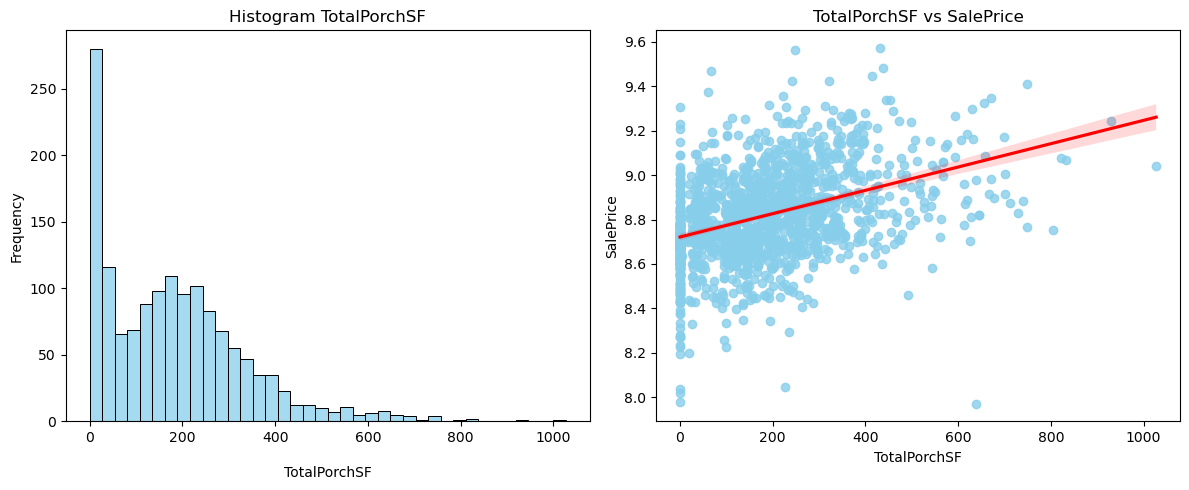

In [320]:
var = 'TotalPorchSF'
plotContinuous(train_sel, var, 'SalePrice')

*TotalPorchSF* compiles all porches-related data. Although we perceive an increasing trend, the new variable has quite scattered values, and we do not believe it will hold significance in our model.

#### Age

According to data visualization, *SalePrice* tends to increase with newer houses and the same occurs with the remodelated ones. The new variable takes into account both the *YearBuilt* and *YearRemodAdd* at the time of sale. If the house hasn't been remodelated 'YearRemodAdd'='YearBuilt'. However, we keep *YearBuilt* in our dataset because we think it is an important information.

In [321]:
train_sel['Age'] = train_sel['YrSold'] - train_sel['YearRemodAdd']
test_sel['Age'] = test_sel['YrSold'] - test_sel['YearRemodAdd']

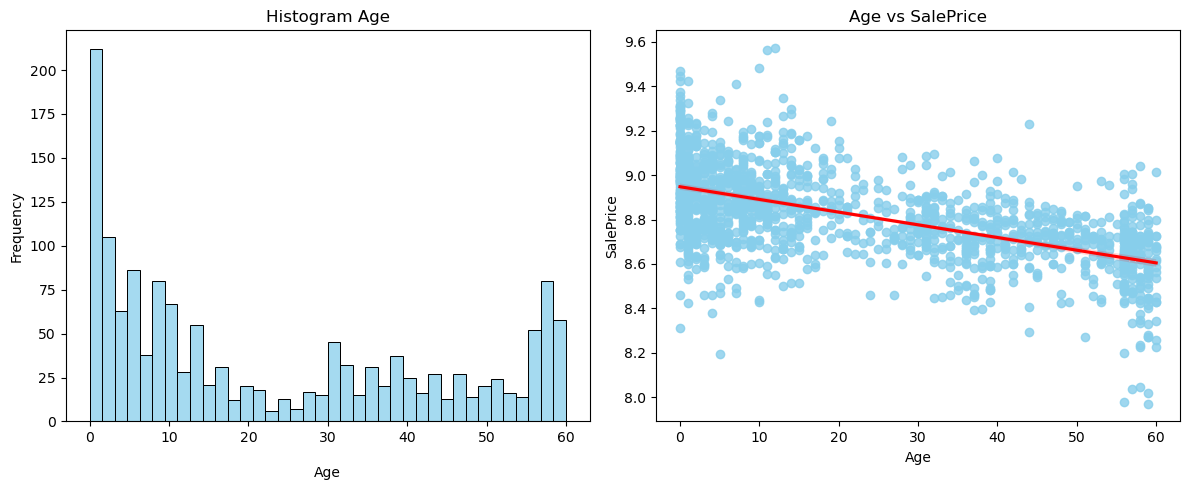

In [322]:
var = 'Age'
plotContinuous(train_sel, var, 'SalePrice')

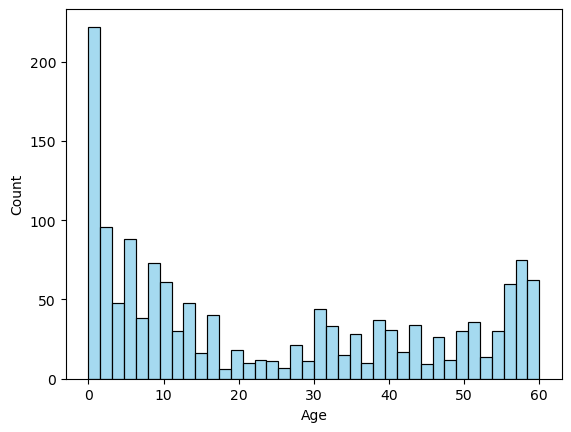

In [323]:
sns.histplot(test_sel['Age'], bins=int(np.sqrt(test_sel.shape[0])), color='skyblue')
plt.show()

#### isRemodeled

In [324]:
train_sel['isRemodeled'] = 0
train_sel.loc[train_sel['YearRemodAdd'] > train_sel['YearBuilt'], 'isRemodeled'] = 1
test_sel['isRemodeled'] = 0
test_sel.loc[test_sel['YearRemodAdd'] > test_sel['YearBuilt'], 'isRemodeled'] = 1

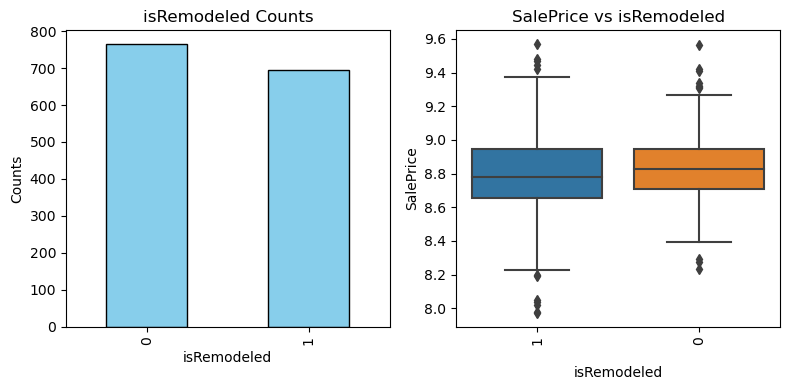

In [325]:
var = 'isRemodeled'
plotCategorical(train_sel, var, 'SalePrice')

#### isNew

In [326]:
train_sel['isNew'] = 0
train_sel.loc[train_sel['YearBuilt'] == train_sel['YrSold'], 'isNew'] = 1
test_sel['isNew'] = 0
test_sel.loc[test_sel['YearBuilt'] == test_sel['YrSold'], 'isNew'] = 1

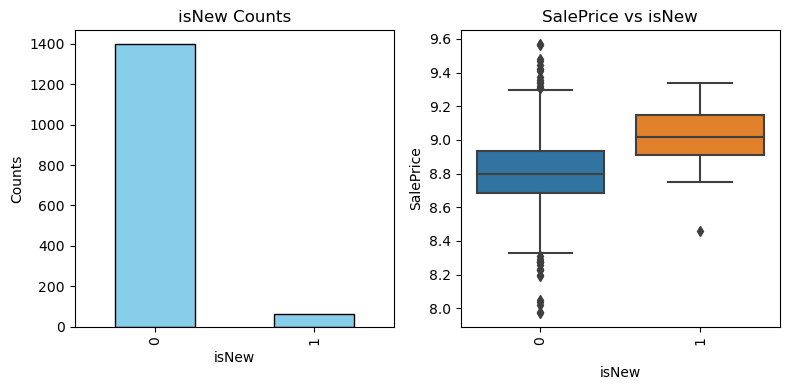

In [327]:
var = 'isNew'
plotCategorical(train_sel, var, 'SalePrice')


After performing the analysis, our dataframes look like this:

In [328]:
train_sel = train_sel[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
                       'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
                       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                       'OverallQual', 'OverallCond', 'YearBuilt', 'RoofStyle', 
                       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 
                       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 
                       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
                       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
                       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
                       'KitchenQual', 'TotRmsAbvGrd', 'FireplaceQu','hasFireplace',
                       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                       'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 
                       'TotalPorchSF', 'TotalBaths', 'Age', 'hasPool', 'TotalSF', 'hasGarage',
                       'isRemodeled', 'hasShed', 'isNew', 'has2ndFloor', 'hasBsmt', 'SalePrice',
                       'LowQualFinSF',  'Fireplaces',
                       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','YearRemodAdd'
    #'Condition2', 'YrSold', 'MiscVal','MiscFeature',
    #'RoofMatl', 'Heating', 'KitchenAbvGr', 'PoolArea', 'PoolQC', 'MoSold','BedroomAbvGr',
    # 'Alley', 'Fence','Street','Utilities','Functional'
                          ]]
test_sel = test_sel[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
                       'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
                       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                       'OverallQual', 'OverallCond', 'YearBuilt', 'RoofStyle', 
                       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 
                       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 
                       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
                       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
                       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
                       'KitchenQual', 'TotRmsAbvGrd', 'FireplaceQu','hasFireplace',
                       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                       'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 
                       'TotalPorchSF', 'TotalBaths', 'Age', 'hasPool', 'TotalSF', 'hasGarage',
                       'isRemodeled', 'hasShed', 'isNew', 'has2ndFloor', 'hasBsmt', 
                       'LowQualFinSF', 'Fireplaces',
                       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','YearRemodAdd'
                     # 'Alley', 'Fence','Street','Utilities','MiscFeature','Functional',
                     #'Condition2', 'YrSold', 'MiscVal','MiscFeature',BedroomAbvGr',
                      # 'RoofMatl', 'Heating', 'KitchenAbvGr', 'PoolArea', 'PoolQC', 'MoSold'
                          ]]

## Step 6 - Outliers

We detected some potential outliers before. Now it's time to make decissions about them. One of the strongest correlations with *SalePrice* we found while visualizing the graphs was *GrLivArea*. For this reason is why we can delete the two outliers:

In [329]:
train_sel.loc[train_clean['GrLivArea'] > 4500]

MSSubClass MSZoning  LotFrontage  LotArea LotShape LandContour LotConfig  \
523           F       RL        130.0    40094    Irreg       Irreg    Inside   
1298          F       RL        313.0    63887    Irreg       Irreg       FR2   

     LandSlope Neighborhood Condition1 BldgType HouseStyle  OverallQual  \
523        Gtl            B          B     1Fam     2Story           10   
1298       Gtl            B          A     1Fam     2Story           10   

      OverallCond  YearBuilt RoofStyle Exterior1st Exterior2nd MasVnrType  \
523             5       2007       Hip        Othr        Othr      Stone   
1298            5       2008       Hip        Othr        Othr      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
523        762.0        Ex        TA      PConc       Ex       TA   
1298       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
523            Gd          GLQ      2260.0          Unf         0.0   
1298           Gd          GLQ      5644.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF HeatingQC CentralAir Electrical  1stFlrSF  \
523       878.0       3138.0        Ex          Y      SBrkr      3138   
1298      466.0       6110.0        Ex          Y      SBrkr      4692   

      2ndFlrSF  GrLivArea KitchenQual  TotRmsAbvGrd FireplaceQu  hasFireplace  \
523       1538       4676          Ex            11          Gd             1   
1298       950       5642          Ex            12          Gd             1   

     GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
523     BuiltIn       2007.0          Fin         3.0       884.0         TA   
1298     Attchd       2008.0          Fin         2.0      1418.0         TA   

     GarageCond PavedDrive SaleType SaleCondition  TotalPorchSF  TotalBaths  \
523          TA          Y      New       Partial           614         4.5   
1298         TA          Y      New       Partial           506         4.5   

      Age  hasPool  TotalSF  hasGarage  isRemodeled  hasShed  isNew  \
523     0        0   7814.0          1            1        0      0   
1298    0        1  11752.0          1            0        0      1   

      has2ndFloor  hasBsmt  SalePrice  LowQualFinSF  Fireplaces  WoodDeckSF  \
523             1        1   8.871913             0           1         208   
1298            1        1   8.797384             0           3         214   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  BsmtFullBath  \
523           406              0          0            0           1.0   
1298          292              0          0            0           2.0   

      BsmtHalfBath  FullBath  HalfBath  YearRemodAdd  
523            0.0         3         1          2008  
1298           0.0         2         1          2008

In [330]:
train_sel = train_sel.drop(train_sel[train_sel['GrLivArea'] > 4500].index) 

Now we are going to plot again those variables where we found some possible outliers just in case they differ from the ones we've removed:

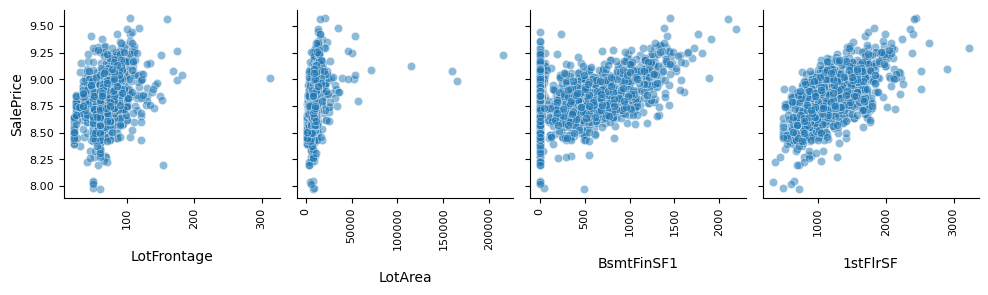

In [331]:
g = sns.pairplot(train_sel,
                 x_vars = ['LotFrontage', 'LotArea', 'BsmtFinSF1', '1stFlrSF'],
                 y_vars = ['SalePrice'],
                 plot_kws={'alpha': 0.5})

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, labelpad=15) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    ax.tick_params(axis='both', which='both', labelsize=8)

plt.show()

Outliers detected in *BsmtFinSF1* and *1stFlrSF* were the ones we've just deleted. We are going to delete LotFrontage>300 and LotArea>100000

In [332]:
train_sel = train_sel.drop(train_sel[train_sel['LotFrontage'] > 300].index) 
train_sel = train_sel.drop(train_sel[train_sel['LotArea'] > 100000].index) 

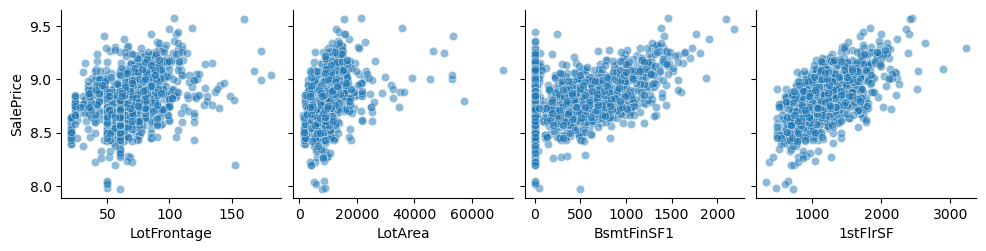

In [333]:
sns.pairplot(train_sel,
             x_vars = ['LotFrontage', 'LotArea', 'BsmtFinSF1', '1stFlrSF'],
             y_vars = ['SalePrice'],
             plot_kws={'alpha': 0.5})
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_xlabel(ax.get_xlabel(), fontsize=10) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    ax.tick_params(axis='both', which='both', labelsize=8)
plt.show()

Much better now!

After deleting some rows, we reset indexes in our training dataset:

In [334]:
train_sel = train_sel.reset_index(drop=True)

## Step 7 - Skewness

First of all, we need to separate numerical and categorical variables:

In [335]:
num_vars = train_sel.dtypes[train_sel.dtypes != "object"].index
print('Numeric variables: ')
print(num_vars)

categ_vars = train_sel.dtypes[train_sel.dtypes == "object"].index
print('Categorical variables: ')
print(categ_vars)

Numeric variables: 
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'hasFireplace',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalPorchSF', 'TotalBaths',
       'Age', 'hasPool', 'TotalSF', 'hasGarage', 'isRemodeled', 'hasShed',
       'isNew', 'has2ndFloor', 'hasBsmt', 'SalePrice', 'LowQualFinSF',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'YearRemodAdd'],
      dtype='object')
Categorical variables: 
Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure

We don't want to consider the variable *SalePrice* in skewness analysis as we transformed it before:

In [336]:
num_vars = [col for col in num_vars if col not in ['SalePrice']]

Now we calculate skewness and select those numerical variables highly skewed:

In [337]:
skewness = train_sel[num_vars].apply(lambda x: abs(skew(x)))
skewed_num_vars = skewness[skewness > 0.75]     
skewed_num_vars = skewed_num_vars.index

We apply Box-Cox transformation:

In [338]:
for var in skewed_num_vars:
    train_sel[var] = boxcox1p(train_sel[var], boxcox_normmax(train_sel[var] + 1))
    test_sel[var] = boxcox1p(test_sel[var], boxcox_normmax(test_sel[var] + 1))

In [339]:
print("These are the skewed variables transformed:")
print(skewed_num_vars)

These are the skewed variables transformed:
Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotalPorchSF', 'hasPool',
       'TotalSF', 'hasGarage', 'hasShed', 'isNew', 'hasBsmt', 'LowQualFinSF',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'BsmtHalfBath'],
      dtype='object')


## Step 8 - Feature Relationships

We should avoid multicollinearity because it negatively impacts linear regression models. We are going to fit regularization models that address this issue more efficiently. However, let's take a look to our variables:

### Numerical variables correlation with *SalePrice*

We need to recover *SalePrice* to our numerical variables *num_vars*:

In [340]:
num_vars = list(num_vars)
num_vars.append('SalePrice')
num_vars = pd.Index(num_vars)

These are the highest correlation values with *SalePrice*

<Axes: title={'center': 'Top-10 Correlation with SalePrice'}>

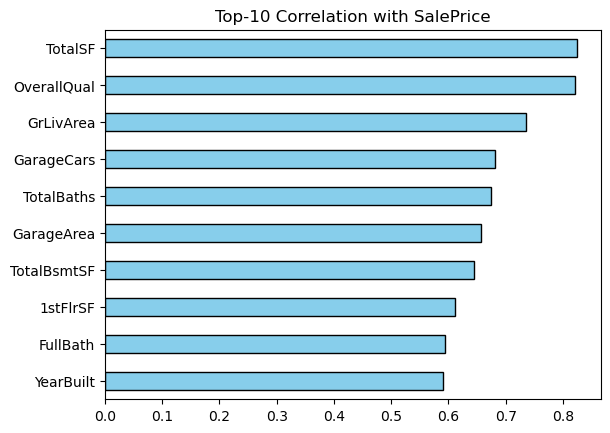

In [341]:
correlation_sorted = train_sel[num_vars].corr()['SalePrice'].sort_values(ascending=False)
top_correlation_sorted = correlation_sorted.head(11)
top_correlation_sorted = top_correlation_sorted.iloc[1:]  # delete SalePrice
top_correlation_sorted = top_correlation_sorted[::-1] # longest bars upper

top_correlation_sorted.plot(kind='barh',
                            color='skyblue', 
                            edgecolor='black',
                            title='Top-10 Correlation with SalePrice')

### Correlation matrix

The heat map also confirms that OverallQual, TotalBsmtSF, YearBuilt, GarageCars and GrLivArea have a good correlation with our goal variable. 

<Axes: >

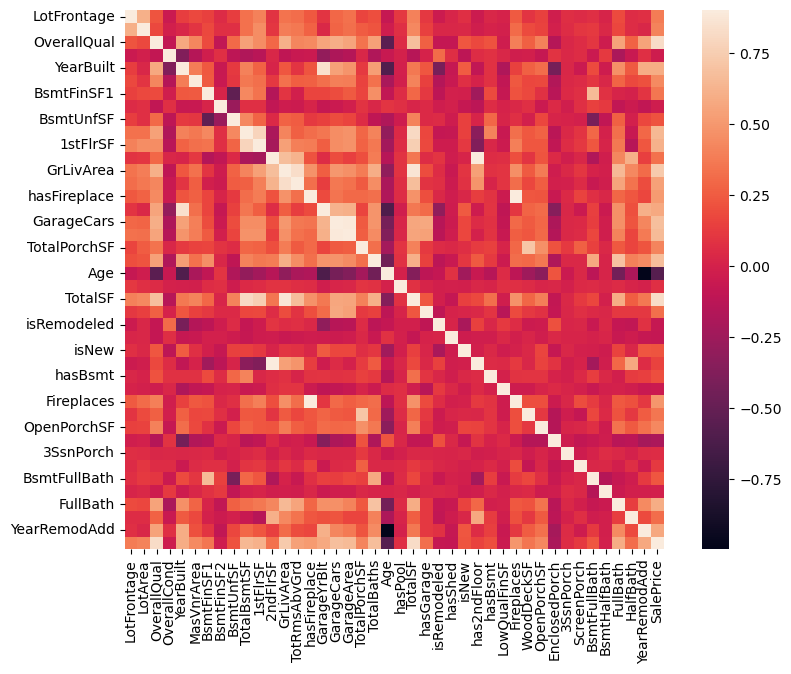

In [342]:
corr_mat = train_sel[num_vars].corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr_mat, vmax=.9, square=True)

As we see at the heat map, these are some pairs of high-correlated variables. 
- hasBsmt & TotalBsmtSF
- has2ndFloor & 2ndFlrSF
- TotalSF & GrLivArea
- GarageYsBlt & Yearbuilt
- GrLivArea & TotRmsAbvGrd
- GarageArea & GarageCars
- 1stFirSF & TotalBsmtSF

## Step 9 - Dummies

We are going to convert categorical variables into dummies:

In [343]:
categ_vars = train_sel.dtypes[train_sel.dtypes == "object"].index
train_dummy_vars = pd.get_dummies(train_sel[categ_vars])
test_dummy_vars = pd.get_dummies(test_sel[categ_vars])

We drop dummies with less than 20 'ones' and their complementary variables:

In [344]:
sum_of_dummies = train_dummy_vars.sum()
value_max_of_ones = train_sel.shape[0]-20
cols_to_drop = sum_of_dummies[(sum_of_dummies < 20) | (sum_of_dummies > value_max_of_ones)].index
train_dummy_vars = train_dummy_vars.drop(columns=cols_to_drop)

We drop the same dummies in test dataset, but we check if they exist first!

In [345]:
cols_to_drop = [col_name for col_name in cols_to_drop if col_name in test_dummy_vars.columns]
test_dummy_vars.drop(columns=cols_to_drop, inplace=True)

And we also have to check if there is any dummy in test dataset that doesn't exist in training:

In [346]:
cols_to_drop = [col_name for col_name in test_dummy_vars.columns if col_name not in train_dummy_vars.columns]
test_dummy_vars.drop(columns=cols_to_drop, inplace=True)

Now we add dummies to the training dataset and drop old categorical variables:

In [347]:
train_final = pd.concat([train_sel, train_dummy_vars], axis=1)
train_final = train_sel.drop(categ_vars, axis=1)
test_final = pd.concat([test_sel, test_dummy_vars], axis=1)
test_final = test_sel.drop(categ_vars, axis=1)

In [348]:
print('Our training dataset has '+str(train_final.shape[0])+' rows and '+str(train_final.shape[1])+' variables')

Our training dataset has 1453 rows and 42 variables


## Step 10 - Regularized Linear Regression Modelling

We are going to try some regularized linear regression models and see how well they work.

Now we are going to use Cross-fold validation for evaluating models. This strategy prevents overfitting and gives us more realistic metrics. 

This is our training dataset:

In [349]:
y = train_final['SalePrice'].copy()             # real values SalePrice
x = train_final.drop(columns=['SalePrice']).copy()   # selected explanatory variables

### Cross-fold validation

Cross-fold validation splits our training dataset in n_folds subsets. Then, one subset is used for evaluation while the rest is used to train the model. Therefore, the model is trained n-folds times and we can calculate the mean of error metrics.

*KFold* shuffles the observations and returns the indexes of the data for each fold. 

*cross_val_score* calculates mean-squared-error for each iteration predictions. Then, our function *rmse_cv* gives us the mean of RMSE.

In [350]:
n_folds = 10

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model):
    k_folds = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(x)
    rmse= (np.sqrt(-cross_val_score(model, x, y, scoring=scorer, cv = k_folds))).mean()
    return(rmse)

### Ridge

Now we train a Ridge model with training dataset and calculate RMSE. 

Alpha parameter measures how flexible our model is. RidgeCV selects the best value for us from the list we provide. Based on that value, we provide another list of values around it.

In [351]:
ridgeCV = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridgeCV.fit(x, y)
alpha = ridgeCV.alpha_
ridgeCV = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, 
                          alpha * .8, alpha * .85, alpha * .9, alpha * .95, 
                          alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, 
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                  cv = 10)
ridgeCV.fit(x, y)

RidgeCV(alphas=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1,
                1.15, 1.25, 1.3, 1.35, 1.4],
        cv=10)

In [352]:
print("Best alpha for Ridge: ", ridgeCV.alpha_)
print("RMSE for Ridge Model: ", rmse_cv(ridgeCV).mean())

Best alpha for Ridge:  1.4
RMSE for Ridge Model:  0.06488197498380745


### Lasso

Lasso model employs a more aggressive strategy than Ridge and it solves multicollinearity removing coefficients:

In [353]:
lassoCV = LassoCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
lassoCV.fit(x, y)
alpha = lassoCV.alpha_
lassoCV = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, 
                          alpha * .8, alpha * .85, alpha * .9, alpha * .95, 
                          alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, 
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                  cv = 10)
lassoCV.fit(x, y)

LassoCV(alphas=[0.006, 0.006500000000000001, 0.006999999999999999, 0.0075,
                0.008, 0.0085, 0.009000000000000001, 0.0095, 0.01, 0.0105,
                0.011000000000000001, 0.0115, 0.0125, 0.013000000000000001,
                0.013500000000000002, 0.013999999999999999],
        cv=10)

In [354]:
print("Best alpha for Lasso Model: ", lassoCV.alpha_)
print("RMSE for Lasso Model: ", rmse_cv(lassoCV).mean())

Best alpha for Lasso Model:  0.006
RMSE for Lasso Model:  0.06658344245140765


### Elastic Net

Elastic Net combines Ridge and Lasso. *l1_ratio* controls the combination of L1 (Lasso) and L2 (Ridge) regularization. Let's try how it works with our dataset:

In [355]:
elasticNet = ElasticNetCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60],
                          l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
                          cv = 10)
elasticNet.fit(x, y)
best_l1_ratio = elasticNet.l1_ratio_
alpha = elasticNet.alpha_
elasticNet = ElasticNetCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, 
                                    alpha * .8, alpha * .85, alpha * .9, alpha * .95, 
                                    alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, 
                                    alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],
                          l1_ratio = best_l1_ratio,
                          cv = 10)
elasticNet.fit(x, y)

ElasticNetCV(alphas=[0.006, 0.006500000000000001, 0.006999999999999999, 0.0075,
                     0.008, 0.0085, 0.009000000000000001, 0.0095, 0.01, 0.0105,
                     0.011000000000000001, 0.0115, 0.0125, 0.013000000000000001,
                     0.013500000000000002, 0.013999999999999999],
             cv=10, l1_ratio=0.1)

In [356]:
print("Best alpha for Elastic Net: ", elasticNet.alpha_)
print("RMSE for Elastic Net: ", rmse_cv(elasticNet).mean())

Best alpha for Elastic Net:  0.006
RMSE for Elastic Net:  0.0651540821271559


Based on the results obtained, we will employ the Lasso model for our prediction.

## Step 11 - Predictions and submission

Finally, let's make predictions for test dataset!

In [357]:
x_test = test_final.copy()
y_test = lassoCV.predict(x_test)
y_test = np.trunc(inv_boxcox1p(y_test, lambda_value) - 1).astype(int)

This is our submission file:

In [358]:
submission = pd.concat([test['Id'], pd.Series(y_test, name='SalePrice')], axis=1)

submission.to_csv('mysubmission.csv', index=False)

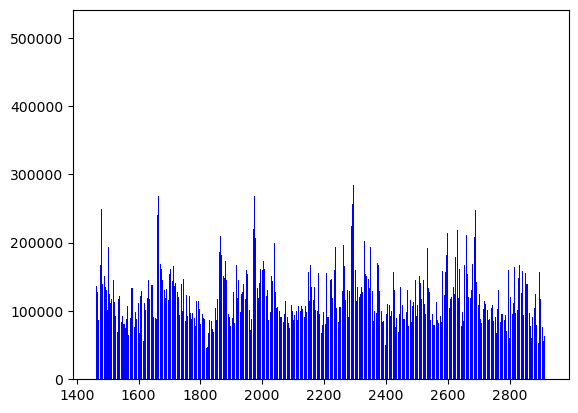

In [362]:
plt.bar(submission['Id'], submission['SalePrice'], color='blue')
plt.ylim(0, submission['SalePrice'].max())

plt.show()

This is our score at competition:

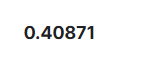